In [ ]:
#Special module written for this class

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import requests
from bs4 import BeautifulSoup

def get_reviews(appid, params={'json': 1}):
    url = 'https://store.steampowered.com/appreviews/'
    response = requests.get(url=url + str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
    return response.json()

def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
        'json': 1,
        'filter': 'all',
        'language': 'english',
        'day_range': 9223372036854775807,
        'review_type': 'all',
        'purchase_type': 'all'
    }

    for _ in range(5):
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += [review['review'] for review in response['reviews']]

        if len(response['reviews']) < 100:
            break

    return reviews

In [ ]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

def get_game_tags(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tags_container = soup.find('div', class_='glance_tags popular_tags')
    if tags_container:
        tags = tags_container.text.strip().split('\n')
        tags = [tag.strip() for tag in tags]
        return tags
    else:
        return []

def get_reviews(appid, params={'json': 1}):
    url = 'https://store.steampowered.com/appreviews/'
    response = requests.get(url=url + str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
    return response.json()

def get_n_reviews_with_tags(appid, n=5):
    reviews = []
    cursor = '*'
    params = {
        'json': 1,
        'filter': 'all',
        'language': 'english',
        'day_range': 9223372036854775807,
        'review_type': 'all',
        'purchase_type': 'all'
    }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        for review in response['reviews']:
            review['tags'] = get_game_tags(f"https://store.steampowered.com/app/{appid}")
            reviews.append(review)

        if len(response['reviews']) < 100:
            break

    return reviews

# Function to get reviews with tags
def get_game_reviews_df_with_tags(app_id_to_game_name_mapping):
    reviews_data = []

    for appid, game_name in app_id_to_game_name_mapping.items():
        reviews = get_n_reviews_with_tags(appid, n=100)  # Limit to the first 100 reviews

        # Extract individual reviews, dates, and tags
        individual_reviews = [review['review'] for review in reviews]
        review_dates = [review['timestamp_created'] for review in reviews]
        review_tags = [review['tags'] for review in reviews]

        # Clean reviews
        cleaned_reviews = [re.sub(r'[\n\r\t]', ' ', review) for review in individual_reviews]

        # Split reviews into lists of words
        tokenized_reviews = [review.split() for review in cleaned_reviews]

        # Convert dates to ranks within each game
        date_ranks = pd.Series(review_dates).rank(method='dense').astype(int)

        # Create a DataFrame with exploded reviews, dates, and tags
        exploded_df = pd.DataFrame({
            'GameName': [game_name] * len(tokenized_reviews),
            'Reviews': tokenized_reviews,
            'Tags': review_tags,
            'Date': review_dates
        })

        reviews_data.append(exploded_df)

    df = pd.concat(reviews_data, ignore_index=True)
    return df

# Replace this with the actual list of links
steam_links = [
    'https://store.steampowered.com/app/1086940/Baldurs_Gate_3/',
    'https://store.steampowered.com/app/730/CounterStrike_2/',
    'https://store.steampowered.com/app/1966720/Lethal_Company/',
    'https://store.steampowered.com/app/1938090/Call_of_Duty/',
    'https://store.steampowered.com/app/1599340/Lost_Ark/',
    'https://store.steampowered.com/app/1085660/Destiny_2/',
    'https://store.steampowered.com/app/2140330/Madden_NFL_24/',
    'https://store.steampowered.com/app/582010/Monster_Hunter_World/',
    'https://store.steampowered.com/app/1623730/Palworld/',
    'https://store.steampowered.com/app/236390/War_Thunder/',
    'https://store.steampowered.com/app/289070/Sid_Meiers_Civilization_VI/',
    'https://store.steampowered.com/app/227300/Euro_Truck_Simulator_2/',
    'https://store.steampowered.com/app/105600/Terraria/',
    'https://store.steampowered.com/app/251570/7_Days_to_Die/',
    'https://store.steampowered.com/app/1551360/Forza_Horizon_5/',
    'https://store.steampowered.com/app/1145360/Hades/',
    'https://store.steampowered.com/app/413150/Stardew_Valley/',
    'https://store.steampowered.com/app/1973530/Limbus_Company/',
    'https://store.steampowered.com/app/1778820/TEKKEN_8/',
    'https://store.steampowered.com/app/620/Portal_2/',
    'https://store.steampowered.com/app/374320/DARK_SOULS_III/'
]

# Extract app ids and game names using regular expressions
app_id_to_game_name_mapping = {}
for link in steam_links:
    match = re.search(r'/app/(\d+)/([^/]+)/', link)
    if match:
        app_id = int(match.group(1))
        game_name = match.group(2).replace('_', ' ')
        app_id_to_game_name_mapping[app_id] = game_name

# Create DataFrame with tags
reviews_df = get_game_reviews_df_with_tags(app_id_to_game_name_mapping)

# Display the DataFrame
print(reviews_df)

            GameName                                            Reviews  \
0     Baldurs Gate 3  [You, know, that, time, when, you're, playing,...   
1     Baldurs Gate 3  [You, can, convince, bosses, to, kill, themsel...   
2     Baldurs Gate 3  [my, work, is, really, cutting, into, my, Bald...   
3     Baldurs Gate 3  [Possessed, a, guard, and, had, them, open, a,...   
4     Baldurs Gate 3  [I, have, only, one, point, of, criticism:, Th...   
...              ...                                                ...   
2095  DARK SOULS III  [This, game, is:, 10%, luck,, 20%, skill,, 15%...   
2096  DARK SOULS III                 [fire, keeper, rule, 34, go, hard]   
2097  DARK SOULS III  [I, have, lost, at, least, 6, SL200, character...   
2098  DARK SOULS III  [whoever, gave, me, 73, ember, while, invading...   
2099  DARK SOULS III  [---{Art, Design}---, ☑, Had, to, Stop, Playin...   

                                                   Tags        Date  
0     [RPG, Choices Matter, S

In [ ]:
# Define the list of genres
valid_genres = ['RPG', 'Adventure', 'FPS', 'Action', 'Horror', 'Sports', 'Strategy', 'MMO', 'Open World',
                'Puzzle', 'Rogue-like', 'Hack and Slash', 'Arcade', 'Fighter', 'Visual Novel', 'Sandbox',
                'Dating', 'Simulation', 'Racing', 'Survival', 'Platformer']

# Function to filter the tags based on valid genres
def filter_genres(tags):
    return [tag for tag in tags if tag in valid_genres]

# Apply the function to create the 'genre' column
reviews_df['genre'] = reviews_df['Tags'].apply(filter_genres)

In [ ]:
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [ ]:
import numpy as np
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

reviews_df['tokenized_reviews'] = reviews_df['Reviews'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])

reviews_df['normalized_reviews'] = reviews_df['tokenized_reviews'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
reviews_df.to_csv('/content/drive/My Drive/reviews_df.csv', index=False)

In [ ]:
import pandas as pd

# Path to the CSV file in your Google Drive
file_path = '/content/drive/My Drive/Computational Content Analysis Project/reviews_df.csv'

# Read the CSV file into a DataFrame
reviews_df = pd.read_csv(file_path)

In [ ]:
import re

# Define a function to check if all values in a list consist entirely of non-letters
def all_values_consist_only_non_letters(lst):
    # Use all() to check if all values in the list consist entirely of non-letters
    return all([not bool(re.match(r'^[^\w\s]*$', str(value))) for value in lst])

# Apply the function to each list in the 'normalized_reviews' column
# This will return True if all values in the list consist entirely of non-letters, and False otherwise
contains_only_non_letters = reviews_df['normalized_reviews'].apply(all_values_consist_only_non_letters)

# Filter the DataFrame to remove rows where all values in a list in 'normalized_reviews' consist entirely of non-letters
reviews_df = reviews_df[contains_only_non_letters == False]

In [ ]:
# Define a function to convert the string to a list based on brackets
def string_to_list(string):
    result = []
    temp = ''

    for char in string:
        if char == '[':
            if temp:
                result.append(temp)
                temp = ''
        elif char == ']':
            if temp:
                result.append(temp)
                temp = ''
        elif char == ',':
            if temp:
                result.append(temp)
                temp = ''
        else:
            temp += char

    # Append the remaining characters if any
    if temp:
        result.append(temp)

    return result

# Apply the function to each row of the 'normalized_reviews' column
reviews_df['new_normalized_reviews'] = reviews_df['normalized_reviews'].apply(string_to_list)

# Remove apostrophes from the new_normalized_reviews column
reviews_df['new_normalized_reviews'] = reviews_df['new_normalized_reviews'].apply(lambda x: [word.replace("'", "") for word in x])

In [ ]:
# Extract words from normalized_reviews
all_words = []

# Iterate through each row of the 'normalized_reviews' column
for row in reviews_df['normalized_reviews']:
    # Remove brackets and split the string into words
    words = row.replace('[', '').replace(']', '').replace("'", "").split(', ')
    # Extend the list of all words with the words from the current row
    all_words.extend(words)

# Create a new DataFrame with each word in a separate row
exploded_df = pd.DataFrame({'Word': all_words})

#### Bigrams and trigrams are not informative, so don't include them in paper.

In [ ]:
from nltk.util import skipgrams
from nltk import FreqDist

# Assuming you have a list of words in the 'Reviews' column
all_reviews_words = exploded_df['Word'].tolist()

# Function to generate n-grams with unique word order
def generate_unique_word_order_ngrams(words, n):
    unique_word_order_ngrams = set(tuple(sorted(ngram)) for ngram in zip(*[words[i:] for i in range(n)]))
    return unique_word_order_ngrams

# Calculate the frequency distribution of bigrams
unique_bigrams_freq = FreqDist(generate_unique_word_order_ngrams(all_reviews_words, 2))

# Calculate the frequency distribution of trigrams
unique_trigrams_freq = FreqDist(generate_unique_word_order_ngrams(all_reviews_words, 3))

# Display the most common unique bigrams, trigrams, quadgrams, five-grams, and skipgrams
print("Top 10 Unique Bigrams:")
print(unique_bigrams_freq.most_common(10))
print("\nTop 10 Unique Trigrams:")
print(unique_trigrams_freq.most_common(10))

Top 10 Unique Bigrams:
[(('incomplete', 'yes'), 1), (('levels', 'matches'), 1), (('reviews', 'sure'), 1), (('mods', 'use'), 1), (('exciting', 'possibilities'), 1), (('away', 'punishment'), 1), (('emote', 'like'), 1), (('gravitas', 'greek'), 1), (('afraid', 'projectmoon'), 1), (('balance', 'satisfying'), 1)]

Top 10 Unique Trigrams:
[(('character', 'considerable', 'roster'), 1), (('airdrops', 'eating', 'lots'), 1), (('condescension', 'thinly', 'vitriol'), 1), (('base', 'https://youtu.be/px1zhmbv0hc', 'video'), 1), (('game', 'twice', 'worth'), 1), (('fence', 'step', 'try'), 1), (('company', 'driver', 'started'), 1), (('featured', 'remixes', 'showcase'), 1), (('complex', 'gathered', 'going'), 1), (('grinding', 'like', 'year+'), 1)]


In [ ]:
reviews_df.to_csv('/content/drive/My Drive/reviews_df.csv', index=False)

#### Word frequencies

In [ ]:
# Convert values in the 'new_normalized_reviews' column
reviews_df['new_normalized_reviews'] = reviews_df['new_normalized_reviews'].apply(eval)

In [ ]:
# Initialize an empty list to store all words
flattened_normalized_reviews = []

# Iterate through each row of the 'new_normalized_reviews' column
for review_list in reviews_df['new_normalized_reviews']:
    # Iterate through each word within the review list
    for word in review_list:
        # Append the word to the flattened list
        flattened_normalized_reviews.append(word.strip())  # Remove leading/trailing spaces

# Create a new DataFrame with each word in a separate row
flattened_reviews_df = pd.DataFrame({'Word': flattened_normalized_reviews})

# Display the new dataframe
print(flattened_reviews_df)

             Word
0            know
1            time
2         playing
3             d&d
4           think
...           ...
181101        pvp
181102      learn
181103  memorable
181104       boss
181105      fight

[181106 rows x 1 columns]


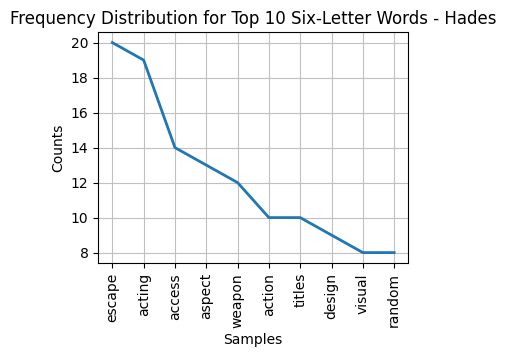

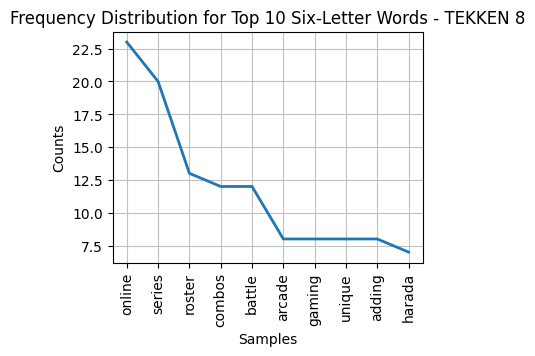

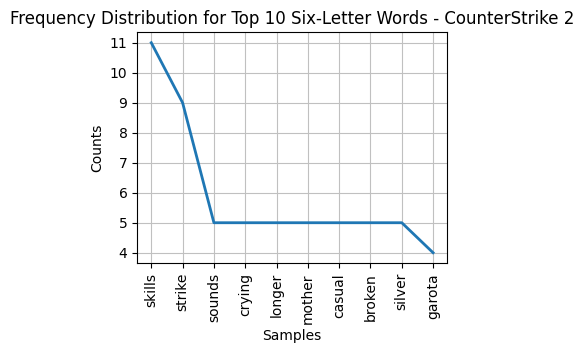

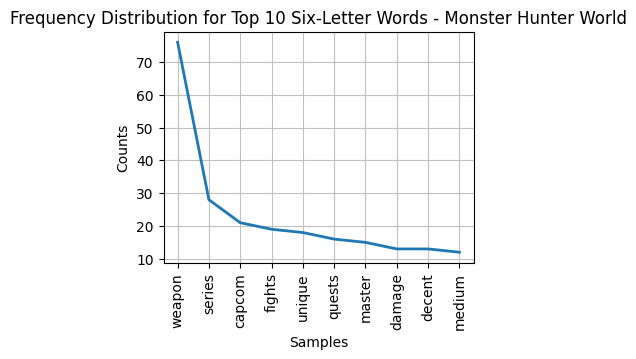

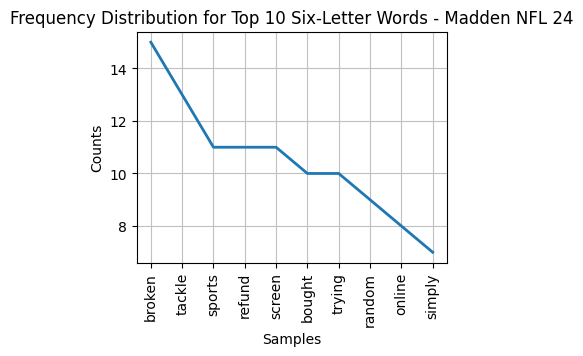

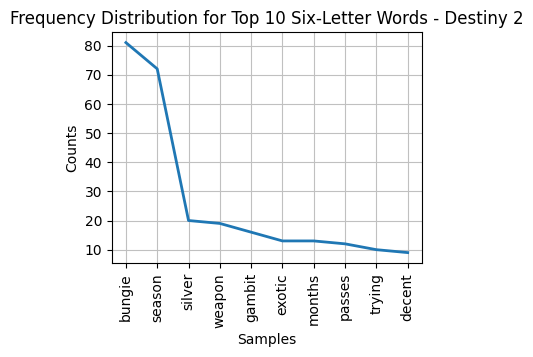

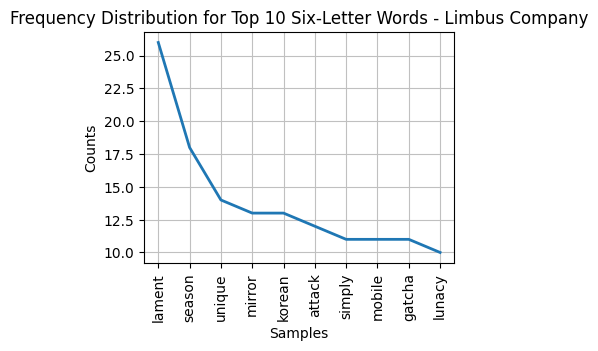

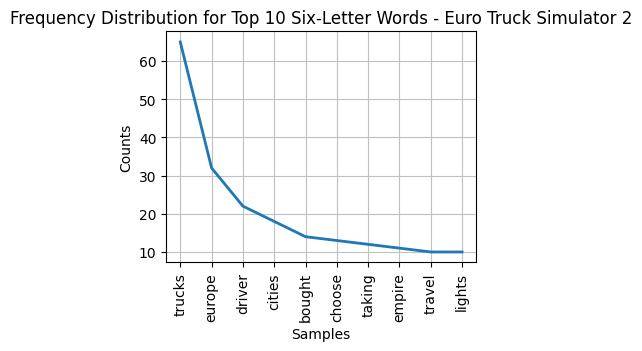

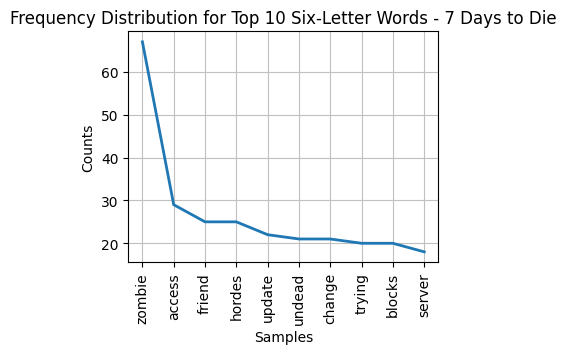

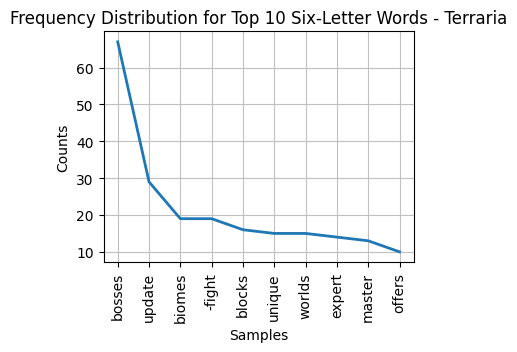

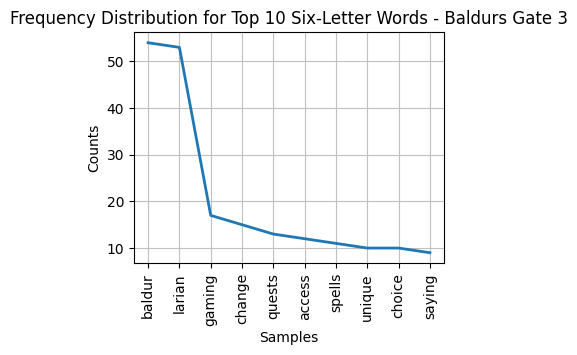

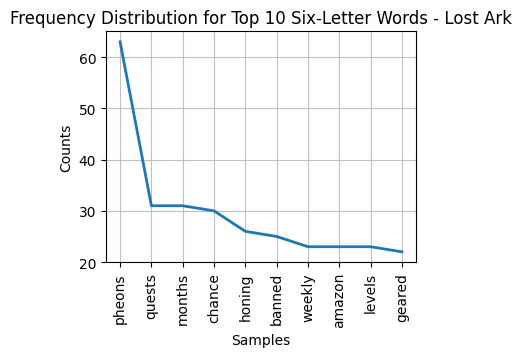

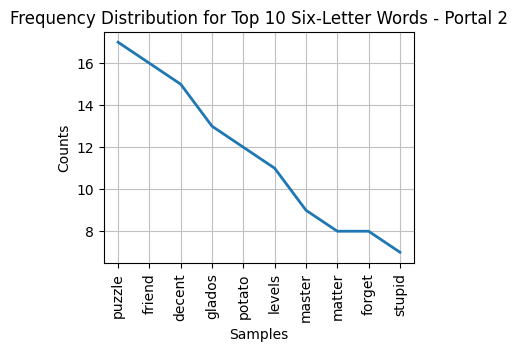

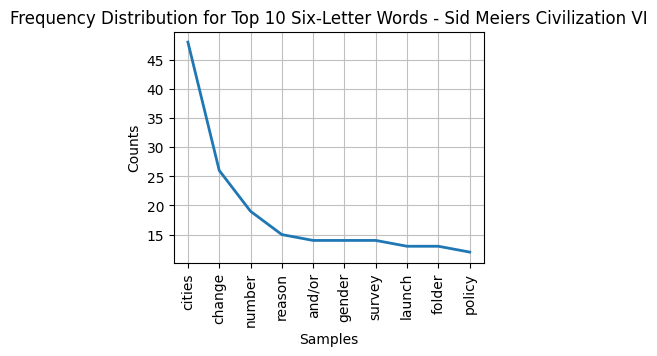

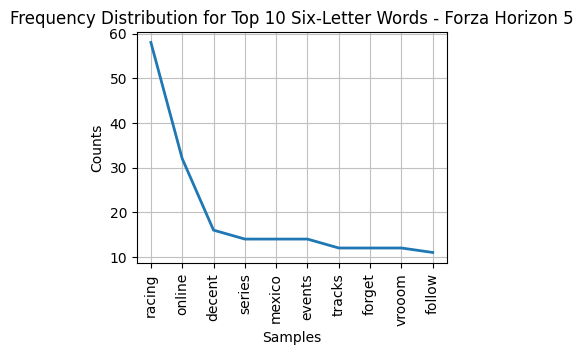

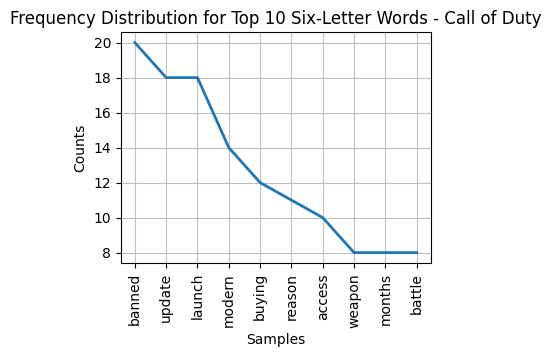

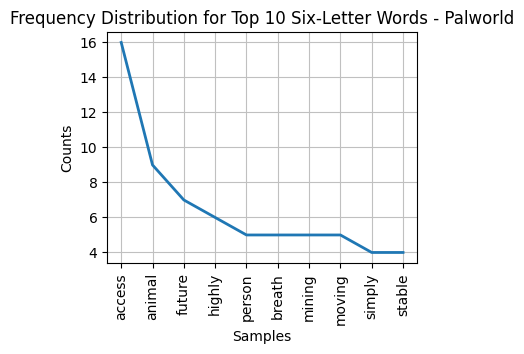

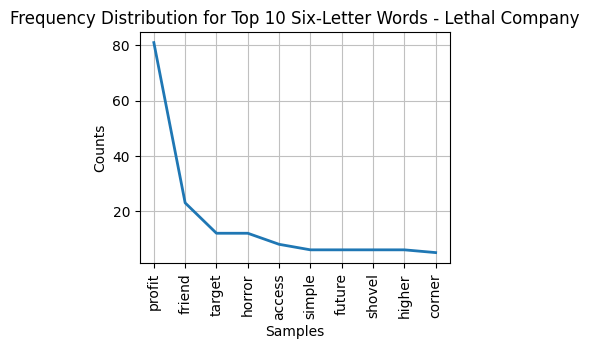

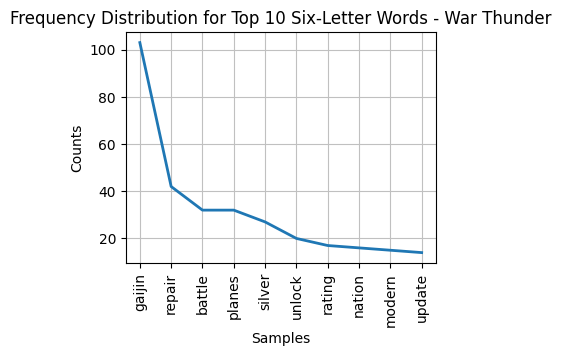

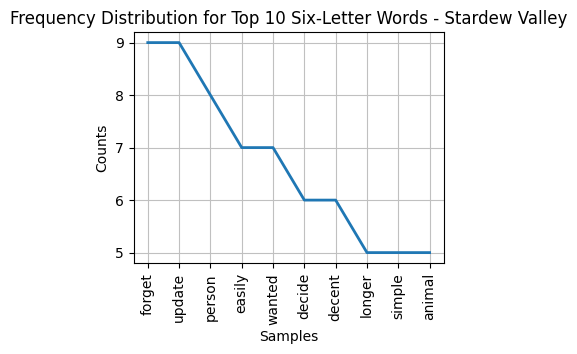

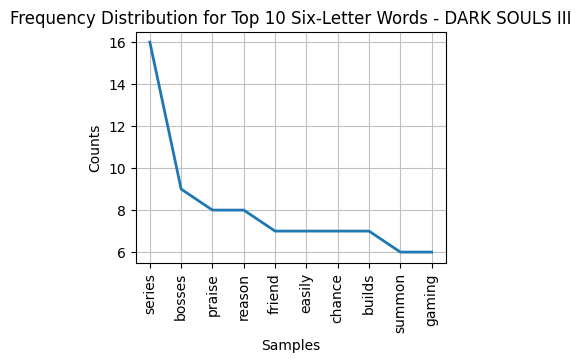

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter

# Sample data for normalized_reviews
normalized_reviews = reviews_df["new_normalized_reviews"]

# Flatten the list of lists of normalized reviews
all_words = [word for review_list in normalized_reviews for review in review_list]

# Count the frequency of each word in the 'normalized_reviews' column
word_counts = Counter(all_words)

# Identify the thirty most common words
thirty_most_common_words = [word for word, _ in word_counts.most_common(100)]

# Create a list to store all game name words separately on separate lines
game_name_words = [word.lower() for game_name in unique_game_names for word in game_name.split()]

for game_name in unique_game_names:

    # Find the reviews corresponding to the current game name
    reviews_for_game_name = normalized_reviews[reviews_df['GameName'] == game_name]

    # Flatten the list of lists and remove punctuation marks, excluding "valley"
    flat_normalized_reviews = [word for sentence in reviews_for_game_name for word in sentence]

    # Remove all spaces in flat_normalized_reviews while keeping each word on a separate line
    flat_normalized_reviews = [char for word in flat_normalized_reviews for char in word.split()]

    # Remove game name words and the thirty most common words from flat_normalized_reviews
    flat_normalized_reviews = [word for word in flat_normalized_reviews if word.lower() not in game_name_words + thirty_most_common_words]

    # Create Frequency Distribution for six-letter words
    six_letter_words = [word for word in flat_normalized_reviews if len(word) == 6]
    six_letter_words_freq = FreqDist(six_letter_words)

    # Plot the frequency distribution for the top 10 six-letter words
    plt.figure(figsize=(4, 3))
    title = f'Frequency Distribution for Top 10 Six-Letter Words - {game_name}'
    six_letter_words_freq.plot(10, title=title)

#### Word embeddings

In [ ]:
import pandas as pd
import ast

# Path to the CSV file in your Google Drive
file_path = '/content/drive/My Drive/Computational Content Analysis Project/reviews&date_cleaned.csv'

# Define a function to safely convert strings to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except Exception as e:
        print(f"Error occurred while converting {string} to list: {e}")
        return []

# Read the CSV file into a DataFrame with the converter function
reviews_df = pd.read_csv(file_path, converters={'normalized_reviews': convert_to_list, 'genre': convert_to_list})

In [ ]:
# Extract the first list from each row in 'normalized_reviews' column
organized_reviews = []
for row in reviews_df['normalized_reviews']:
    # Check if the row contains a non-empty list
    if isinstance(row, list) and row:
        organized_reviews.append(row[0])
    else:
        # If the row doesn't contain a non-empty list, append None
        organized_reviews.append(None)

# Add 'organized_reviews' column to the DataFrame
reviews_df['organized_reviews'] = organized_reviews

# Extract the first list from each row in 'genre' column
organized_genre = []
for row in reviews_df['genre']:
    # Check if the row contains a non-empty list
    if isinstance(row, list) and row:
        organized_genre.append(row[0])
    else:
        # If the row doesn't contain a non-empty list, append None
        organized_genre.append(None)

# Add 'organized_genre' column to the DataFrame
reviews_df['organized_genre'] = organized_genre

In [ ]:
import gensim
import string

# Ensure each item in 'normalized_tokens' is a list of words
normalized_sentences = reviews_df['organized_reviews']

# Filter out None values from normalized_sentences and remove symbols
filtered_sentences = []
for sentence in normalized_sentences:
    if sentence is not None:
        filtered_sentence = [word for word in sentence if word not in string.punctuation and '?' not in word]
        filtered_sentences.append(filtered_sentence)

# Train Word2Vec model using your dataset
reviewsW2V = gensim.models.word2vec.Word2Vec(filtered_sentences, sg=0)

In [ ]:
import gensim
import string

# Ensure each item in 'normalized_tokens' is a list of words
normalized_sentences = reviews_df['organized_reviews']

# Filter out None values from normalized_sentences and remove symbols
filtered_sentences = []
for sentence in normalized_sentences:
    if sentence is not None:
        filtered_sentence = [word for word in sentence if word not in string.punctuation and '?' not in word]
        filtered_sentences.append(filtered_sentence)

# Create a dictionary to store Word2Vec models for each GameName
word2vec_models = {}

# Iterate over unique GameName values
unique_game_names = reviews_df['GameName'].unique()
for game_name in unique_game_names:
    # Filter sentences for the current GameName
    game_name_sentences = [sentence for sentence, name in zip(filtered_sentences, reviews_df['GameName']) if name == game_name]

    # Train Word2Vec model for the current GameName
    word2vec_model = gensim.models.word2vec.Word2Vec(game_name_sentences, sg=0)

    # Store the Word2Vec model for the current GameName in the dictionary
    word2vec_models[game_name] = word2vec_model

In [ ]:
import numpy as np
import sklearn.decomposition
import sklearn.manifold

# Filter out words with apostrophes
numWords = 40
targetWords = [word for word in reviewsW2V.wv.index_to_key[:numWords] if "'" not in word]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(reviewsW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)

pcaWords = sklearn.decomposition.PCA(n_components=40).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

# T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components=2).fit_transform(reducedPCA_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


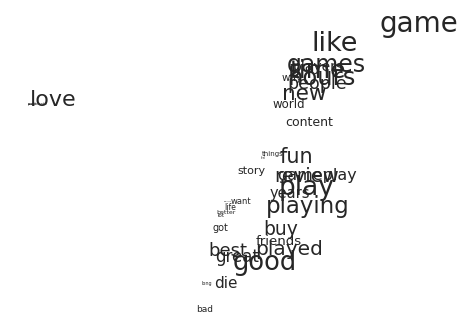

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha=0)  # Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i], tsneWords[:, 1][i]), size=20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Visualizing embeddings for Baldurs Gate 3...


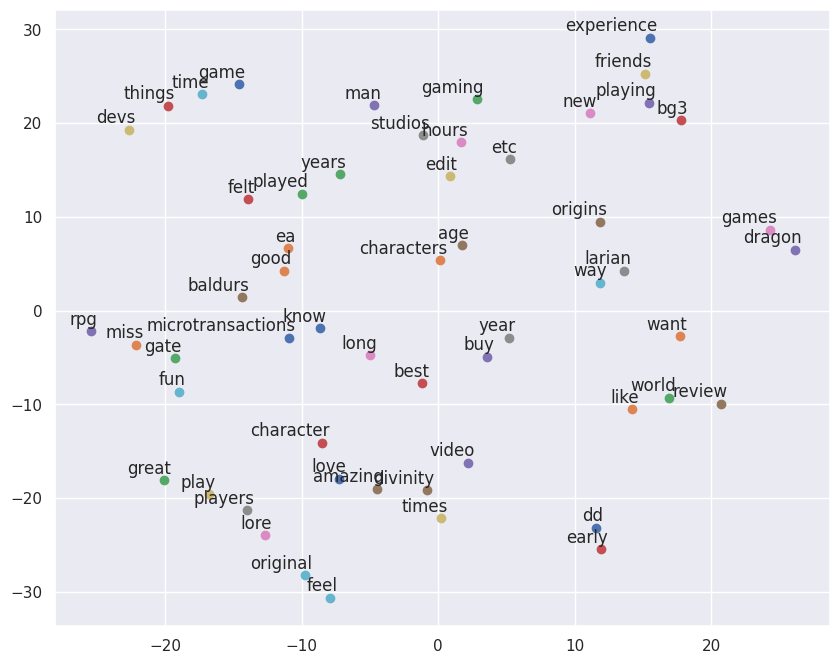

Visualizing embeddings for CounterStrike 2...


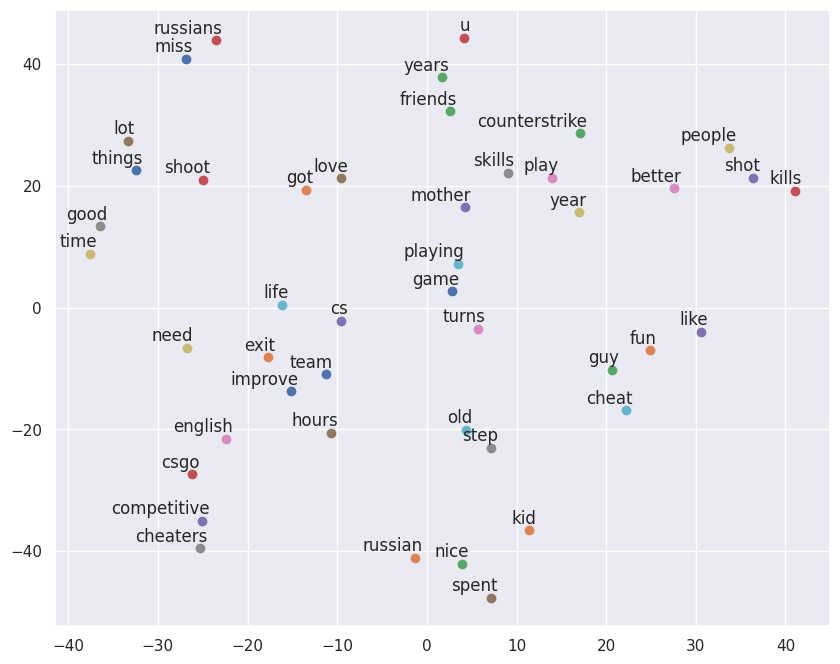

Visualizing embeddings for Lethal Company...


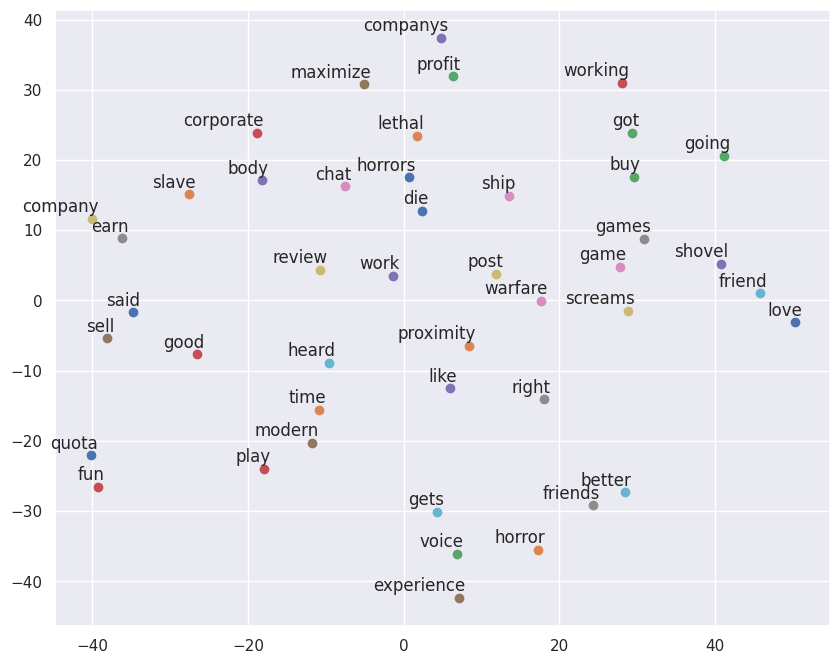

Visualizing embeddings for Call of Duty...


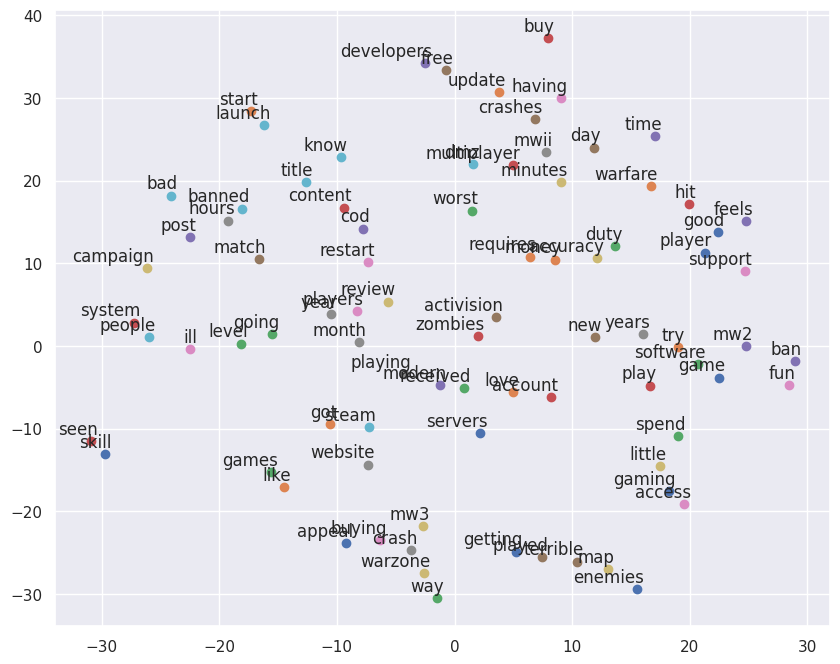

Visualizing embeddings for Lost Ark...


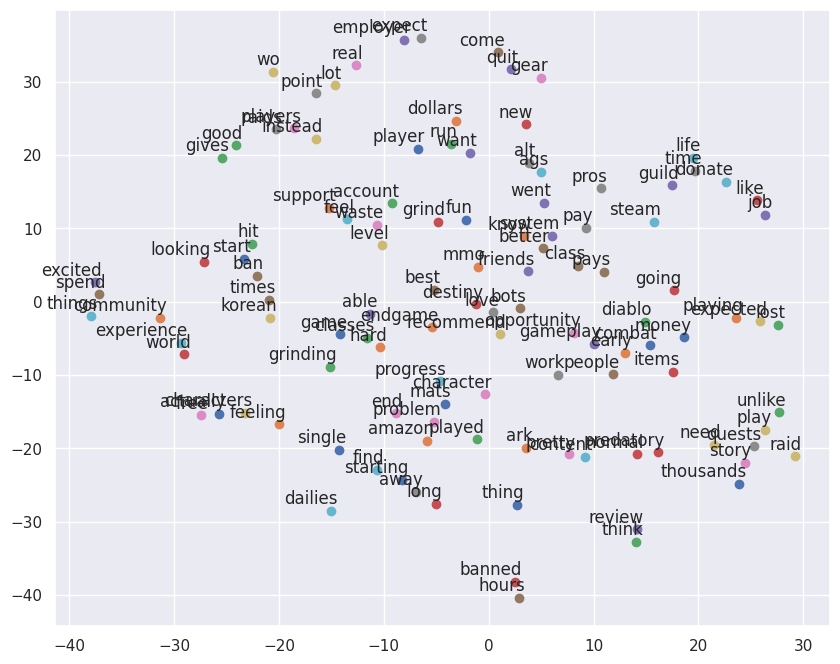

Visualizing embeddings for Destiny 2...


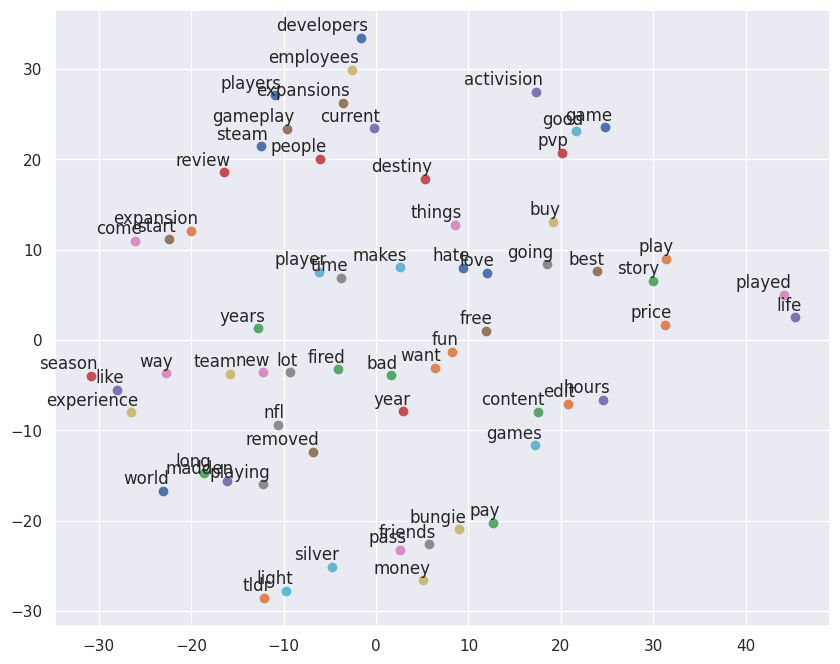

Visualizing embeddings for Madden NFL 24...


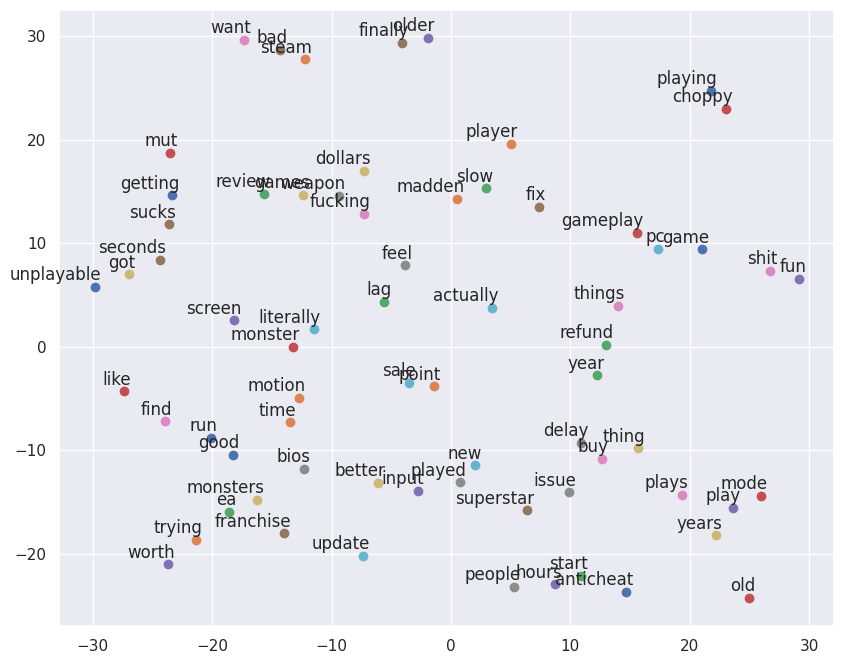

Visualizing embeddings for Monster Hunter World...


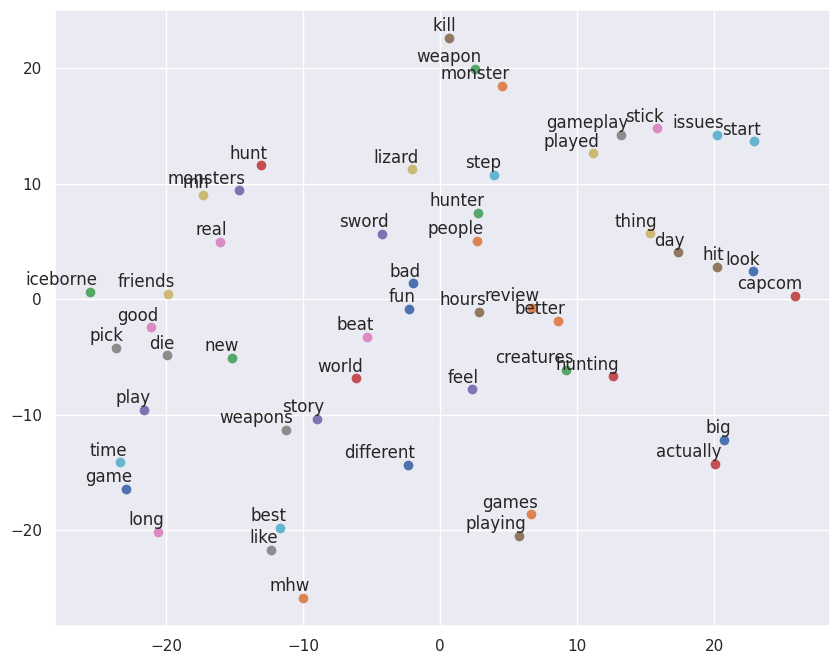

Visualizing embeddings for Palworld...


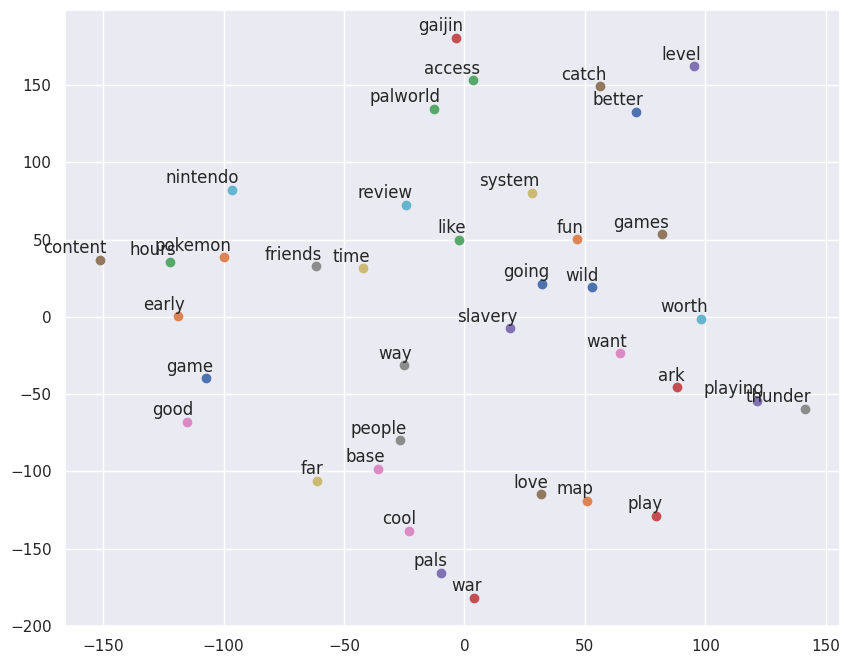

Visualizing embeddings for War Thunder...


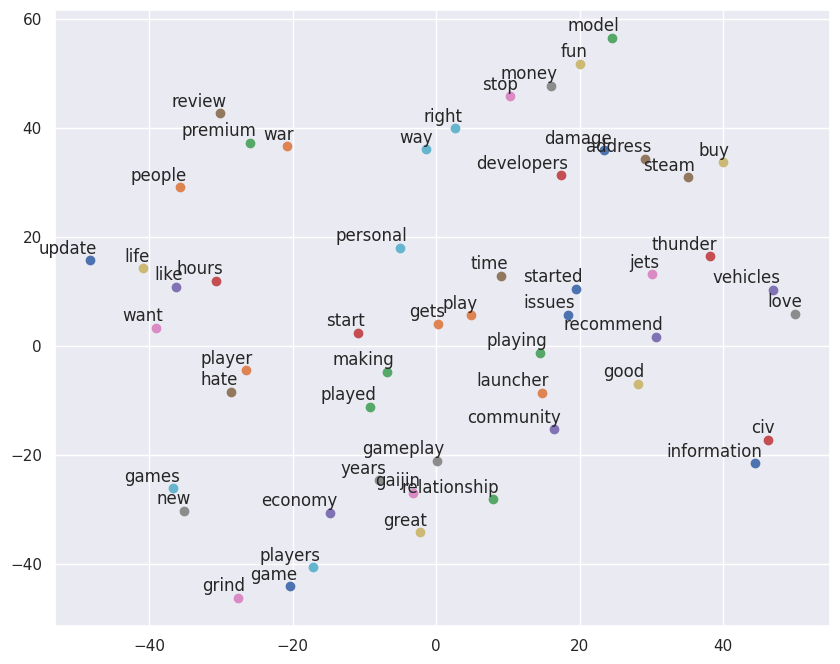

Visualizing embeddings for Sid Meiers Civilization VI...


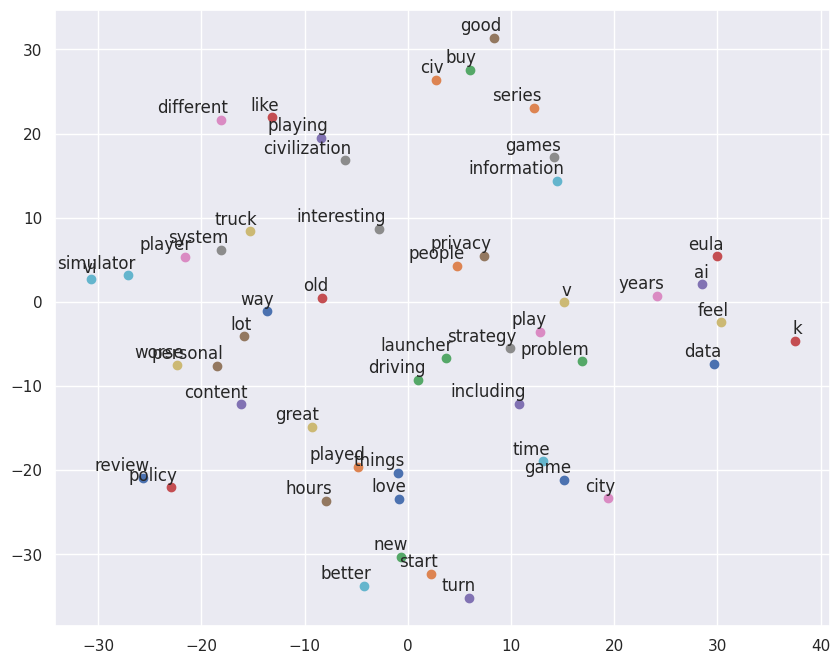

Visualizing embeddings for Euro Truck Simulator 2...


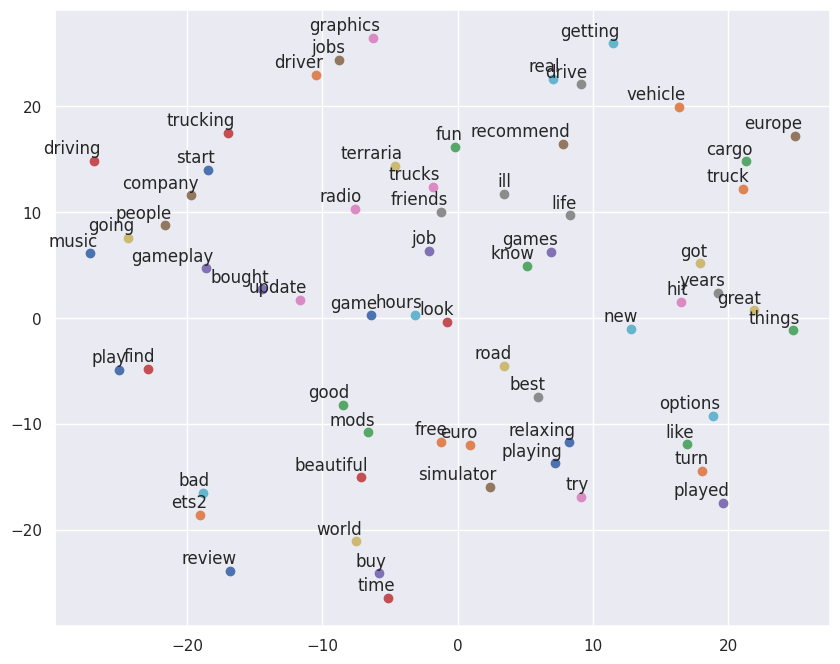

Visualizing embeddings for Terraria...


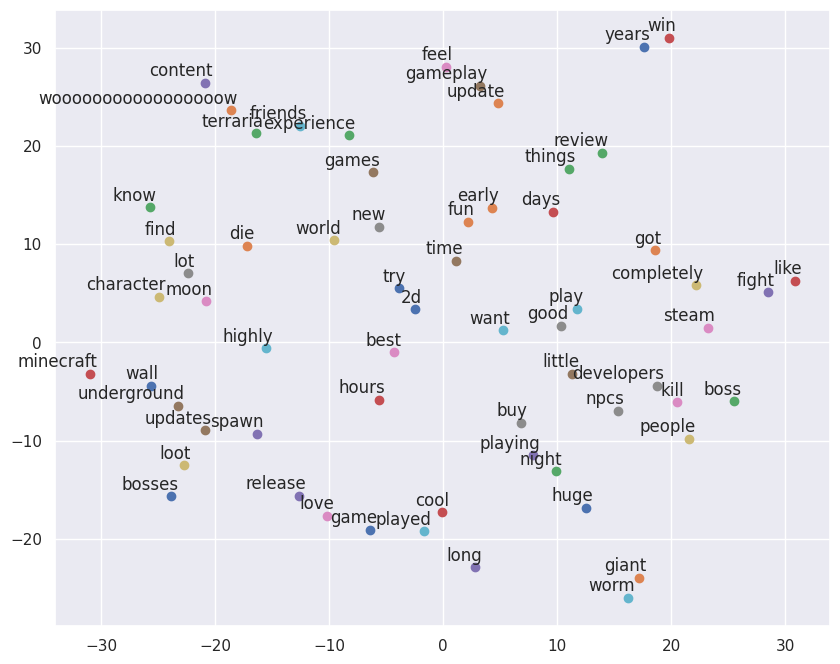

Visualizing embeddings for 7 Days to Die...


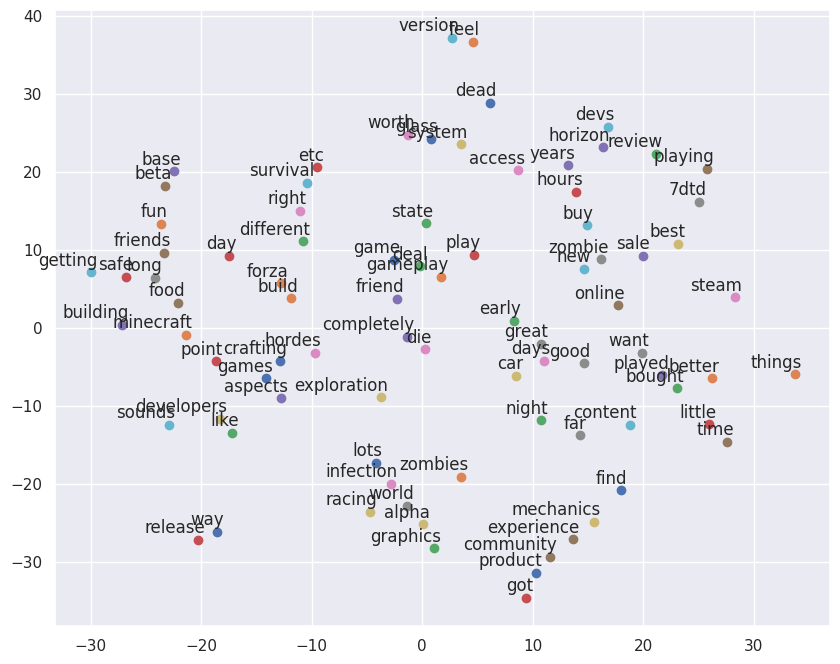

Visualizing embeddings for Forza Horizon 5...


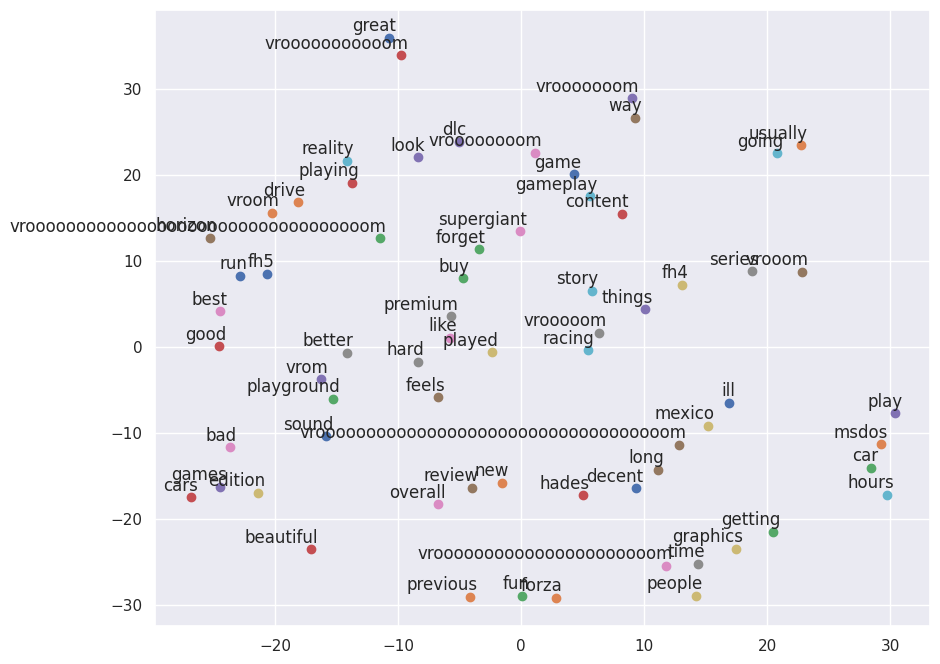

Visualizing embeddings for Hades...


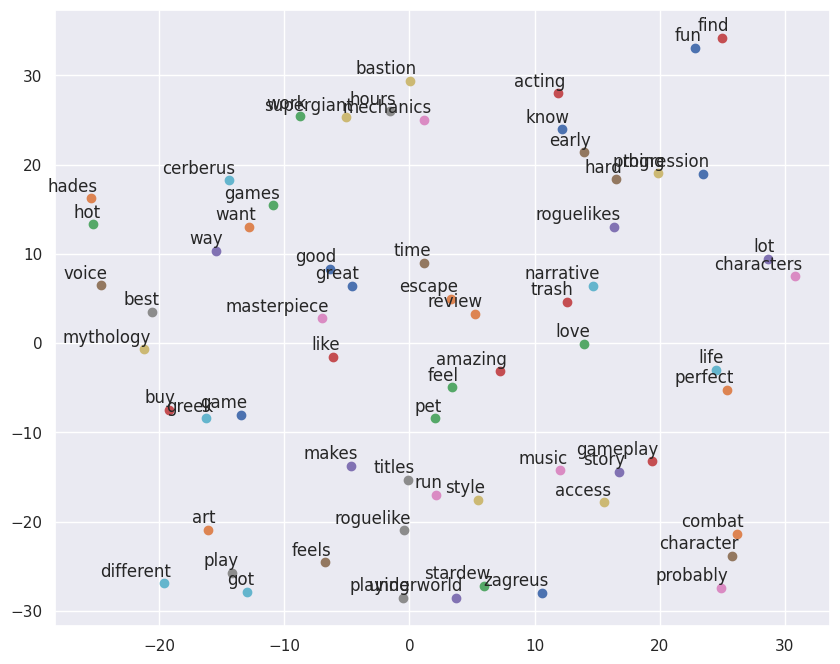

Visualizing embeddings for Stardew Valley...


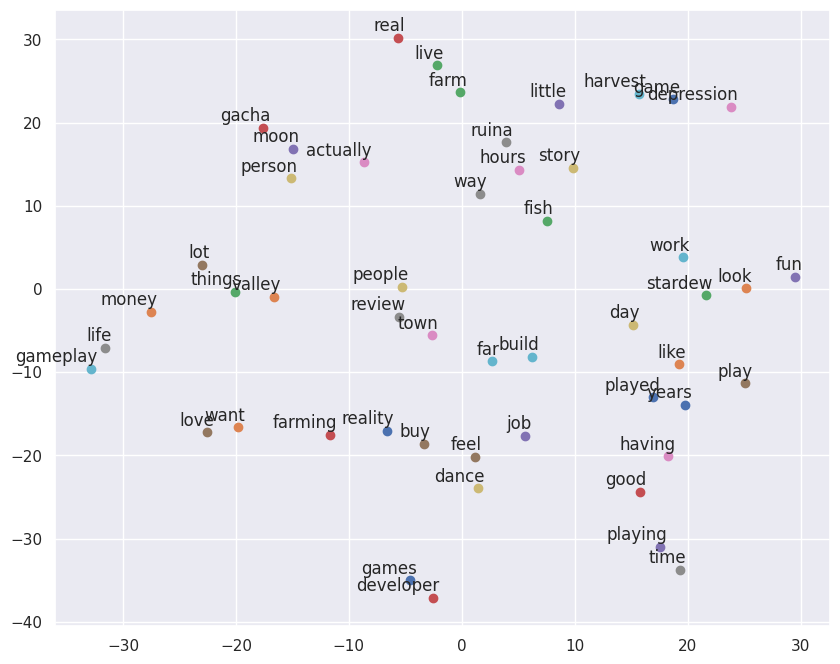

Visualizing embeddings for Limbus Company...


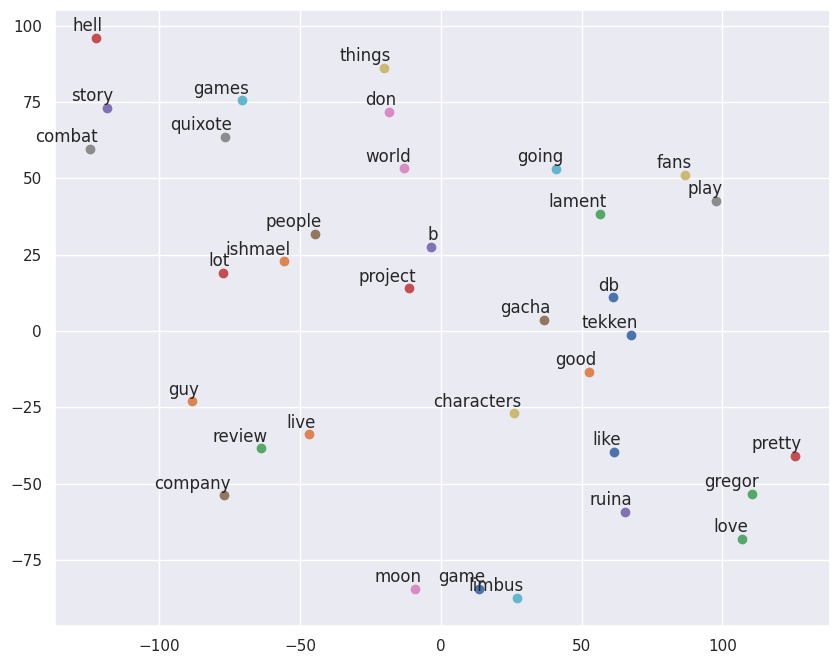

Visualizing embeddings for TEKKEN 8...


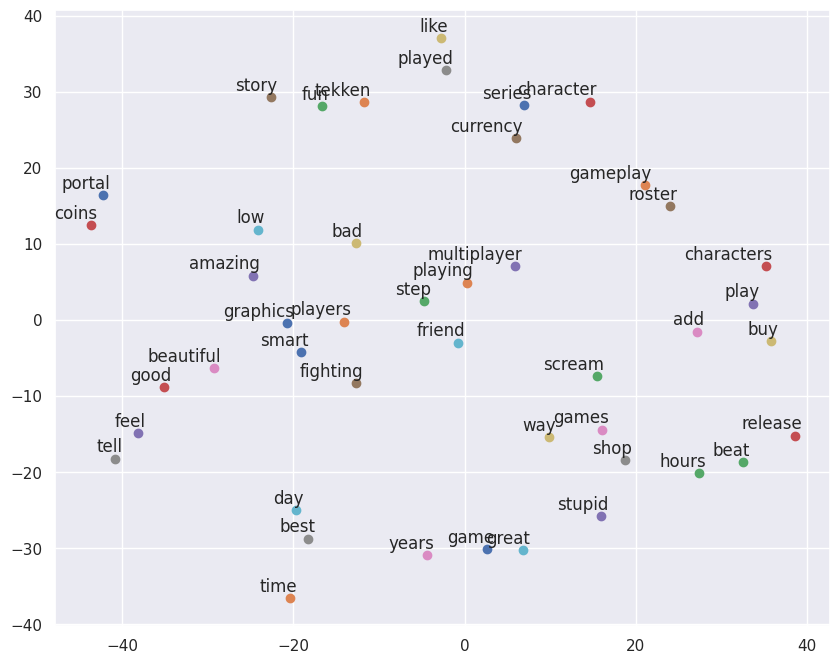

Visualizing embeddings for Portal 2...


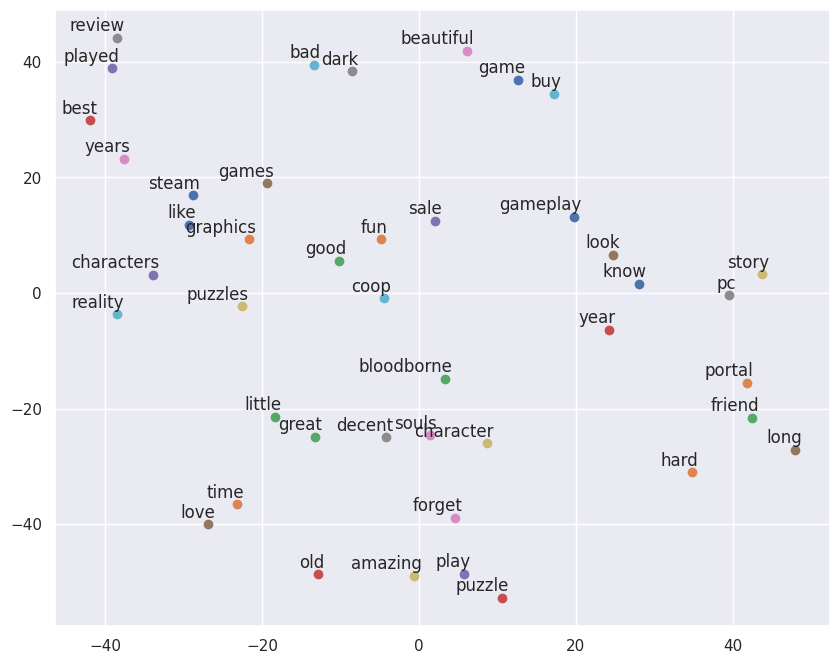

Visualizing embeddings for DARK SOULS III...


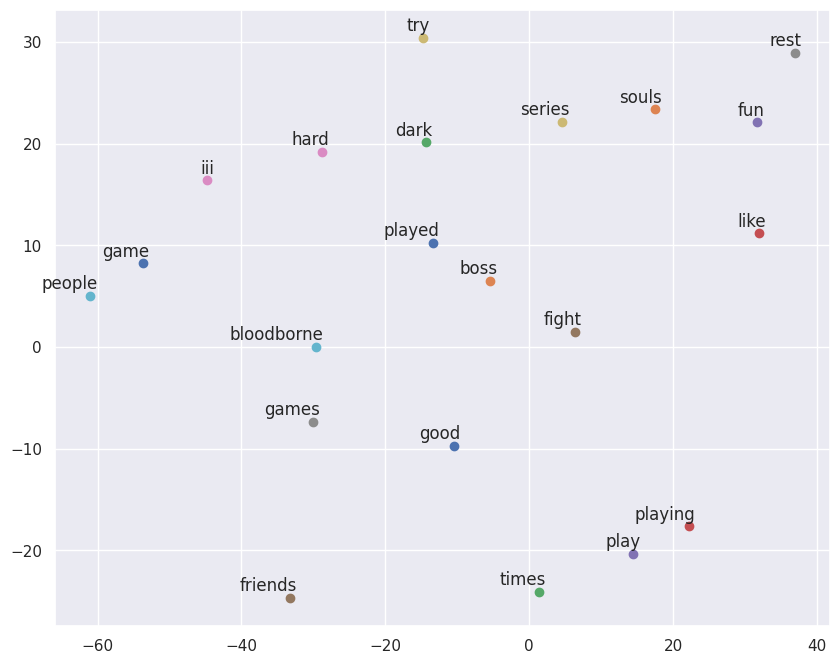

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_word_embeddings(word2vec_model):
    # Extract vocabulary and vectors from the Word2Vec model
    vocabulary = word2vec_model.wv.index_to_key
    word_vectors = word2vec_model.wv.vectors

    # Perform dimensionality reduction using t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # Adjust perplexity here
    embeddings = tsne.fit_transform(word_vectors)

    # Visualize embeddings
    plt.figure(figsize=(10, 8))
    for word, (x, y) in zip(vocabulary, embeddings):
        plt.scatter(x, y)
        plt.annotate(word, (x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

# Visualize embeddings for each Word2Vec model
for game_name, word2vec_model in word2vec_models.items():
    print(f"Visualizing embeddings for {game_name}...")
    visualize_word_embeddings(word2vec_model)

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize  # You may need to install nltk and download necessary resources

# Assuming you have already tokenized your reviews, you can use them directly
# Create TaggedDocument objects for each game's reviews, skipping rows where organized_reviews is None
tagged_data = []
for game_name, review_list in zip(reviews_df['GameName'], reviews_df['organized_reviews']):
    if review_list is not None:
        for review in review_list:
            # Tokenize the review using word_tokenize from NLTK or any other tokenizer
            tokens = word_tokenize(review)
            tagged_data.append(TaggedDocument(words=tokens, tags=[game_name]))

# Train the Doc2Vec model
d2v_model = Doc2Vec(tagged_data, vector_size=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#most content-focused games
d2v_model.dv.most_similar([d2v_model['content']], topn=5)

[('TEKKEN 8', 0.09403706341981888),
 ('CounterStrike 2', 0.09193538874387741),
 ('Madden NFL 24', 0.03827197849750519),
 ('Hades', 0.006983740255236626),
 ('Call of Duty', 0.004532715305685997)]

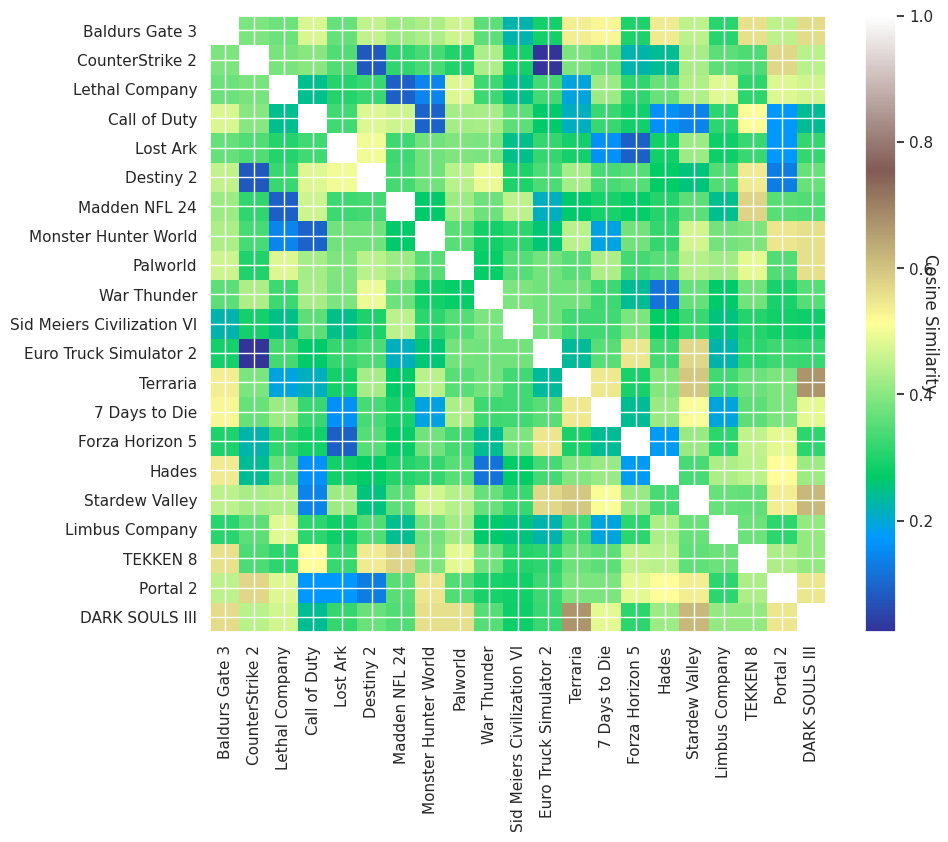

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Get the number of games from the 'GameName' column in the reviews_df DataFrame
num_games = len(reviews_df['GameName'].unique())

# Initialize an empty heatmap matrix
heatmapMatrix = np.zeros((num_games, num_games))

# Compute cosine similarity between document vectors for each pair of games
for i in range(num_games):
    for j in range(num_games):
        # Compute cosine similarity between document vectors for games i and j
        similarity = cosine_similarity(
            [d2v_model.dv[i]],
            [d2v_model.dv[j]]
        )[0][0]
        heatmapMatrix[i][j] = similarity

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
hmap = ax.imshow(heatmapMatrix, cmap='terrain', interpolation='nearest')

# Add color bar
cbar = plt.colorbar(hmap)
cbar.set_label('Cosine Similarity', rotation=270)

# Set labels using game names from the 'GameName' column of reviews_df
game_names = reviews_df['GameName'].unique()
ax.set_xticks(np.arange(num_games))
ax.set_yticks(np.arange(num_games))
ax.set_xticklabels(game_names, rotation=90)
ax.set_yticklabels(game_names)

plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


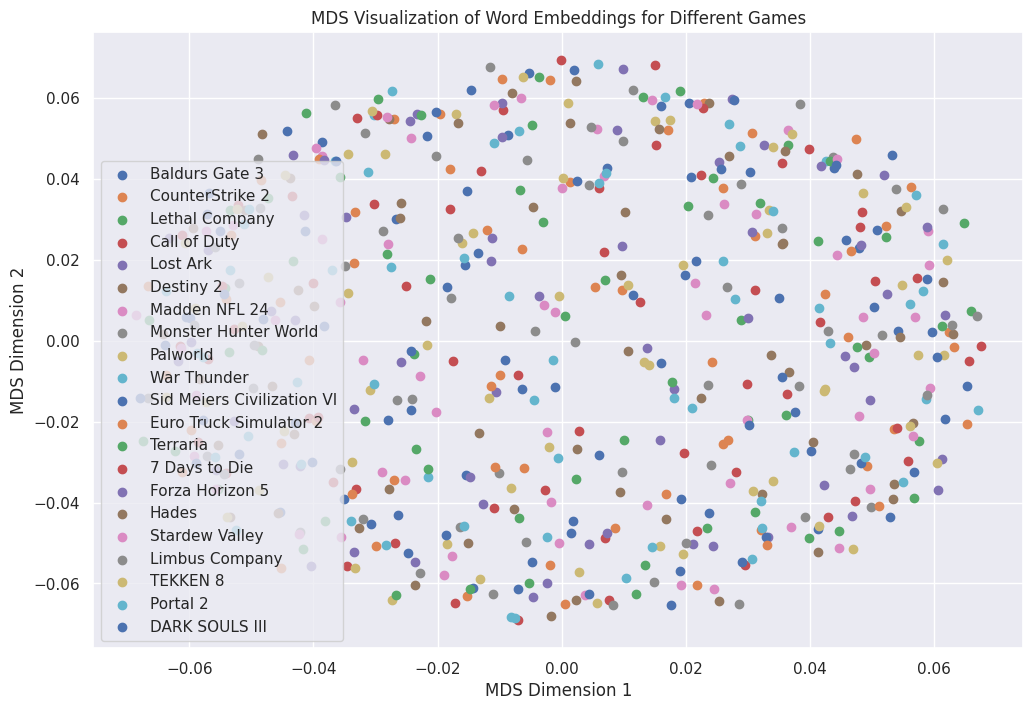

In [ ]:
import gensim
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for this cell
warnings.filterwarnings('ignore')

# Define a list of unique game names
game_names = reviews_df['GameName'].unique()

# Create a figure and axis object for the plot
plt.figure(figsize=(12, 8))

# Iterate over each game name
for game_name in game_names:
    # Filter the DataFrame for the current game
    filtered_reviews_df = reviews_df[reviews_df['GameName'] == game_name]

    # Ensure each item in 'organized_reviews' is a list of words
    normalized_sentences = filtered_reviews_df['organized_reviews'].tolist()

    # Remove None values from normalized_sentences
    normalized_sentences = [sent for sent in normalized_sentences if sent is not None]

    if normalized_sentences:
        # Train Word2Vec model using the dataset for the current game
        reviewsW2V = gensim.models.Word2Vec(sentences=normalized_sentences, vector_size=100, window=5, min_count=1, workers=4)

        # Get the first thirty words in the vocabulary
        vocab = list(reviewsW2V.wv.index_to_key)[:30]

        # Extract embeddings for the first thirty words
        embeddings = [reviewsW2V.wv[word] for word in vocab]

        # Compute pairwise distances between words
        distances = np.zeros((len(vocab), len(vocab)))
        for i in range(len(vocab)):
            for j in range(len(vocab)):
                distances[i][j] = np.linalg.norm(embeddings[i] - embeddings[j])

        # Apply MDS to reduce dimensions
        mds = MDS(n_components=2, dissimilarity='precomputed')
        embeddings_2d = mds.fit_transform(distances)

        # Plot the embeddings for the current game
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], label=game_name)

# Add legend
plt.legend()

plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Visualization of Word Embeddings for Different Games')
plt.grid(True)
plt.show()

# Re-enable warnings after executing the cell
warnings.filterwarnings('default')

#### Linguistic change

####Yearly (ONLY FOR GAMES PRE-2022)

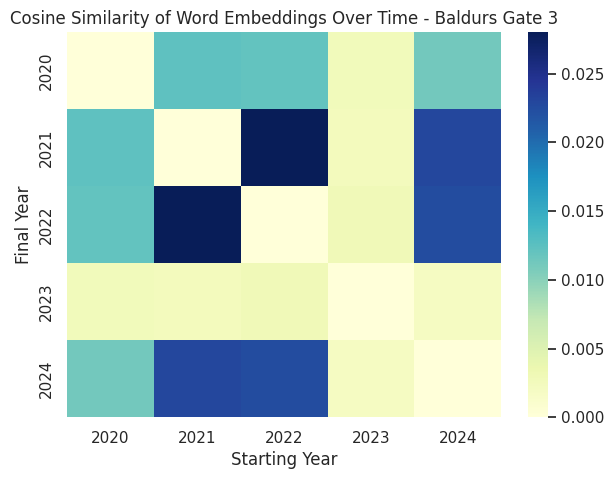

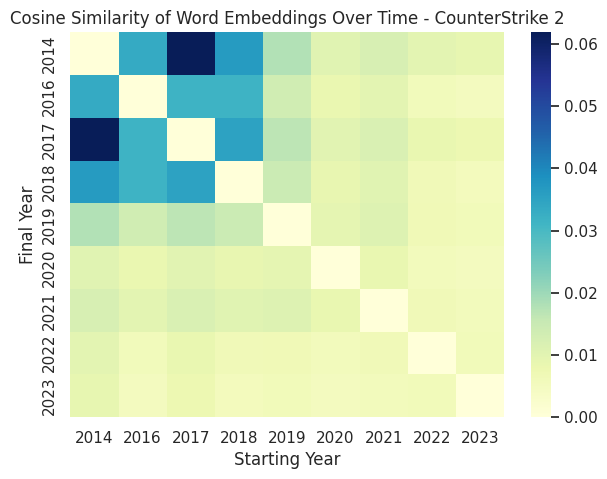

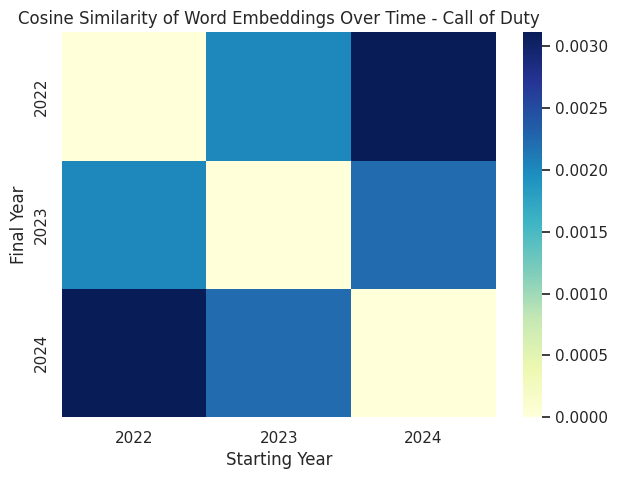

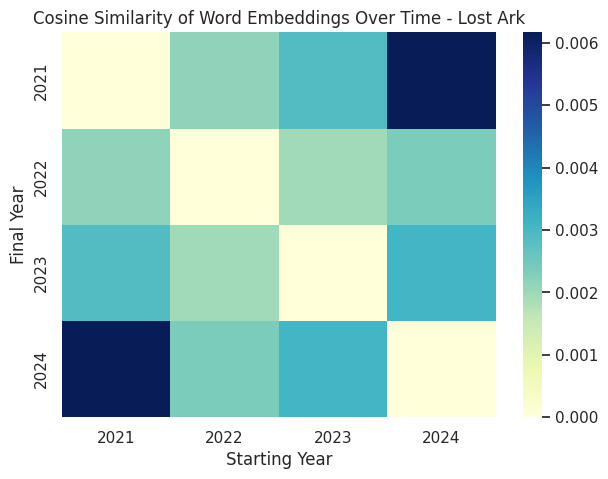

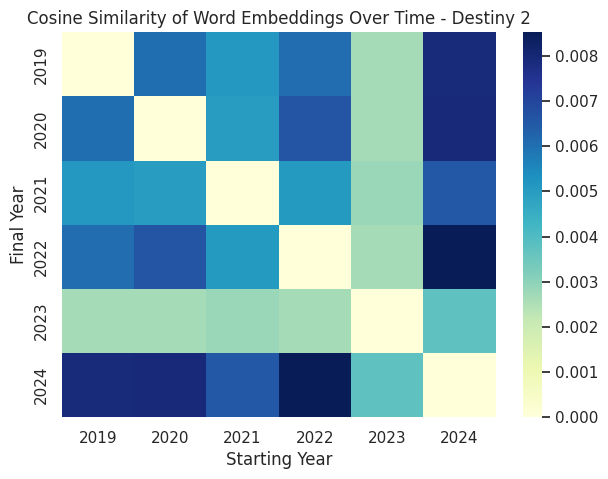

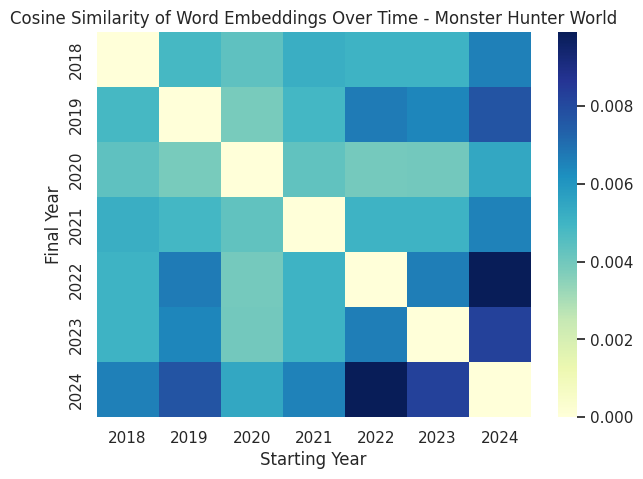

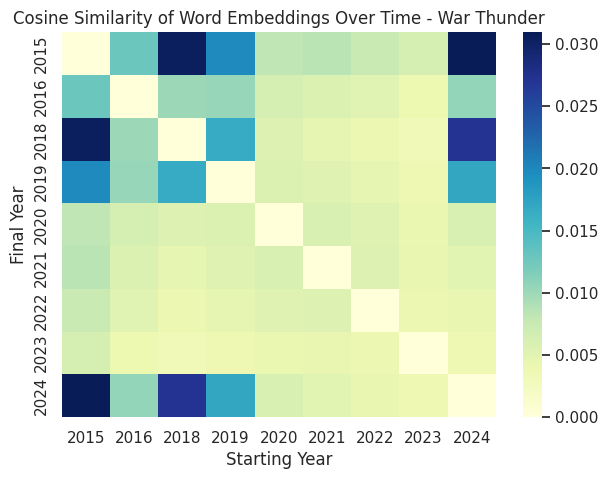

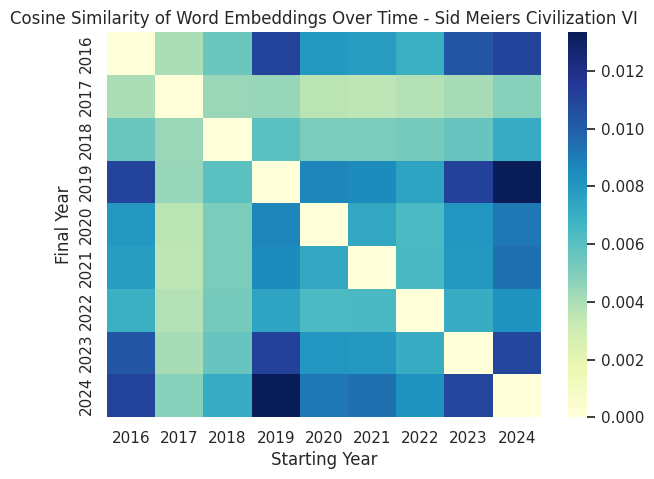

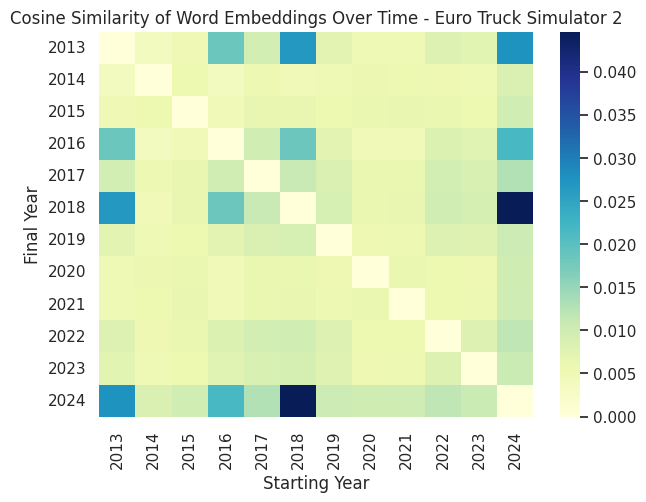

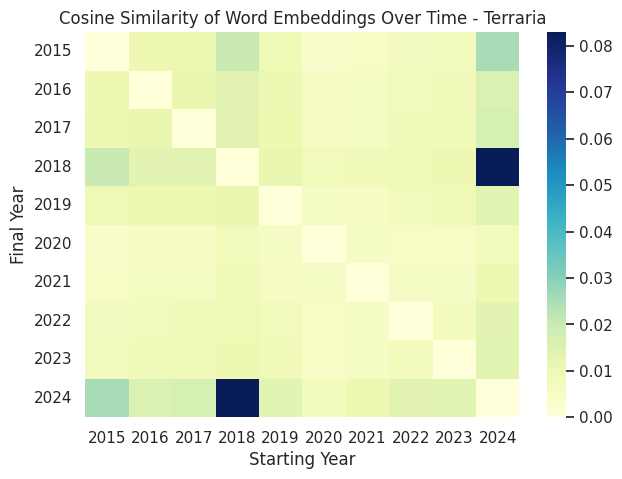

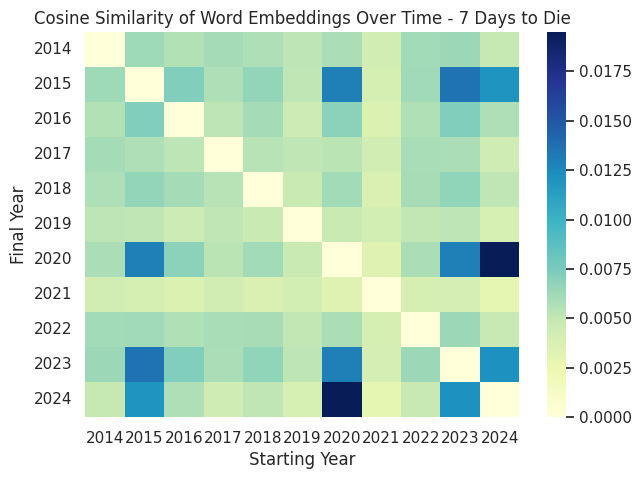

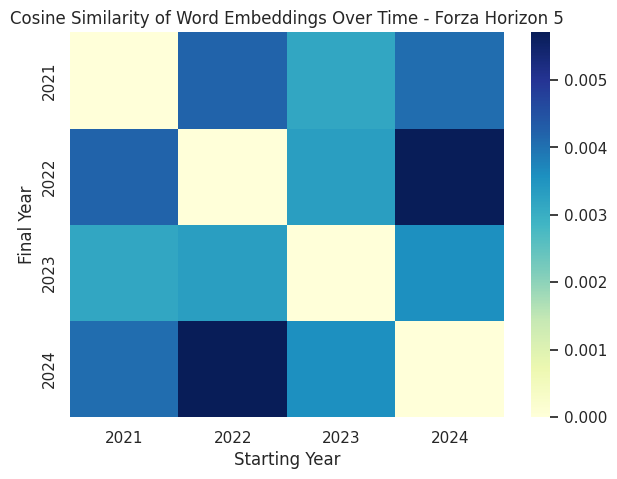

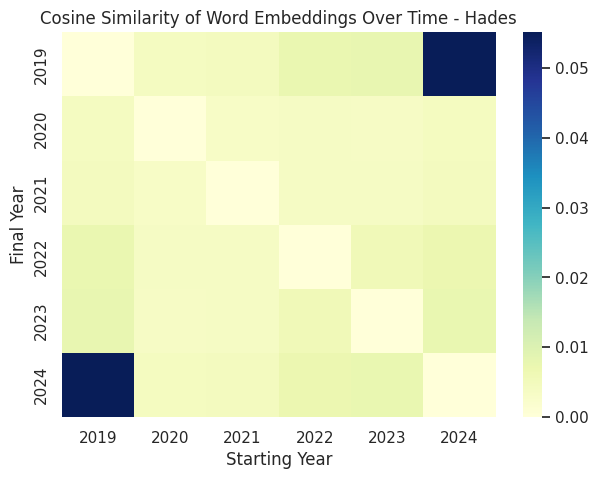

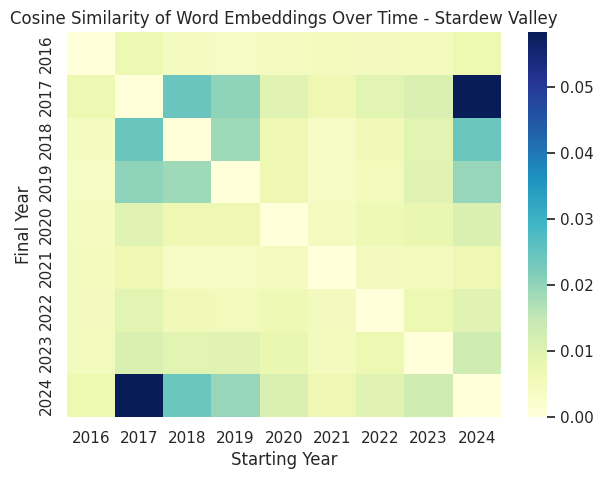

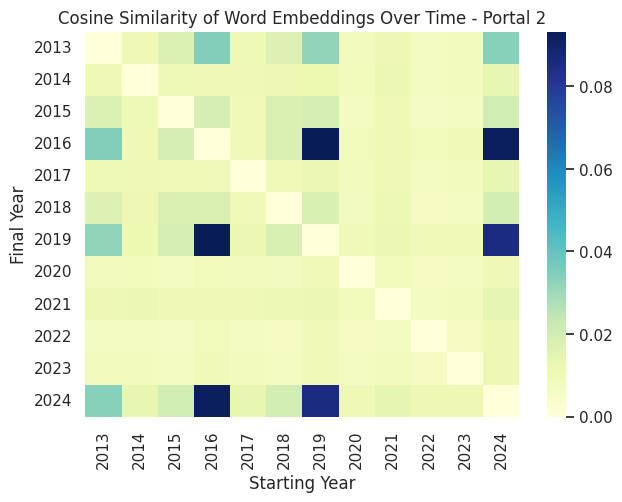

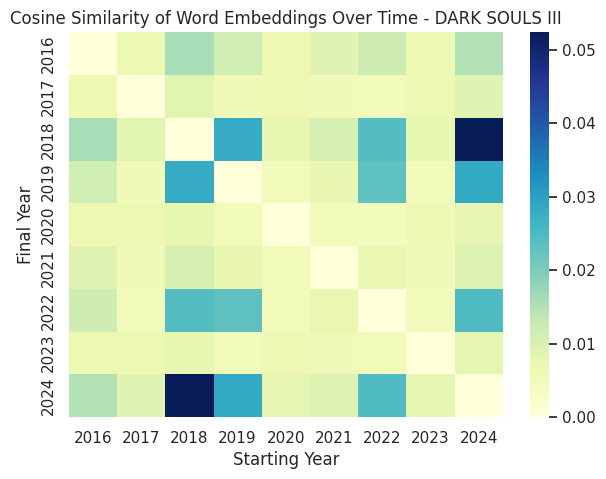

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import gensim
import pandas as pd

# Make "Year"
reviews_df['Year'] = pd.to_datetime(reviews_df['Human_Readable_Date']).dt.year

# List of excluded games
excluded_games = ['Lethal Company', 'Madden NFL 24', 'Palworld', 'Limbus Company', 'TEKKEN 8']

# Iterate over unique GameNames
unique_game_names = reviews_df['GameName'].unique()
for game_name in unique_game_names:
    if game_name in excluded_games:
        continue  # Skip processing for excluded games

    # Filter reviews_df for the current GameName
    game_reviews_df = reviews_df[reviews_df['GameName'] == game_name]

    # Filter out NaN values from the 'Year' column for the current GameName
    valid_years = game_reviews_df['Year'][~np.isnan(game_reviews_df['Year'])]

    # Convert the valid years to integers
    unique_years = np.unique(valid_years).astype(int)

    # Create an empty dictionary to store Word2Vec models for each year
    embeddings_dict = {}

    # Iterate over unique years in the DataFrame for the current GameName
    for year in unique_years:
        # Filter the DataFrame for the current year and remove None values
        year_reviews = game_reviews_df[(game_reviews_df['Year'] == year) & (game_reviews_df['organized_reviews'].notnull())]['organized_reviews'].tolist()

        # Train Word2Vec model for the current year if there are reviews available
        if year_reviews:
            model = gensim.models.Word2Vec(sentences=year_reviews, vector_size=100, window=5, min_count=1, workers=4)
            embeddings_dict[year] = model

    # Create an empty matrix to store cosine similarity values
    num_years = len(embeddings_dict)
    cosine_sim_matrix = np.zeros((num_years, num_years))

    # Compute cosine similarity between embeddings for each pair of years
    for i, (year1, embeddings1) in enumerate(embeddings_dict.items()):
        for j, (year2, embeddings2) in enumerate(embeddings_dict.items()):
            # Compute cosine similarity between embeddings of year1 and year2
            if i != j:  # Exclude diagonal elements
                cosine_sim_matrix[i, j] = cosine_similarity(embeddings1.wv.vectors, embeddings2.wv.vectors).mean()

    # Create a heatmap of cosine similarity for the current GameName
    plt.figure(figsize=(7, 5))
    sns.heatmap(cosine_sim_matrix, annot=False, xticklabels=unique_years, yticklabels=unique_years, fmt=".2f", cmap="YlGnBu")
    plt.xlabel('Starting Year')
    plt.ylabel('Final Year')
    plt.title(f'Cosine Similarity of Word Embeddings Over Time - {game_name}')
    plt.show()

In [ ]:
import pandas as pd

# Assuming 'Human_Readable_Date' is the column containing the date strings
reviews_df['Human_Readable_Date'] = pd.to_datetime(reviews_df['Human_Readable_Date'])

# Extract month names from the date column and create a new 'Month' column
reviews_df['Month'] = reviews_df['Human_Readable_Date'].dt.strftime('%B')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


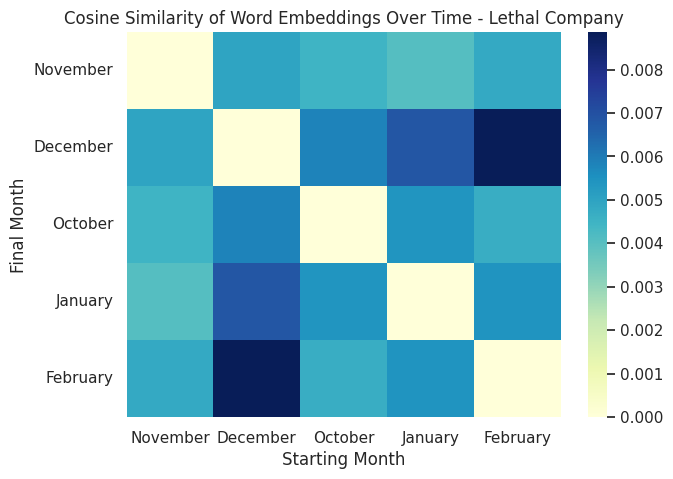

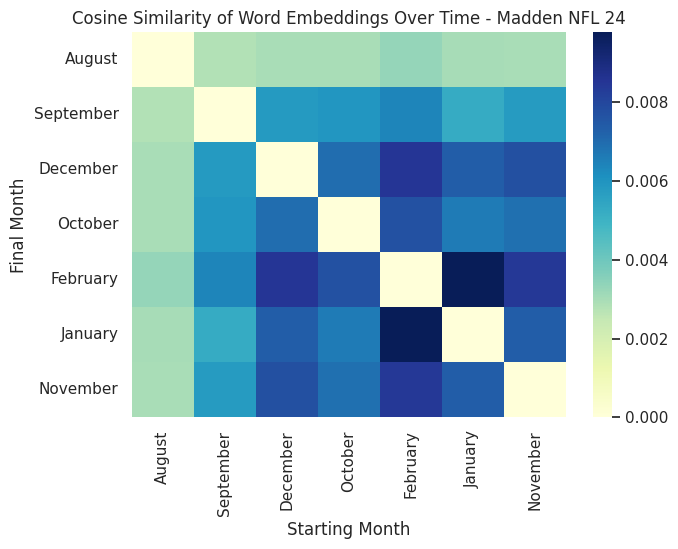

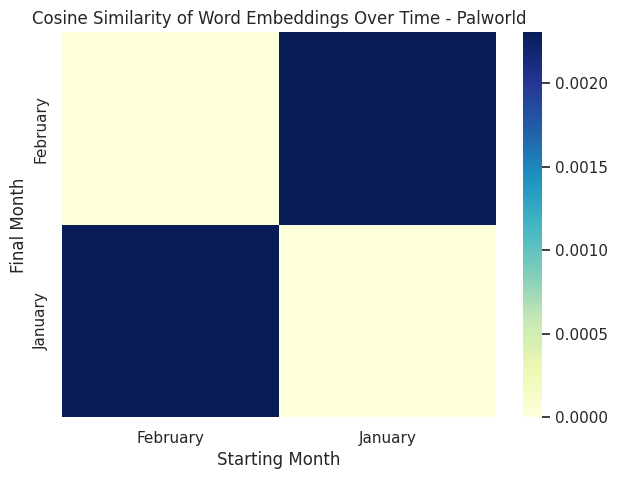

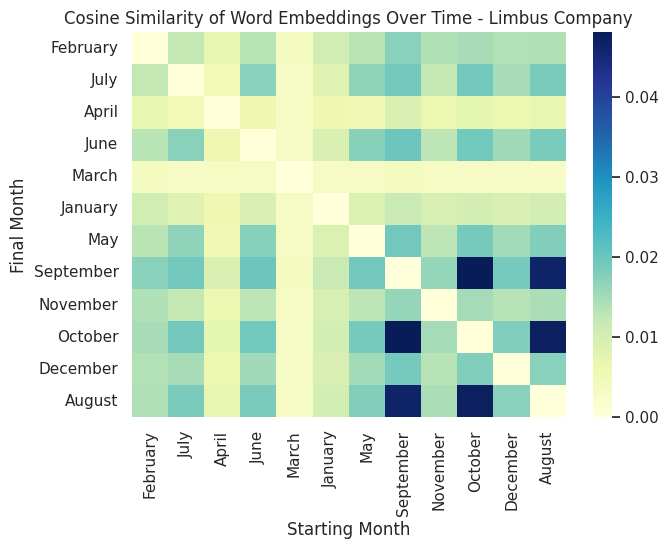

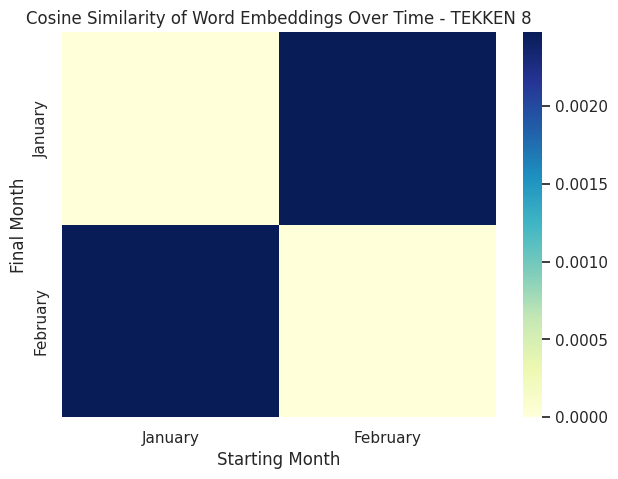

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import gensim

# List of included games
included_games = ['Lethal Company', 'Madden NFL 24', 'Palworld', 'Limbus Company', 'TEKKEN 8']

# Iterate over unique GameNames
unique_game_names = reviews_df['GameName'].unique()
for game_name in unique_game_names:
    if game_name not in included_games:
        continue  # Skip processing for games not included

    # Filter reviews_df for the current GameName
    game_reviews_df = reviews_df[reviews_df['GameName'] == game_name].copy()

    # Create an empty dictionary to store Word2Vec models for each month
    embeddings_dict = {}

    # Extract unique month names for the current game
    unique_months = game_reviews_df['Month'].unique()

    # Iterate over unique months within the range of reviews for the current game
    for month in unique_months:
        # Filter the DataFrame for the current month and remove None values
        month_reviews = game_reviews_df[(game_reviews_df['Month'] == month) & (game_reviews_df['organized_reviews'].notnull())]['organized_reviews'].tolist()

        # Train Word2Vec model for the current month if there are reviews available
        if month_reviews:
            model = gensim.models.Word2Vec(sentences=month_reviews, vector_size=100, window=5, min_count=1, workers=4)
            embeddings_dict[month] = model

    # Create an empty matrix to store cosine similarity values
    num_months = len(embeddings_dict)
    cosine_sim_matrix = np.zeros((num_months, num_months))

    # Compute cosine similarity between embeddings for each pair of months
    for i, (month1, embeddings1) in enumerate(embeddings_dict.items()):
        for j, (month2, embeddings2) in enumerate(embeddings_dict.items()):
            # Compute cosine similarity between embeddings of month1 and month2
            if i != j:  # Exclude diagonal elements
                cosine_sim_matrix[i, j] = cosine_similarity(embeddings1.wv.vectors, embeddings2.wv.vectors).mean()

    # Create a heatmap of cosine similarity for the current GameName
    plt.figure(figsize=(7, 5))
    sns.heatmap(cosine_sim_matrix, annot=False, xticklabels=list(embeddings_dict.keys()), yticklabels=list(embeddings_dict.keys()), fmt=".2f", cmap="YlGnBu")
    plt.xlabel('Starting Month')
    plt.ylabel('Final Month')
    plt.title(f'Cosine Similarity of Word Embeddings Over Time - {game_name}')
    plt.show()

#### PCA

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Convert the 'Reviews' column to string type
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Initialize TfidfVectorizer with max_features set to the desired number
ngTFVectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the reviews to TF-IDF vectors
reviewsTFVects = ngTFVectorizer.fit_transform(reviews_df['Reviews'])

# Apply PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2).fit(reviewsTFVects.toarray())
reduced_data = pca.transform(reviewsTFVects.toarray())

# Define the number of clusters
numClusters = 2

# Train KMeans with the specified number of clusters
km = KMeans(n_clusters=numClusters, init='k-means++')
km.fit(reviewsTFVects)

# Assuming 'km' is the trained KMeans model
cluster_labels = km.labels_

# Add the cluster labels to the DataFrame
reviews_df['kmeans_predictions'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-94-0454e24d0049>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("nipy_spectral")
<ipython-input-94-0454e24d0049>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

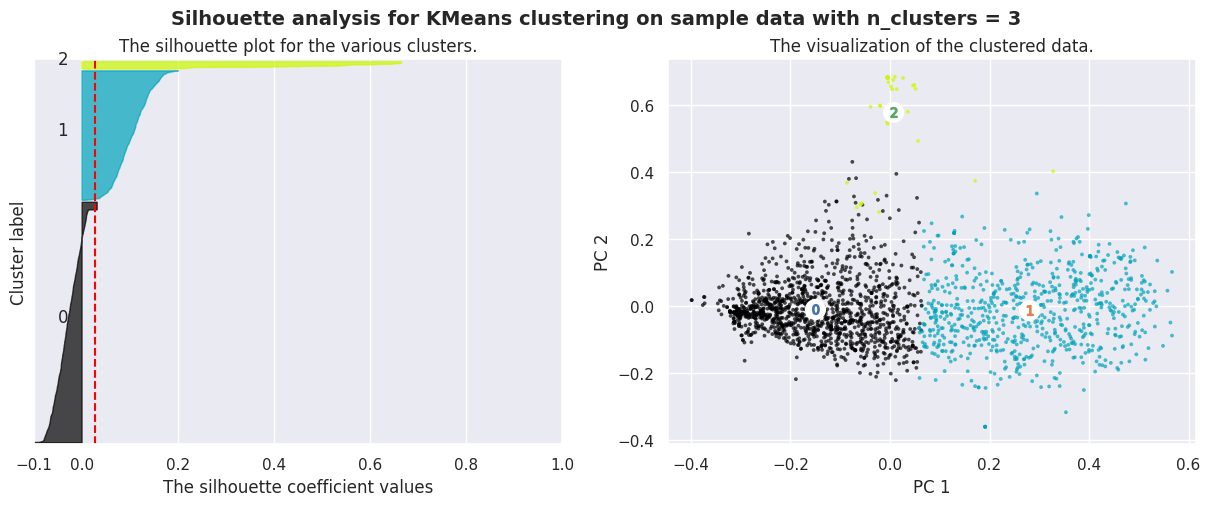

For n_clusters = 3, The average silhouette_score is : 0.027


In [ ]:
import sklearn.cluster
import sklearn.metrics
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

def plotSilhouette(n_clusters, X, reduced_data=None, pca=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.set_xlim([-0.1, 1])
    if issparse(X):
        ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    else:
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the y-axis labels/ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(cluster_labels / n_clusters)  # Updated to use cluster labels directly
    if reduced_data is not None and pca is not None:
        ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        projected_centers = pca.transform(centers)
        # Draw white circles at cluster centers
        ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(projected_centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("PC 1")
        ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

# Assuming 'reviewsTFVects' is your TF-IDF matrix obtained from TfidfVectorizer
# Assuming 'reduced_data' and 'pca' are defined
plotSilhouette(n_clusters=3, X=reviewsTFVects, reduced_data=reduced_data, pca=pca)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-95-b30bd007abb3>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("nipy_spectral")
<ipython-input-95-b30bd007abb3>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matp

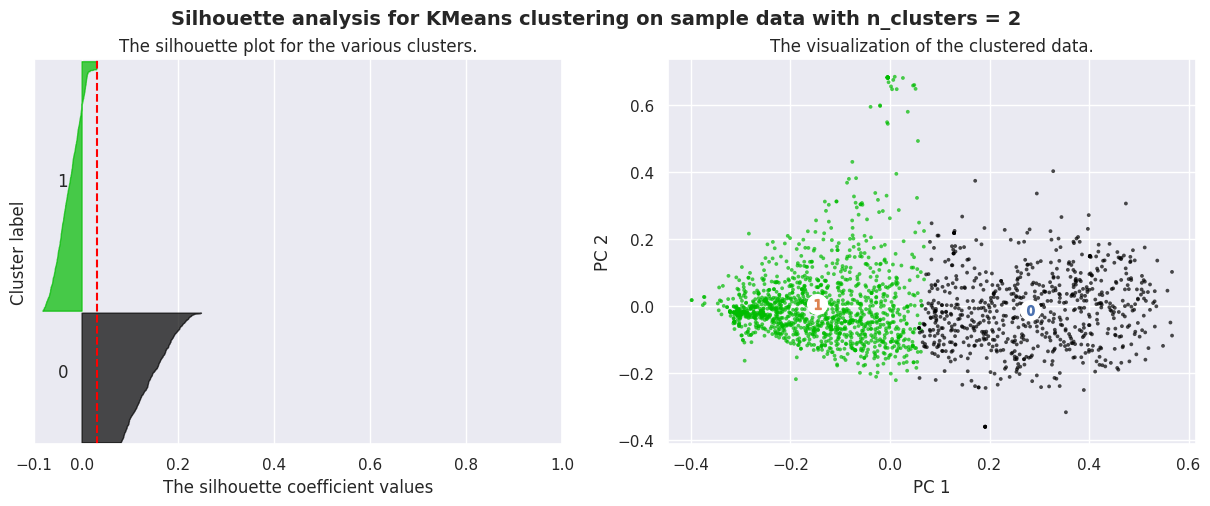

For n_clusters = 2, The average silhouette_score is : 0.033


In [ ]:
import sklearn.cluster
import sklearn.metrics
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

def plotSilhouette(n_clusters, X, reduced_data=None, pca=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.set_xlim([-0.1, 1])
    if issparse(X):
        ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    else:
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the y-axis labels/ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(cluster_labels / n_clusters)  # Updated to use cluster labels directly
    if reduced_data is not None and pca is not None:
        ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        projected_centers = pca.transform(centers)
        # Draw white circles at cluster centers
        ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(projected_centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("PC 1")
        ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

# Assuming 'reviewsTFVects' is your TF-IDF matrix obtained from TfidfVectorizer
# Assuming 'reduced_data' and 'pca' are defined
plotSilhouette(n_clusters=2, X=reviewsTFVects, reduced_data=reduced_data, pca=pca)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


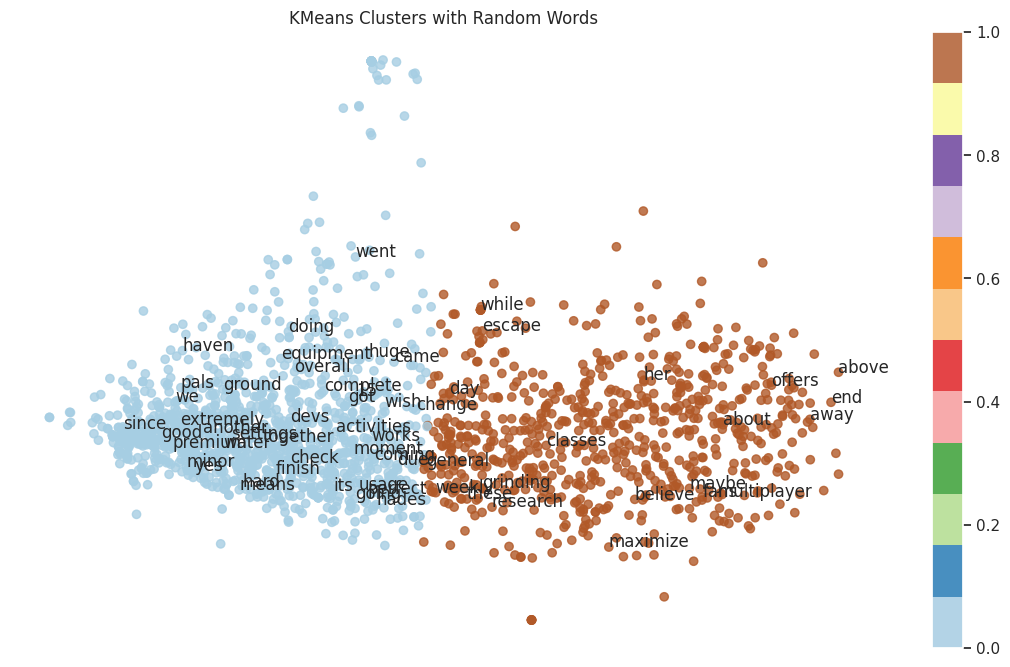

In [ ]:
import random

# Set the seed for reproducibility
random.seed(80)

# Extract feature names from TfidfVectorizer
feature_names = list(ngTFVectorizer.get_feature_names_out())

# Randomly select sixty words
random_words = random.sample(feature_names, 60)

# Assuming 'km' is the trained KMeans model
cluster_labels = km.labels_

# Add the cluster labels to the DataFrame
reviews_df['kmeans_predictions'] = cluster_labels

# Colormap for clusters
colordict = {0: 'red', 1: 'orange', 2: 'green'}  # Update with the appropriate colors

# Scatter plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_frame_on(False)

# Scatter plot with words
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=reviews_df['kmeans_predictions'], alpha=0.8, cmap=plt.cm.Paired)

# Annotate the plot with random words
for i, word in enumerate(random_words):
    ax.annotate(word, (reduced_data[i, 0], reduced_data[i, 1]))

# Add colorbar
plt.colorbar(scatter, ax=ax)

plt.xticks(())
plt.yticks(())
plt.title('KMeans Clusters with Random Words')
plt.show()

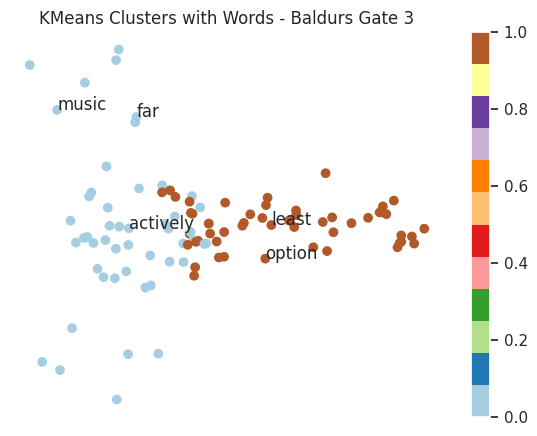

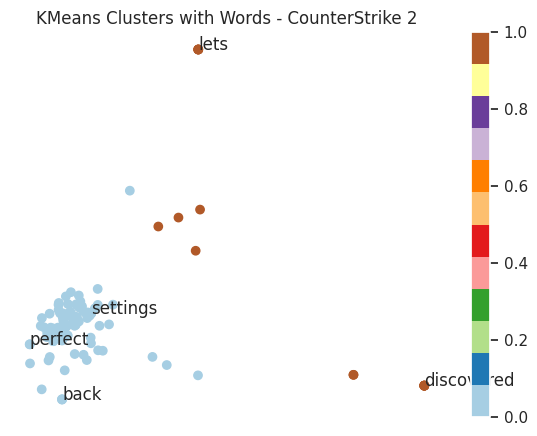

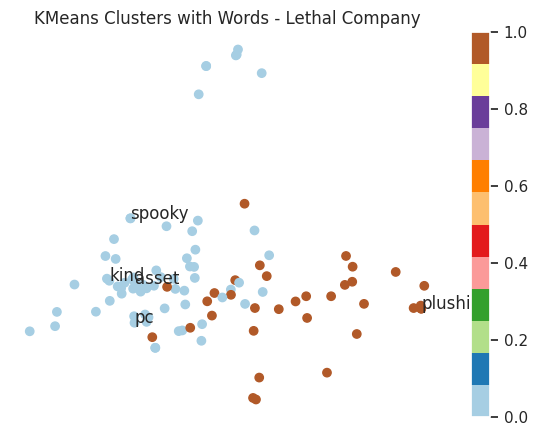

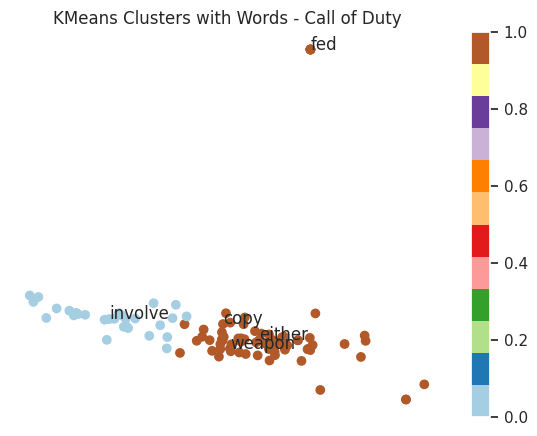

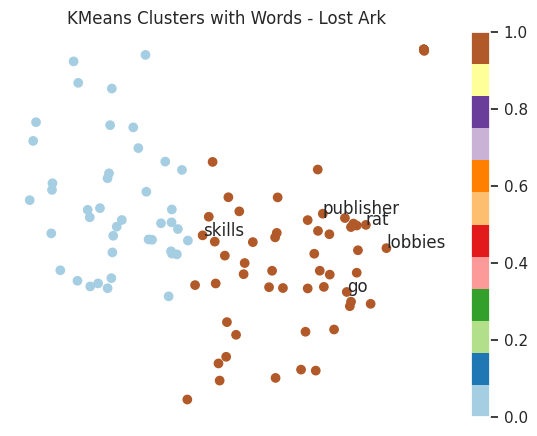

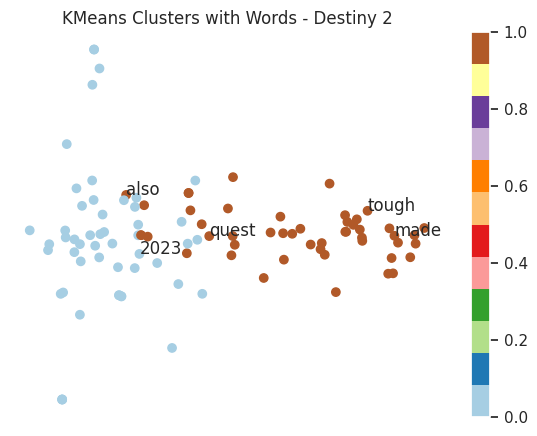

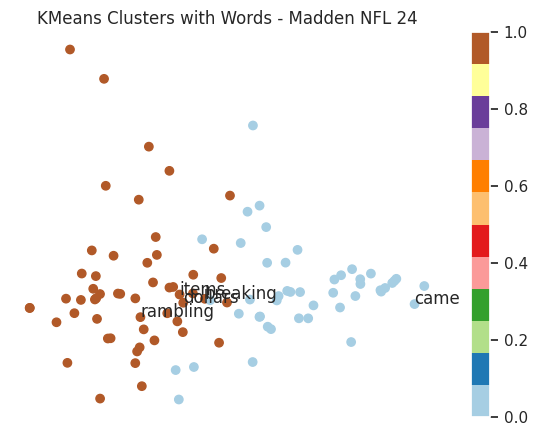

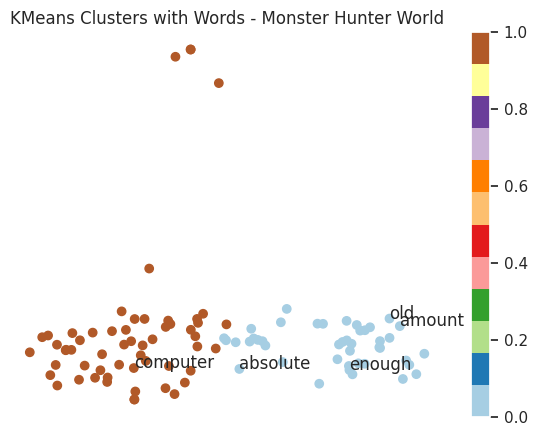

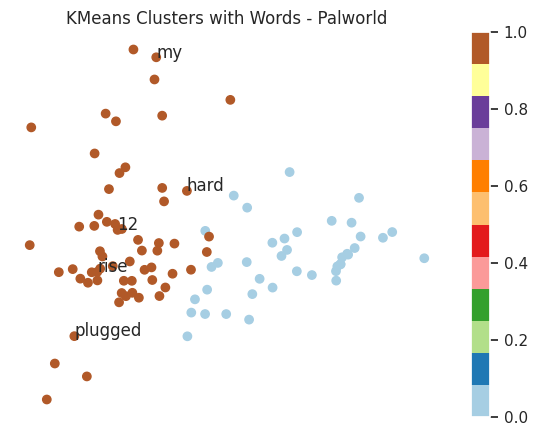

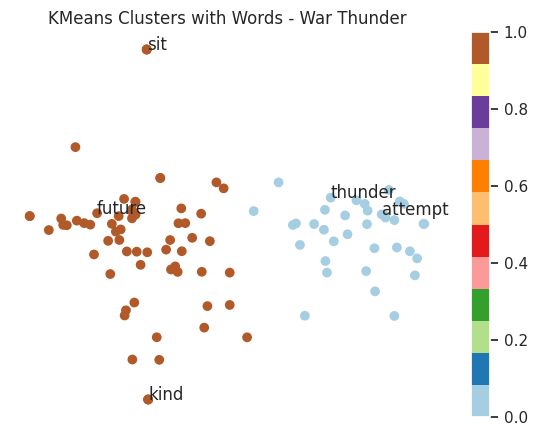

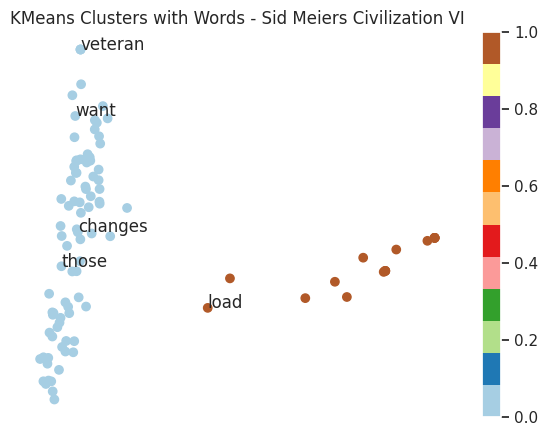

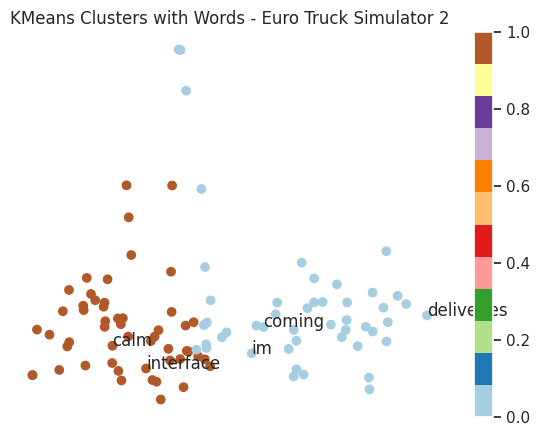

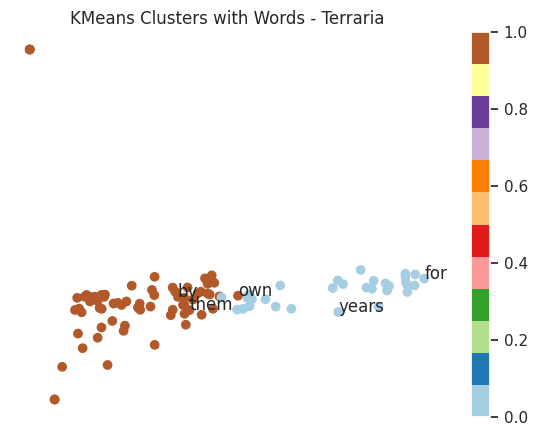

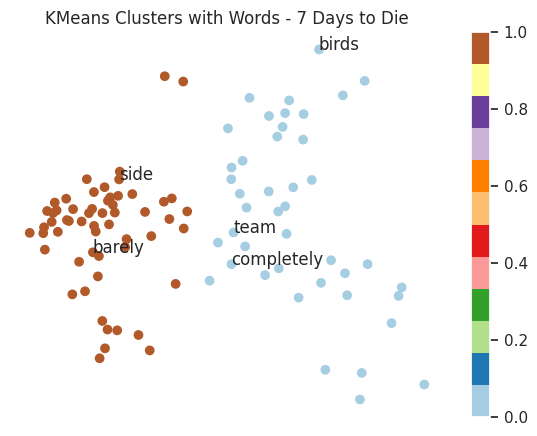

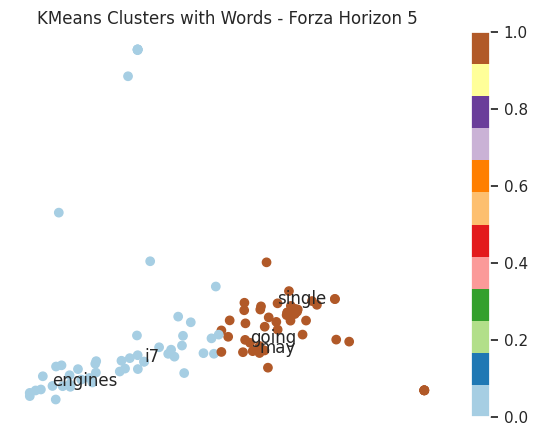

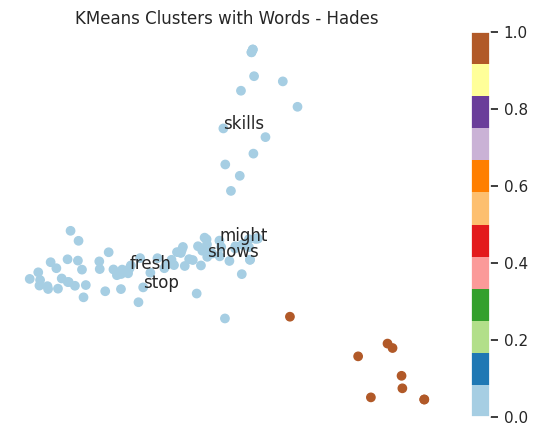

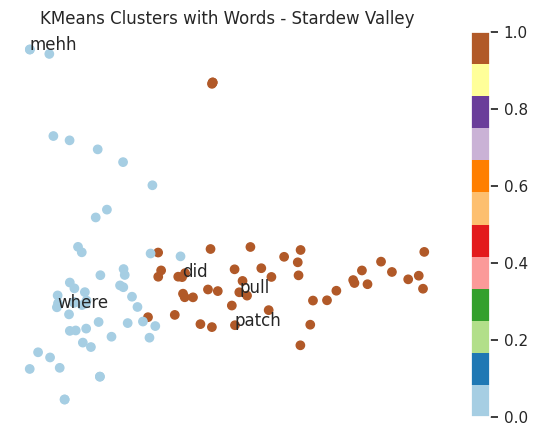

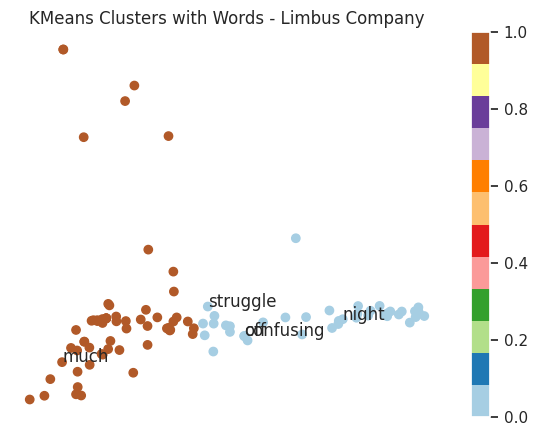

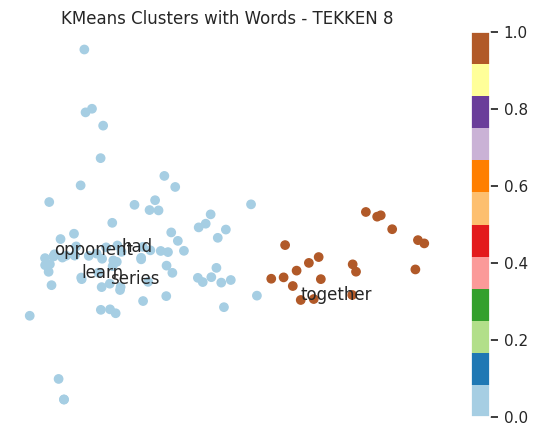

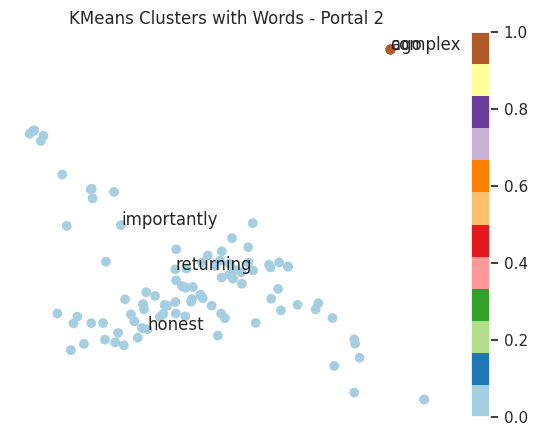

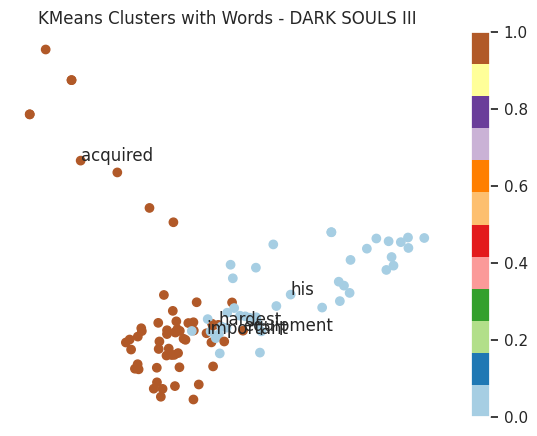

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import warnings

# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Initialize TfidfVectorizer with max_features set to the desired number
ngTFVectorizer = TfidfVectorizer(max_features=1000)

# Define the number of clusters
numClusters = 2

# Iterate over unique GameName values
unique_game_names = reviews_df['GameName'].unique()
for game_name in unique_game_names:
    # Subset the DataFrame by GameName
    game_reviews_df = reviews_df[reviews_df['GameName'] == game_name].copy()

    # Convert the 'Reviews' column to string type
    game_reviews_df['Reviews'] = game_reviews_df['Reviews'].astype(str)

    # Fit and transform the reviews to TF-IDF vectors
    reviewsTFVects = ngTFVectorizer.fit_transform(game_reviews_df['Reviews'])

    # Apply PCA to reduce the dimensionality to 2 components
    pca = PCA(n_components=2).fit(reviewsTFVects.toarray())
    reduced_data = pca.transform(reviewsTFVects.toarray())

    # Train KMeans with the specified number of clusters
    km = KMeans(n_clusters=numClusters, init='k-means++', n_init=10)
    km.fit(reviewsTFVects)

    # Assuming 'km' is the trained KMeans model
    cluster_labels = km.labels_

    # Add the cluster labels to the DataFrame
    game_reviews_df['kmeans_predictions'] = cluster_labels

    # Colormap for clusters
    colordict = {0: 'red', 1: 'orange', 2: 'green'}  # Update with the appropriate colors

    # Convert feature names to a list
    feature_names = list(ngTFVectorizer.get_feature_names_out())

    # Randomly select thirty words from feature names
    random_words = random.sample(feature_names, 5)

    # Scatter plot with words
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)

    # Use 'c' parameter instead of 'color', and pass the cluster labels directly
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=game_reviews_df['kmeans_predictions'], cmap=plt.cm.Paired)

    # Annotate the plot with words
    for i, word in enumerate(random_words):
        ax.annotate(word, (reduced_data[i, 0], reduced_data[i, 1]))

    # Add colorbar
    plt.colorbar(scatter, ax=ax)

    plt.xticks(())
    plt.yticks(())
    plt.title(f'KMeans Clusters with Words - {game_name}')
    plt.show()

#### Review length

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-98-14a8f542f1a9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df.loc[:, 'Review_Length'] = reviews_df['Reviews'].apply(len)


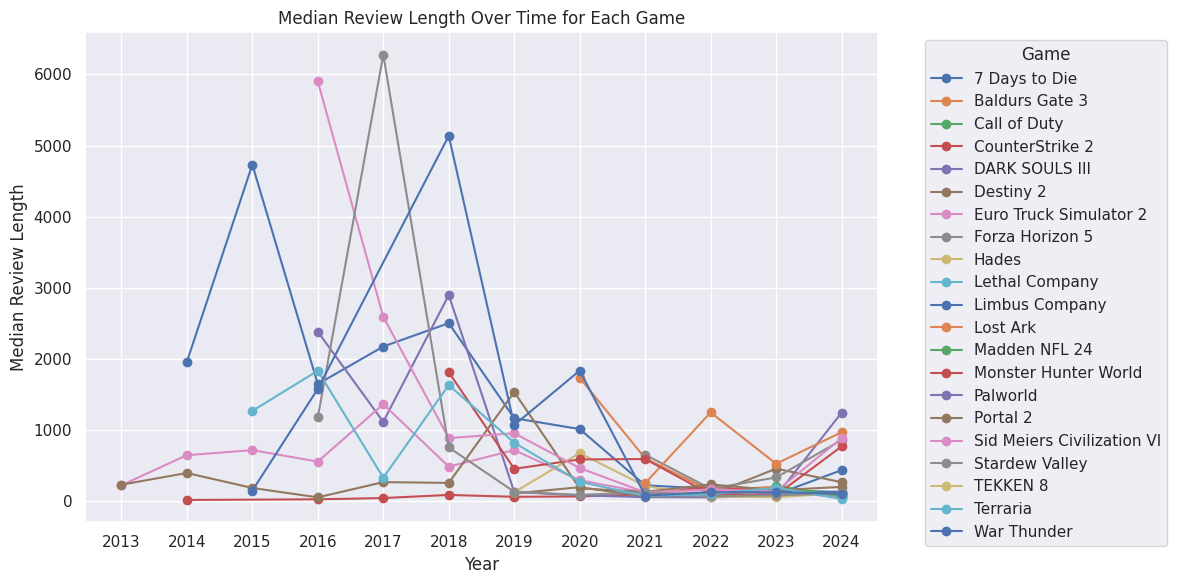

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with NaN values in the 'Year' column
reviews_df = reviews_df.dropna(subset=['Year'])

# Create a new column for the length of each review using .loc to avoid the warning
reviews_df.loc[:, 'Review_Length'] = reviews_df['Reviews'].apply(len)

# Plot the median review length over time for each game
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

for game, data in reviews_df.groupby('GameName'):
    median_review_length = data.groupby('Year')['Review_Length'].median()
    plt.plot(median_review_length.index, median_review_length.values, marker='o', label=game)

plt.xlabel('Year')
plt.ylabel('Median Review Length')
plt.title('Median Review Length Over Time for Each Game')
plt.legend(title='Game', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the x-axis ticks to display every year
plt.xticks(sorted(reviews_df['Year'].unique()))

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import statsmodels.api as sm

# Drop rows with NaN values in the 'Year' column
reviews_df = reviews_df.dropna(subset=['Year'])

# Group by year and calculate the median review length
median_review_length = reviews_df.groupby('Year')['Review_Length'].median()

# Prepare the data for regression analysis
X = sm.add_constant(median_review_length.index)  # Add a constant for the intercept
y = median_review_length.values

# Take the natural logarithm of the response variable
y_log = np.log(y)

# Fit the logarithmic regression model
model = sm.OLS(y_log, X)
results = model.fit()

# Print the summary of the regression analysis
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     9.703
Date:                Tue, 05 Mar 2024   Prob (F-statistic):             0.0110
Time:                        22:50:18   Log-Likelihood:                -12.438
No. Observations:                  12   AIC:                             28.88
Df Residuals:                      10   BIC:                             29.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        398.8398    126.139      3.162      0.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


**Review length goes down over time**

#### Parse depth

In [ ]:
import spacy
import numpy as np
from collections import defaultdict

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Create a dictionary to store complexity measures for each game
game_complexity = defaultdict(list)

# Iterate through unique game names
for game_name in reviews_df['GameName'].unique():
    # Filter reviews for the current game
    game_reviews = reviews_df[reviews_df['GameName'] == game_name]

    # Randomly select five reviews for the game
    selected_reviews = game_reviews.sample(n=50)['Reviews']

    # Calculate complexity measures for each selected review
    for review_text in selected_reviews:
        # Parse the review text
        doc = nlp(review_text)

        # Calculate complexity measures
        num_nodes = len(list(doc))
        depth = max([token.i - token.head.i for token in doc]) + 1

        # Store complexity measures for the game
        game_complexity[game_name].append({
            'num_nodes': num_nodes,
            'depth': depth
        })

# Calculate average complexity measures for each game
average_complexity = {}
for game_name, complexity_list in game_complexity.items():
    avg_num_nodes = np.mean([c['num_nodes'] for c in complexity_list])
    avg_depth = np.mean([c['depth'] for c in complexity_list])
    complexity_total = avg_num_nodes * avg_depth

    average_complexity[game_name] = {
        'avg_num_nodes': avg_num_nodes,
        'avg_depth': avg_depth,
        'complexity_total': complexity_total
    }

# Print average complexity measures for each game
for game_name, complexity in average_complexity.items():
    print(f"Game: {game_name}")
    print(f"Average Number of Nodes: {complexity['avg_num_nodes']}")
    print(f"Average Depth: {complexity['avg_depth']}")
    print(f"Complexity Total: {complexity['complexity_total']}")
    print()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Game: Baldurs Gate 3
Average Number of Nodes: 197.5
Average Depth: 20.0
Complexity Total: 3950.0

Game: CounterStrike 2
Average Number of Nodes: 66.64
Average Depth: 14.12
Complexity Total: 940.9567999999999

Game: Lethal Company
Average Number of Nodes: 140.7
Average Depth: 17.96
Complexity Total: 2526.9719999999998

Game: Call of Duty
Average Number of Nodes: 170.32
Average Depth: 36.0
Complexity Total: 6131.5199999999995

Game: Lost Ark
Average Number of Nodes: 431.74
Average Depth: 31.56
Complexity Total: 13625.714399999999

Game: Destiny 2
Average Number of Nodes: 162.64
Average Depth: 18.5
Complexity Total: 3008.8399999999997

Game: Madden NFL 24
Average Number of Nodes: 102.18
Average Depth: 18.12
Complexity Total: 1851.5016000000003

Game: Monster Hunter World
Average Number of Nodes: 245.34
Average Depth: 19.78
Complexity Total: 4852.8252

Game: Palworld
Average Number of Nodes: 120.8
Average Depth: 19.94
Complexity Total: 2408.752

Game: War Thunder
Average Number of Nodes: 3

#### Sentiment

In [ ]:
import warnings
import importlib

# Filter out ImportWarnings related to missing import hooks
warnings.filterwarnings("ignore", category=ImportWarning)

# Import the modules that are causing the warnings
try:
    import _PyDrive2ImportHook
    import _PyDriveImportHook
    import _GenerativeAIImportHook
    import _OpenCVImportHook
    import APICoreClientInfoImportHook
    import _BokehImportHook
    import _AltairImportHook
except ImportError:
    pass

# Reset the warning filters after importing the modules
warnings.resetwarnings()

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import nltk
nltk.download('vader_lexicon')

# Convert the 'Reviews' column to strings
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review and group by 'GameName'
game_sentiments = reviews_df.groupby('GameName').apply(lambda x: pd.Series({
    'MeanSentiment': x['Reviews'].apply(lambda review: sid.polarity_scores(review)['compound']).mean()
})).reset_index()

# Display the aggregated sentiment scores for each game
print(game_sentiments)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                      GameName  MeanSentiment
0                7 Days to Die       0.351616
1               Baldurs Gate 3       0.469561
2                 Call of Duty      -0.039398
3              CounterStrike 2       0.098874
4               DARK SOULS III       0.211608
5                    Destiny 2       0.292751
6       Euro Truck Simulator 2       0.523797
7              Forza Horizon 5       0.403551
8                        Hades       0.423780
9               Lethal Company       0.152211
10              Limbus Company       0.291602
11                    Lost Ark       0.097376
12               Madden NFL 24      -0.044700
13        Monster Hunter World       0.397592
14                    Palworld       0.254727
15                    Portal 2       0.580103
16  Sid Meiers Civilization VI       0.224059
17              Stardew Valley       0.370836
18                    TEKKEN 8       0.345934
19                    Terraria       0.398430
20                 War Thunder    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


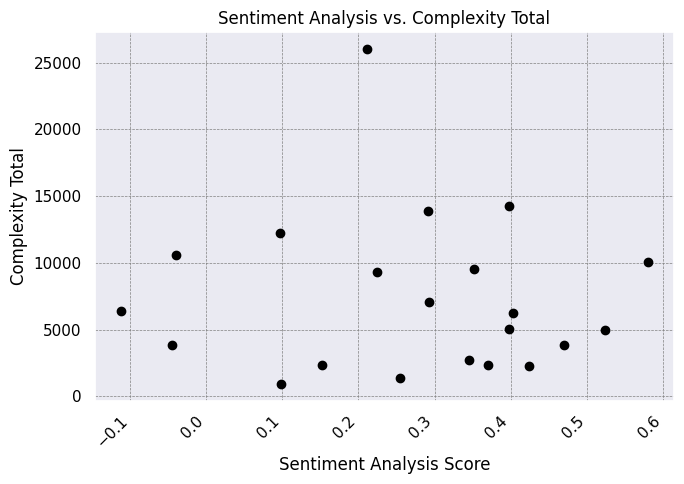

In [ ]:
import matplotlib.pyplot as plt

# Define the Y-variable complexity values
y_variable = {
    'Baldurs Gate 3': 3860.964,
    'CounterStrike 2': 944.4276,
    'Lethal Company': 2341.248,
    'Call of Duty': 10606.584,
    'Lost Ark': 12242.6576,
    'Destiny 2': 7062.5664,
    'Madden NFL 24': 3863.086,
    'Monster Hunter World': 5073.952,
    'Palworld': 1388.6688,
    'War Thunder': 6430.118,
    'Sid Meiers Civilization VI': 9318.6876,
    'Euro Truck Simulator 2': 4941.2888,
    'Terraria': 14226.138,
    '7 Days to Die': 9512.048,
    'Forza Horizon 5': 6258.5016,
    'Hades': 2293.55,
    'Stardew Valley': 2390.7208,
    'Limbus Company': 13886.994,
    'TEKKEN 8': 2707.656,
    'Portal 2': 10100.1176,
    'DARK SOULS III': 26009.9088
}

# Define the X-variable sentiment values
x_variable = {
    '7 Days to Die': 0.351616,
    'Baldurs Gate 3': 0.469561,
    'Call of Duty': -0.039398,
    'CounterStrike 2': 0.098874,
    'DARK SOULS III': 0.211608,
    'Destiny 2': 0.292751,
    'Euro Truck Simulator 2': 0.523797,
    'Forza Horizon 5': 0.403551,
    'Hades': 0.423780,
    'Lethal Company': 0.152211,
    'Limbus Company': 0.291602,
    'Lost Ark': 0.097376,
    'Madden NFL 24': -0.044700,
    'Monster Hunter World': 0.397592,
    'Palworld': 0.254727,
    'Portal 2': 0.580103,
    'Sid Meiers Civilization VI': 0.224059,
    'Stardew Valley': 0.370836,
    'TEKKEN 8': 0.345934,
    'Terraria': 0.398430,
    'War Thunder': -0.111764
}

# Convert dictionaries to lists for plotting
games = list(x_variable.keys())
sentiments = list(x_variable.values())
complexity = [y_variable[game] for game in games]

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(sentiments, complexity, color='black')  # Change the color to black for black and white theme
plt.title('Sentiment Analysis vs. Complexity Total', color='black')  # Set title color to black
plt.xlabel('Sentiment Analysis Score', color='black')  # Set x-label color to black
plt.ylabel('Complexity Total', color='black')  # Set y-label color to black
plt.xticks(rotation=45, ha='right', color='black')  # Rotate x-axis labels for better readability
plt.yticks(color='black')  # Set y-tick labels color to black
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add gray dashed grid lines
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
<ipython-input-104-d98aed6f9407>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)


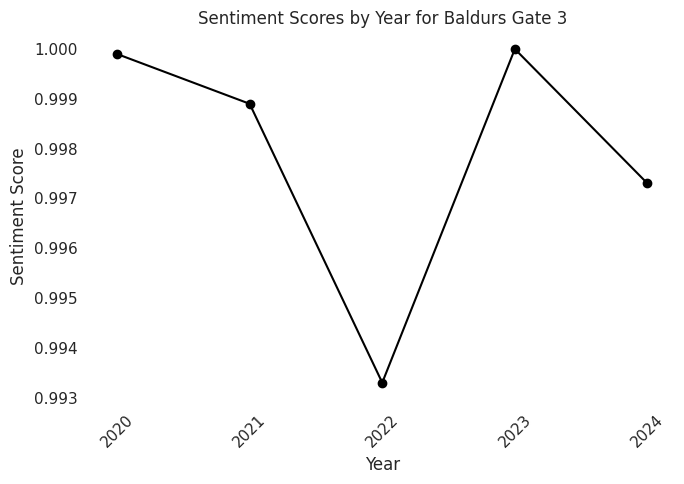

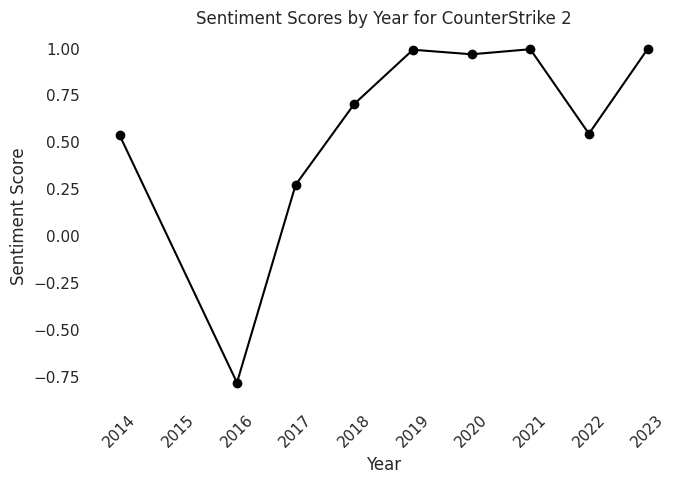

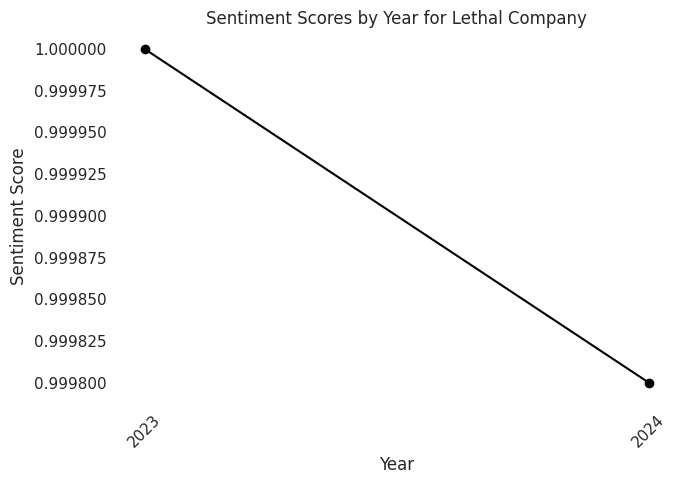

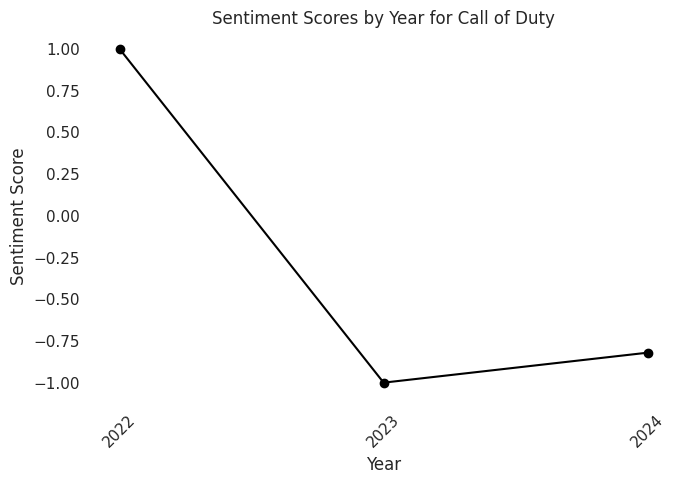

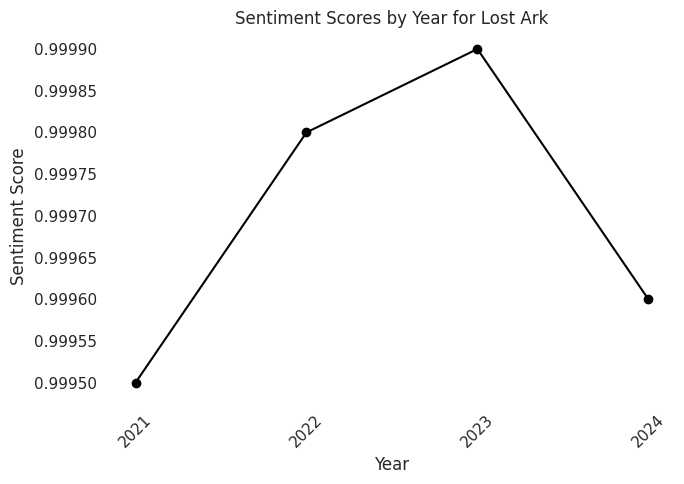

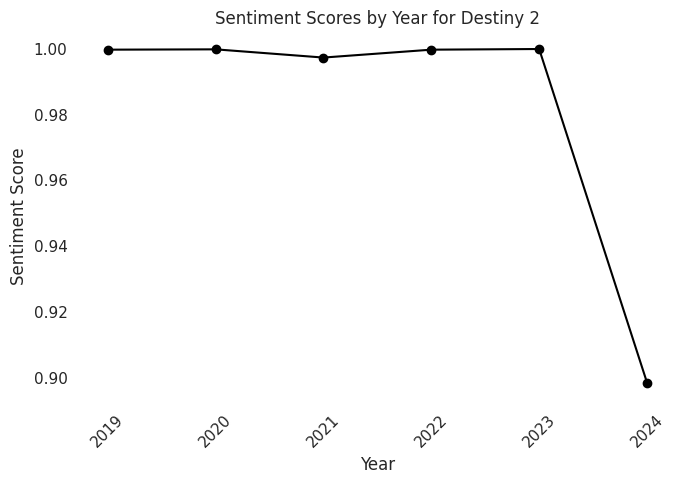

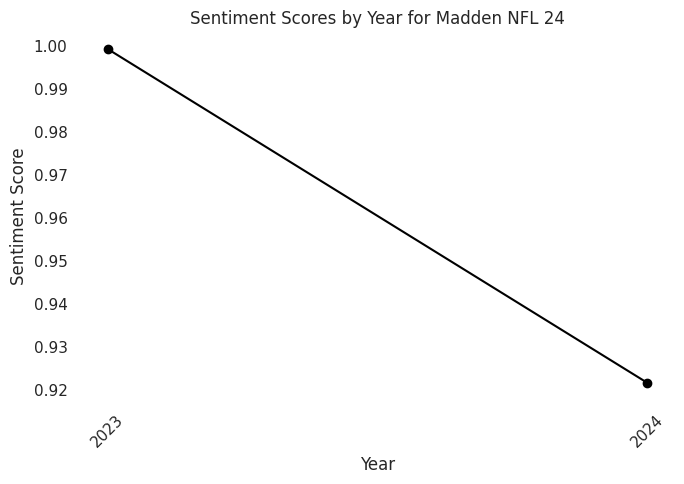

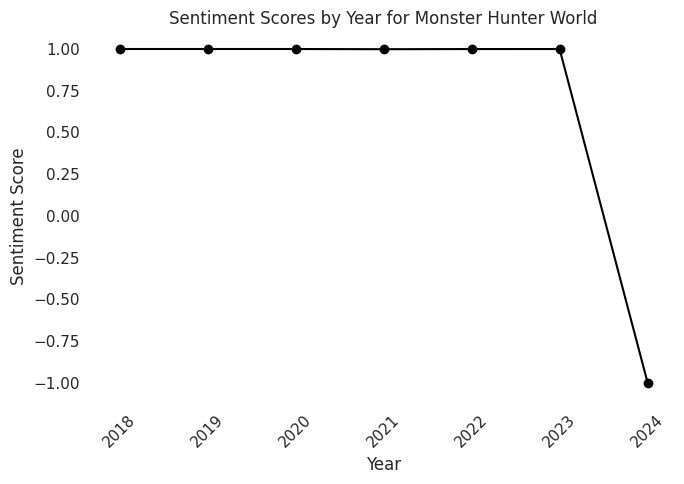

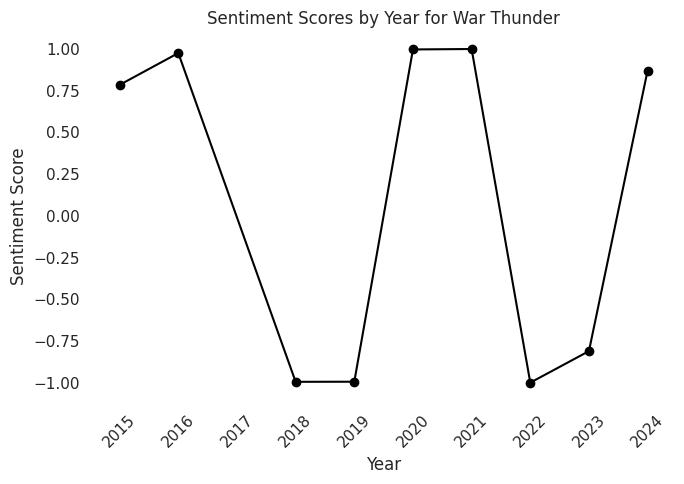

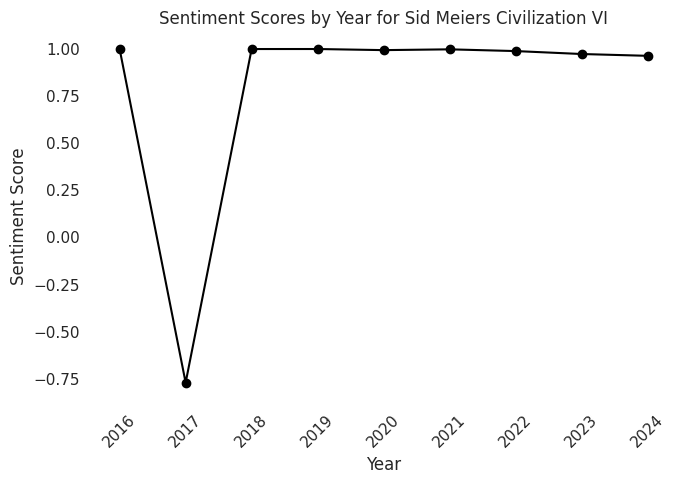

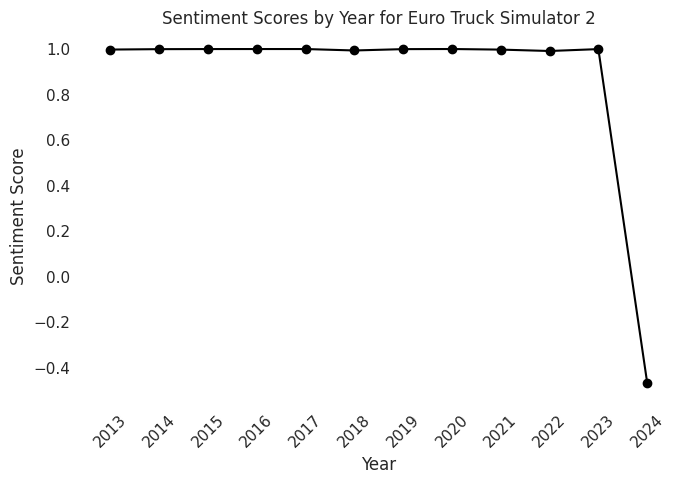

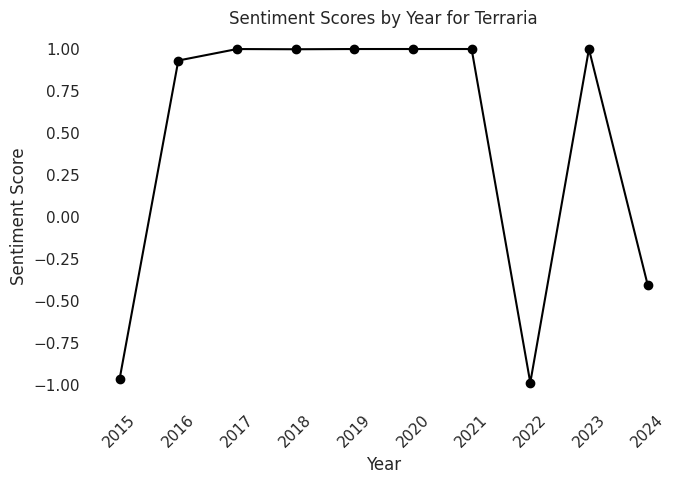

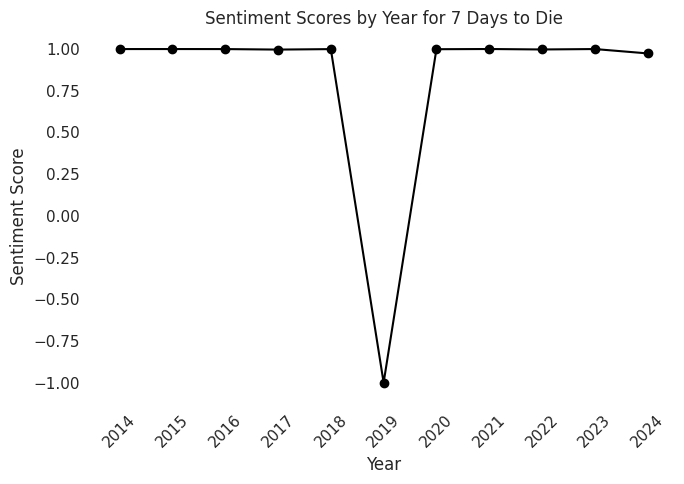

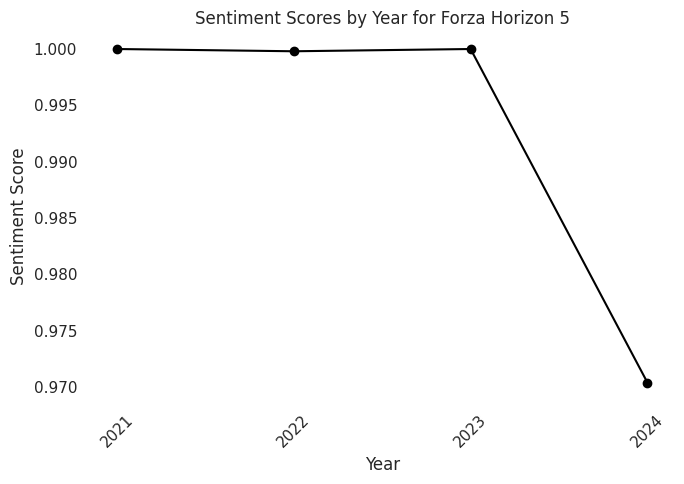

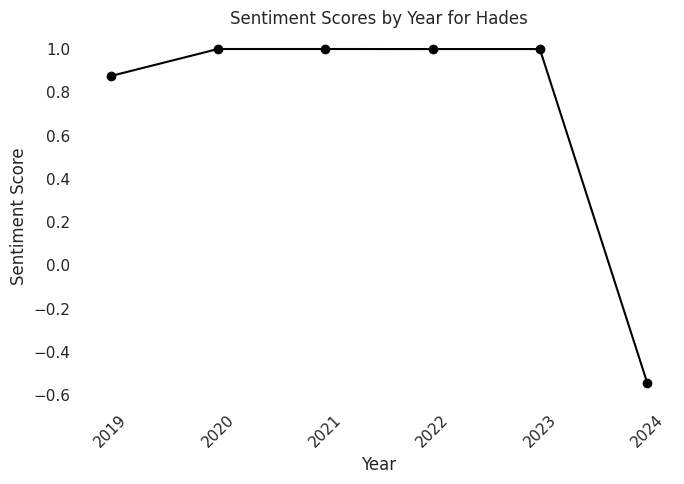

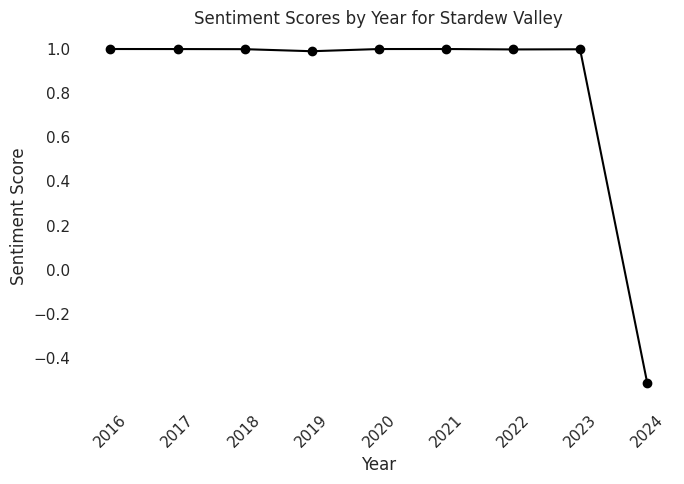

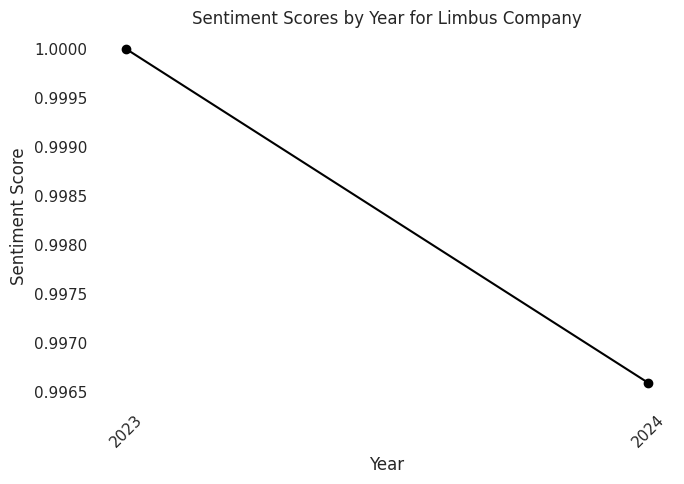

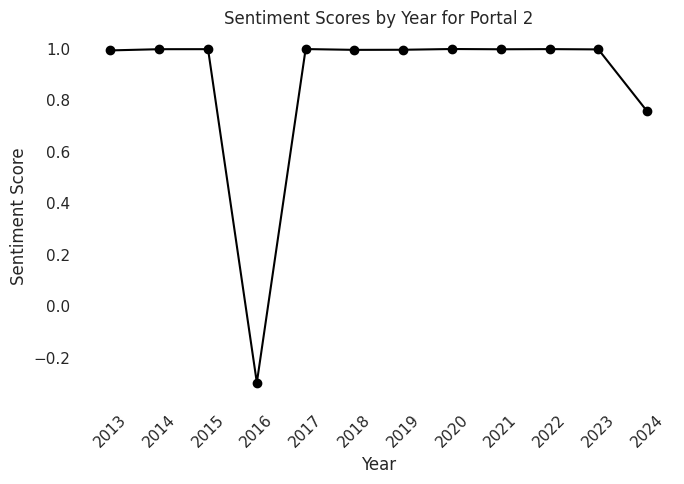

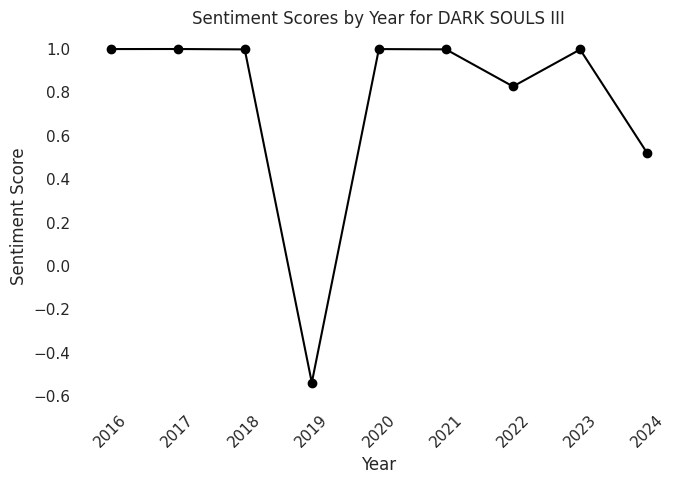

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer

# Exclude TEKKEN 8 and Palworld from the DataFrame
reviews_df = reviews_df[~reviews_df['GameName'].isin(['TEKKEN 8', 'Palworld'])]

# Convert the 'Reviews' column to strings
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review and group by 'GameName' and 'Year'
game_sentiments_by_year = reviews_df.groupby(['GameName', 'Year'])['Reviews'].apply(lambda x: sid.polarity_scores(' '.join(x))['compound']).reset_index()

# Iterate over unique game names and create separate graphs for each game
for game_name in reviews_df['GameName'].unique():
    # Filter sentiment scores for the current game
    game_sentiments = game_sentiments_by_year[game_sentiments_by_year['GameName'] == game_name]

    # Check if there are sentiment scores for the current game
    if not game_sentiments.empty:
        # Find the minimum and maximum year for the current game
        min_year = game_sentiments['Year'].min()
        max_year = game_sentiments['Year'].max()

        # Generate x-axis labels from the minimum to maximum year, incrementing by one
        x_labels = list(range(int(min_year), int(max_year) + 1))

        # Plot sentiment scores by year for the current game
        plt.figure(figsize=(7, 5))
        plt.plot(game_sentiments['Year'], game_sentiments['Reviews'], marker='o', linestyle='-', color='black')
        plt.title(f'Sentiment Scores by Year for {game_name}')
        plt.xlabel('Year')
        plt.ylabel('Sentiment Score')
        plt.grid(True)
        plt.xticks(x_labels, rotation=45)
        plt.gca().set_facecolor('white')  # Set background color to white
        plt.tight_layout()
        plt.show()
    else:
        print(f"No sentiment scores available for {game_name}")

#### Genres

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


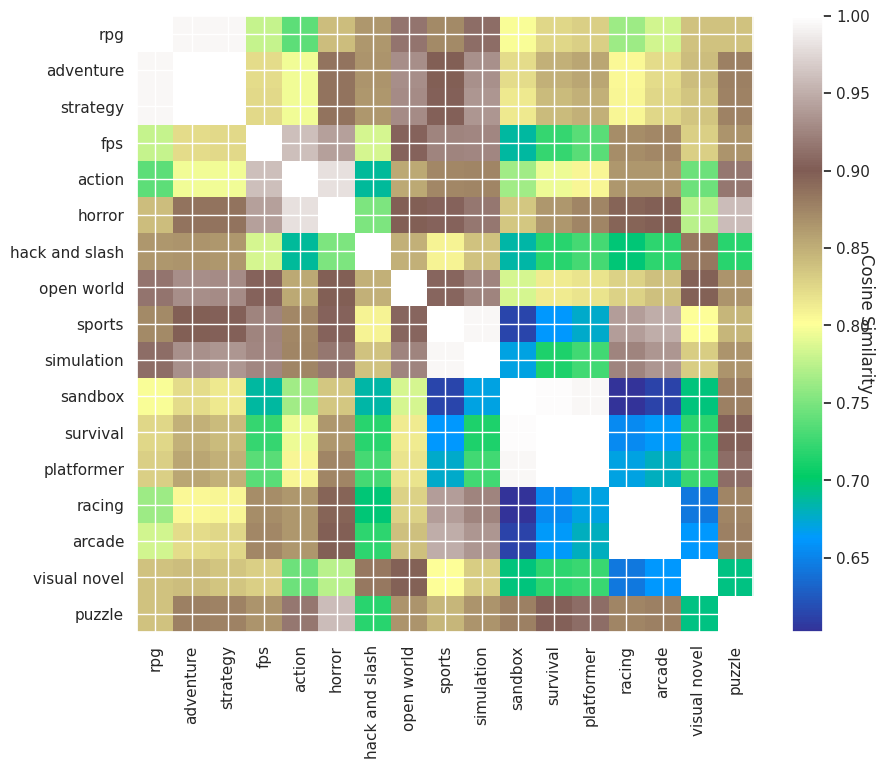

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Initialize an empty dictionary to store aggregated reviews for each genre
genre_reviews_dict = {}

# Iterate through each row in the DataFrame
for index, row in reviews_df.iterrows():
    # Get the game name and corresponding genres
    game_name = row['GameName']
    genres = row['genre']
    reviews = row['Reviews']

    # Iterate through each genre
    for genre in genres:
        # Check if the genre already exists in the dictionary
        if genre.lower() in genre_reviews_dict:
            # Append the reviews to the existing genre entry
            genre_reviews_dict[genre.lower()] += reviews
        else:
            # Create a new entry for the genre
            genre_reviews_dict[genre.lower()] = reviews

# Convert the dictionary to a list of TaggedDocuments for Doc2Vec
tagged_data = [TaggedDocument(words=reviews.split(), tags=[genre]) for genre, reviews in genre_reviews_dict.items()]

# Train Doc2Vec model
d2v_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4)

# Get the number of genres
num_genres = len(genre_reviews_dict)

# Initialize an empty heatmap matrix
heatmapMatrix = np.zeros((num_genres, num_genres))

# Compute cosine similarity between document vectors for each pair of genres
for i, (genre1, reviews1) in enumerate(genre_reviews_dict.items()):
    for j, (genre2, reviews2) in enumerate(genre_reviews_dict.items()):
        # Compute cosine similarity between document vectors for genres i and j
        similarity = cosine_similarity(
            [d2v_model.dv[i]],
            [d2v_model.dv[j]]
        )[0][0]
        heatmapMatrix[i][j] = similarity

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
hmap = ax.imshow(heatmapMatrix, cmap='terrain', interpolation='nearest')

# Add color bar
cbar = plt.colorbar(hmap)
cbar.set_label('Cosine Similarity', rotation=270)

# Set labels using genre names
genre_names = list(genre_reviews_dict.keys())
ax.set_xticks(np.arange(num_genres))
ax.set_yticks(np.arange(num_genres))
ax.set_xticklabels(genre_names, rotation=90)
ax.set_yticklabels(genre_names)

plt.show()

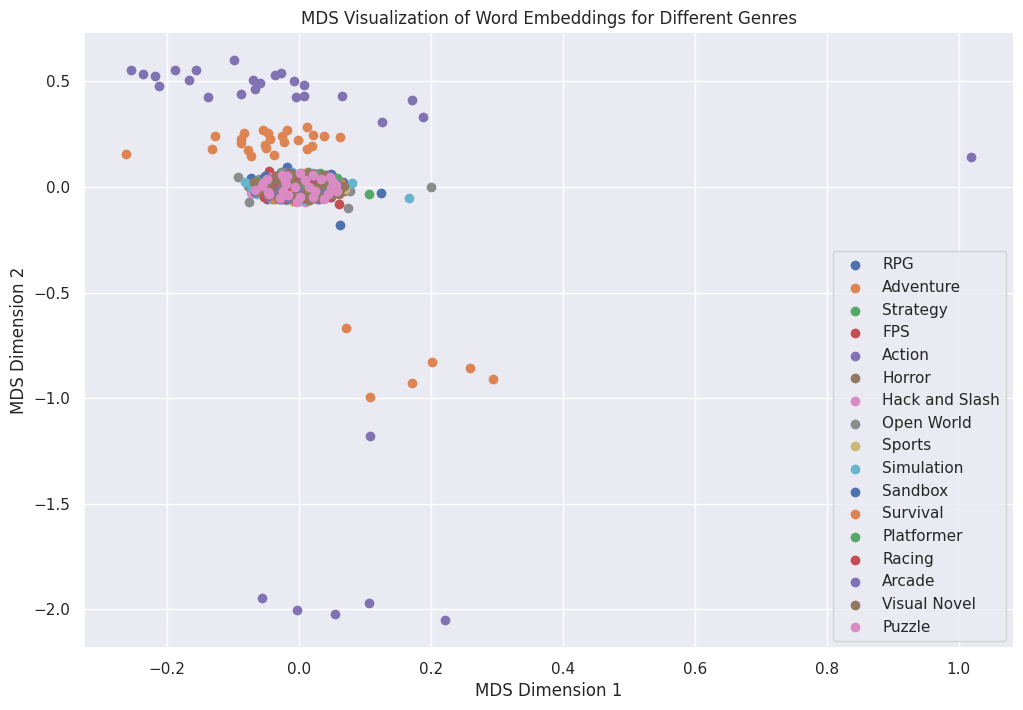

In [ ]:
import gensim
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import warnings

# Suppress warnings for this cell
warnings.filterwarnings('ignore')

# Define a list of unique genres
unique_genres = reviews_df['genre'].explode().unique()

# Create a figure and axis object for the plot
plt.figure(figsize=(12, 8))

# Iterate over each genre
for genre in unique_genres:
    # Filter the DataFrame for the current genre
    filtered_reviews_df = reviews_df[reviews_df['genre'].apply(lambda x: genre in x)]

    # Ensure each item in 'organized_reviews' is a list of words
    normalized_sentences = filtered_reviews_df['organized_reviews'].tolist()

    # Remove None values from normalized_sentences
    normalized_sentences = [sent for sent in normalized_sentences if sent is not None]

    if normalized_sentences:
        # Train Word2Vec model using the dataset for the current genre
        reviewsW2V = gensim.models.Word2Vec(sentences=normalized_sentences, vector_size=100, window=5, min_count=1, workers=4)

        # Get the first thirty words in the vocabulary
        vocab = list(reviewsW2V.wv.index_to_key)[:30]

        # Extract embeddings for the first thirty words
        embeddings = [reviewsW2V.wv[word] for word in vocab]

        # Compute pairwise distances between words
        distances = np.zeros((len(vocab), len(vocab)))
        for i in range(len(vocab)):
            for j in range(len(vocab)):
                distances[i][j] = np.linalg.norm(embeddings[i] - embeddings[j])

        # Apply MDS to reduce dimensions
        mds = MDS(n_components=2, dissimilarity='precomputed')
        embeddings_2d = mds.fit_transform(distances)

        # Plot the embeddings for the current genre
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], label=genre)

# Add legend
plt.legend()

plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Visualization of Word Embeddings for Different Genres')
plt.grid(True)
plt.show()

# Re-enable warnings after executing the cell
warnings.filterwarnings('default')

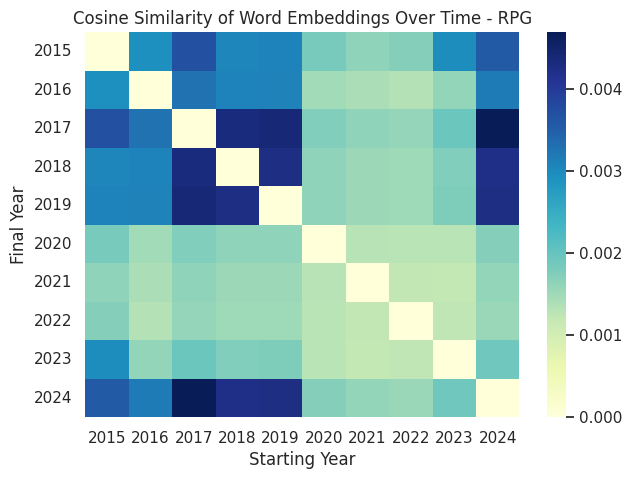

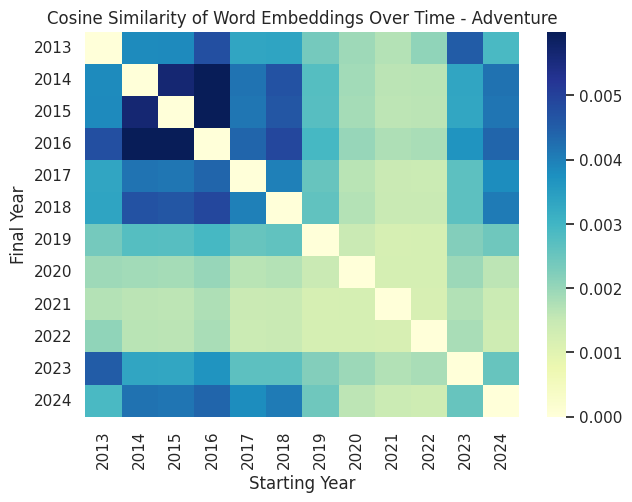

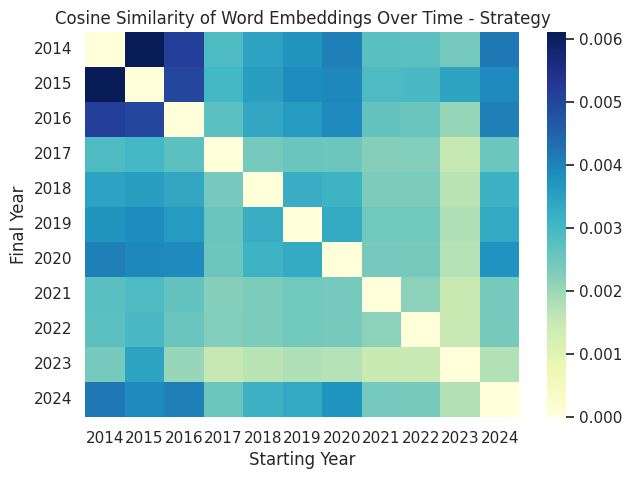

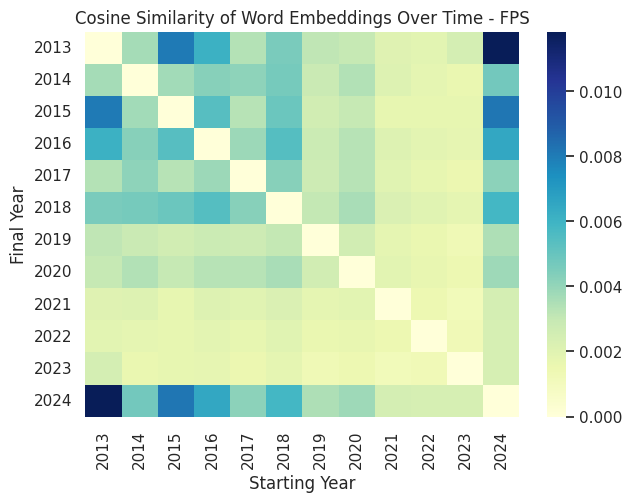

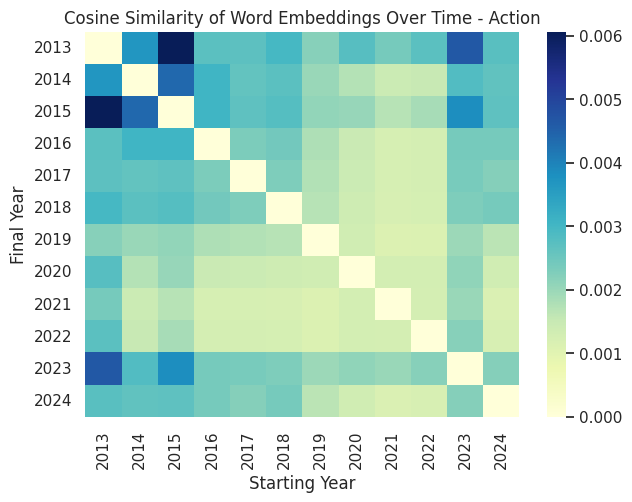

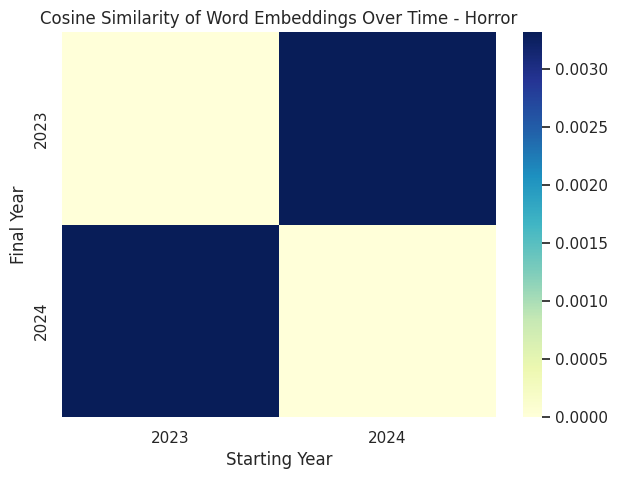

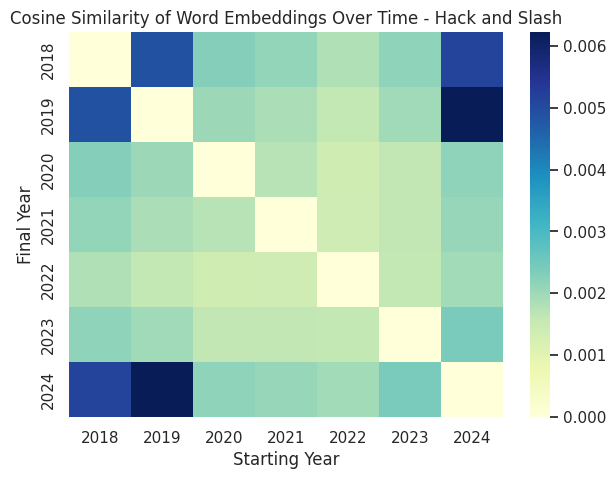

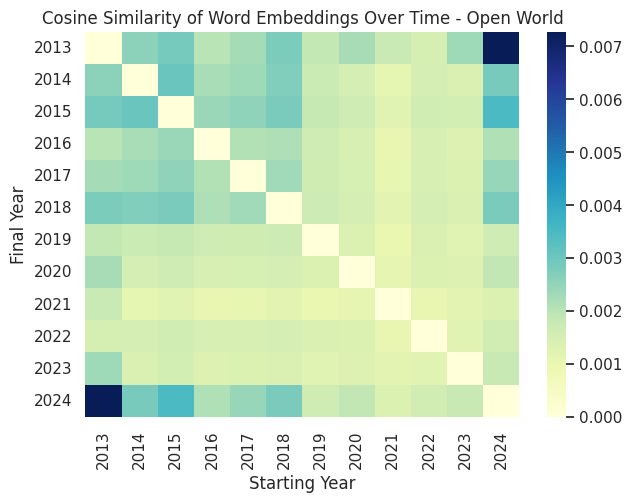

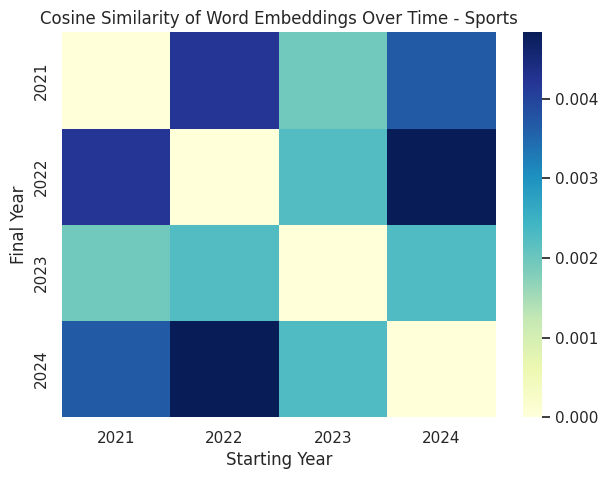

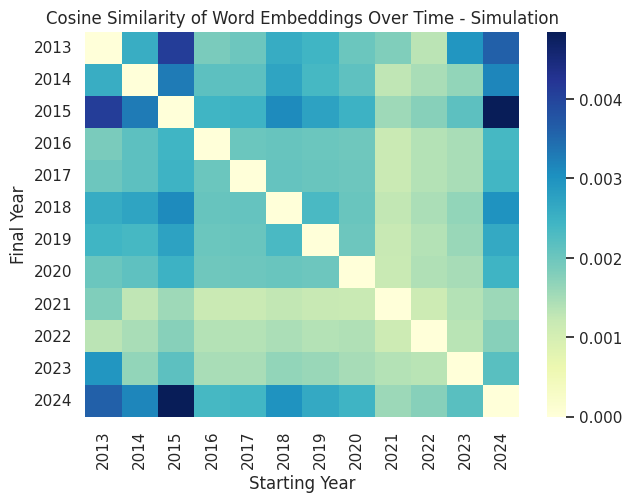

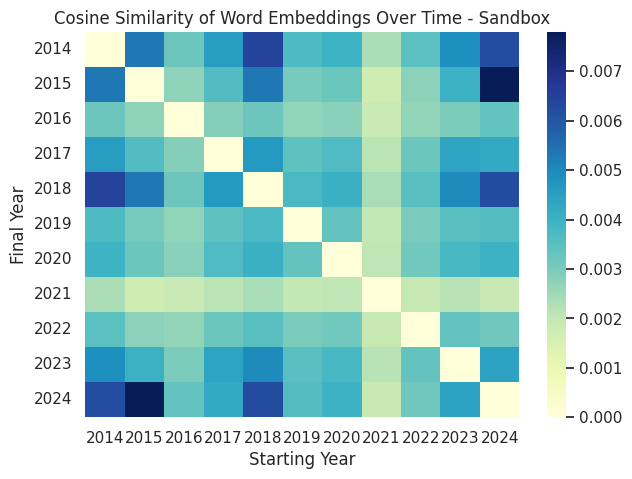

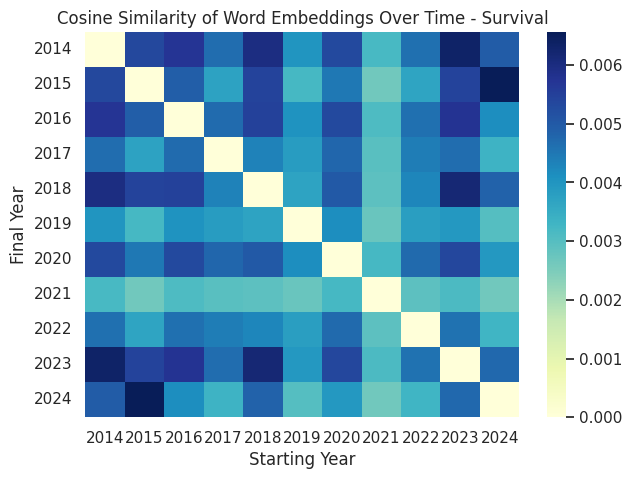

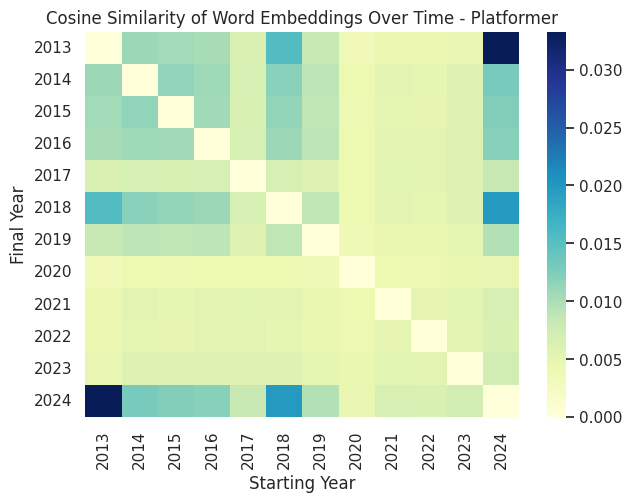

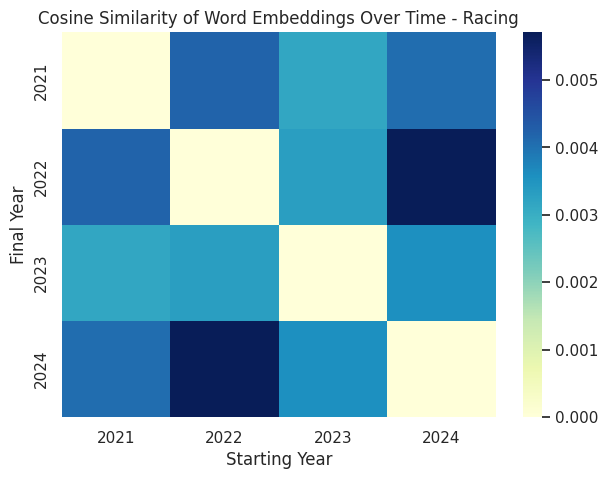

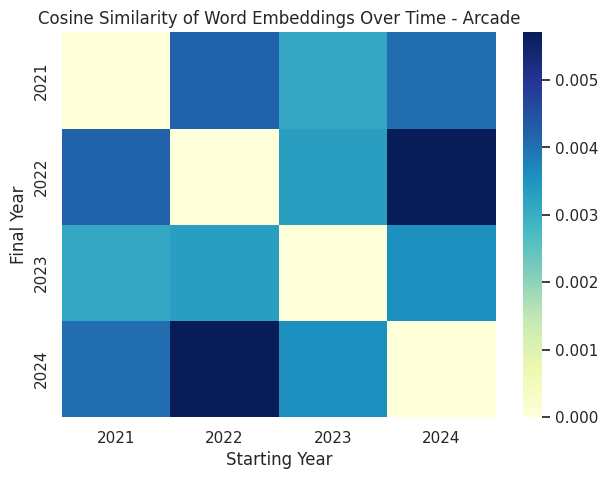

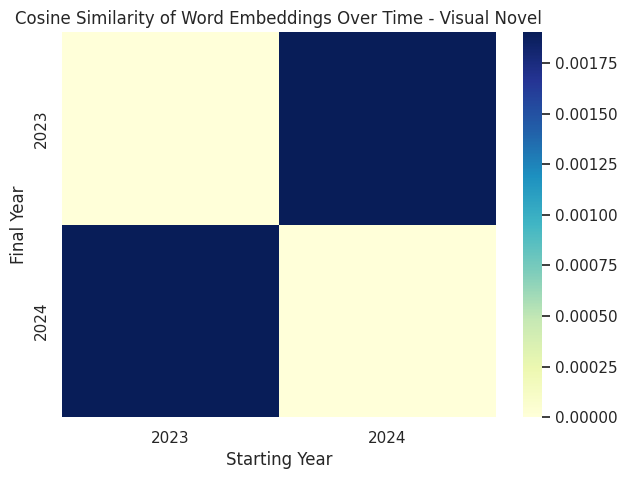

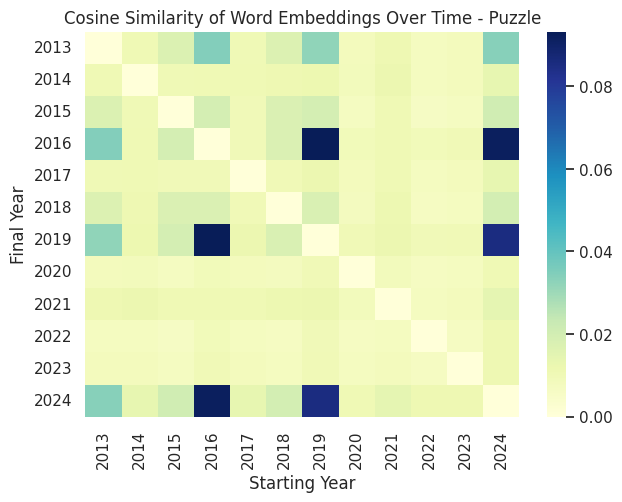

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import gensim
import pandas as pd

# Make "Year"
reviews_df['Year'] = pd.to_datetime(reviews_df['Human_Readable_Date']).dt.year

# List of excluded games
excluded_games = ['Lethal Company', 'Madden NFL 24', 'Palworld', 'Limbus Company', 'TEKKEN 8']

# Iterate over unique genres
unique_genres = reviews_df['genre'].explode().unique()
for genre in unique_genres:
    # Filter out excluded games
    if genre in excluded_games:
        continue

    # Filter reviews_df for the current genre
    genre_reviews_df = reviews_df[reviews_df['genre'].apply(lambda x: genre in x)]

    # Filter out NaN values from the 'Year' column for the current genre
    valid_years = genre_reviews_df['Year'][~np.isnan(genre_reviews_df['Year'])]

    # Convert the valid years to integers
    unique_years = np.unique(valid_years).astype(int)

    # Create an empty dictionary to store Word2Vec models for each year
    embeddings_dict = {}

    # Iterate over unique years in the DataFrame for the current genre
    for year in unique_years:
        # Filter the DataFrame for the current year and remove None values
        year_reviews = genre_reviews_df[(genre_reviews_df['Year'] == year) & (genre_reviews_df['organized_reviews'].notnull())]['organized_reviews'].tolist()

        # Train Word2Vec model for the current year if there are reviews available
        if year_reviews:
            model = gensim.models.Word2Vec(sentences=year_reviews, vector_size=100, window=5, min_count=1, workers=4)
            embeddings_dict[year] = model

    # Create an empty matrix to store cosine similarity values
    num_years = len(embeddings_dict)
    cosine_sim_matrix = np.zeros((num_years, num_years))

    # Compute cosine similarity between embeddings for each pair of years
    for i, (year1, embeddings1) in enumerate(embeddings_dict.items()):
        for j, (year2, embeddings2) in enumerate(embeddings_dict.items()):
            # Compute cosine similarity between embeddings of year1 and year2
            if i != j:  # Exclude diagonal elements
                cosine_sim_matrix[i, j] = cosine_similarity(embeddings1.wv.vectors, embeddings2.wv.vectors).mean()

    # Create a heatmap of cosine similarity for the current genre
    plt.figure(figsize=(7, 5))
    sns.heatmap(cosine_sim_matrix, annot=False, xticklabels=unique_years, yticklabels=unique_years, fmt=".2f", cmap="YlGnBu")
    plt.xlabel('Starting Year')
    plt.ylabel('Final Year')
    plt.title(f'Cosine Similarity of Word Embeddings Over Time - {genre}')
    plt.show()

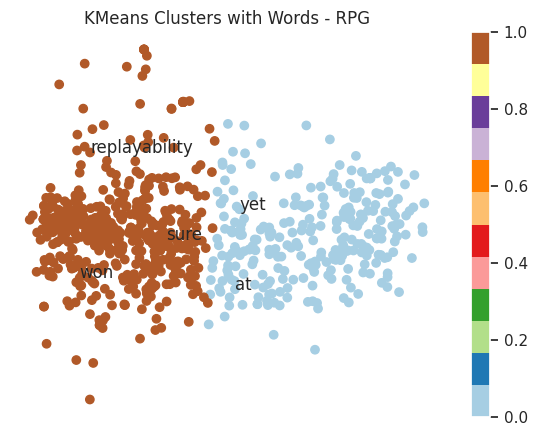

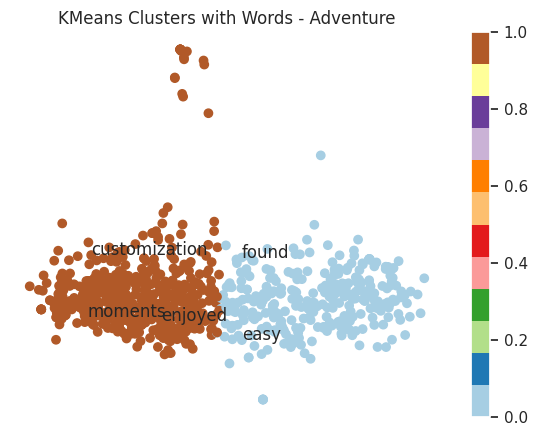

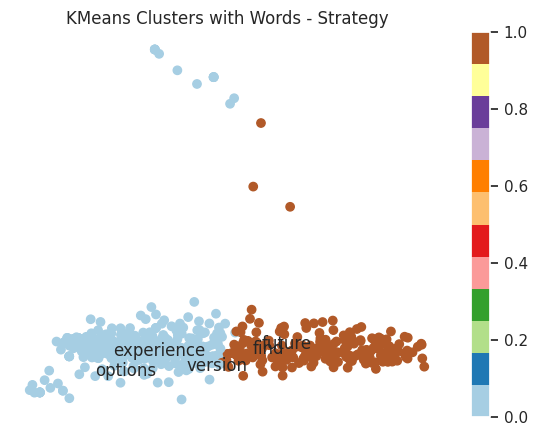

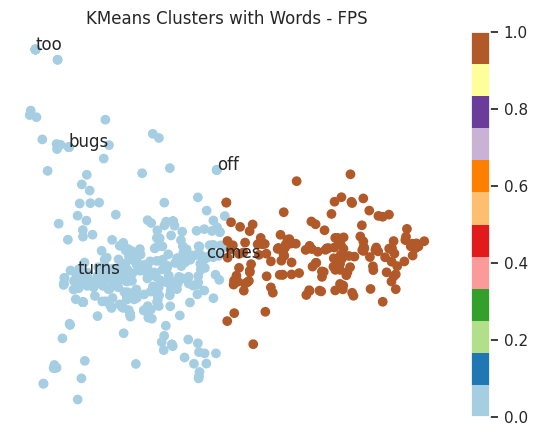

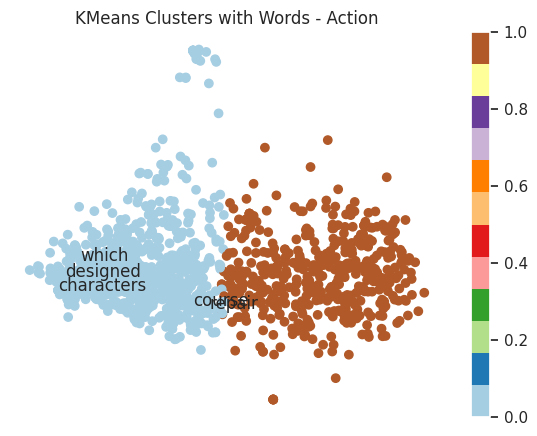

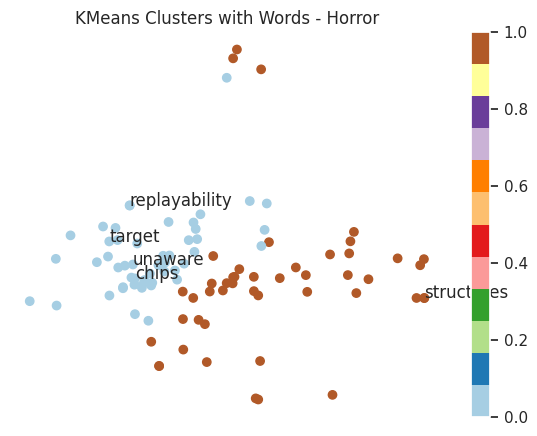

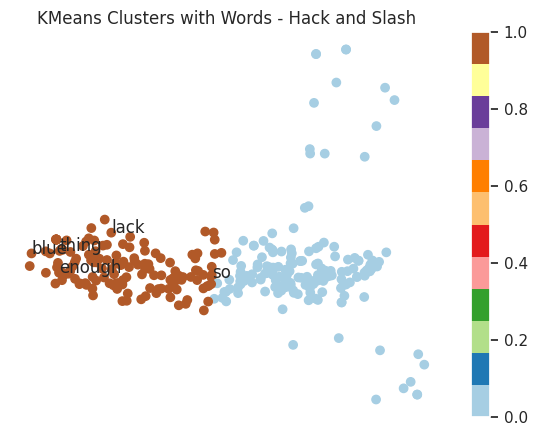

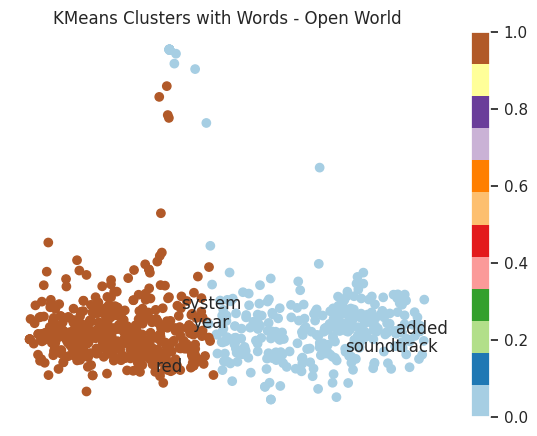

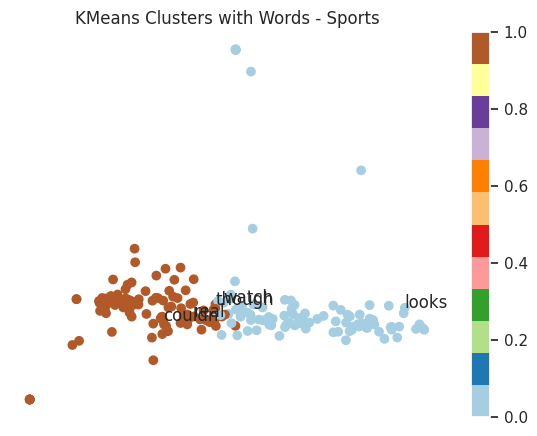

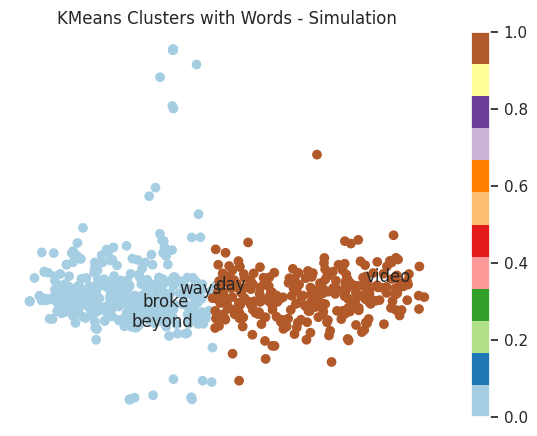

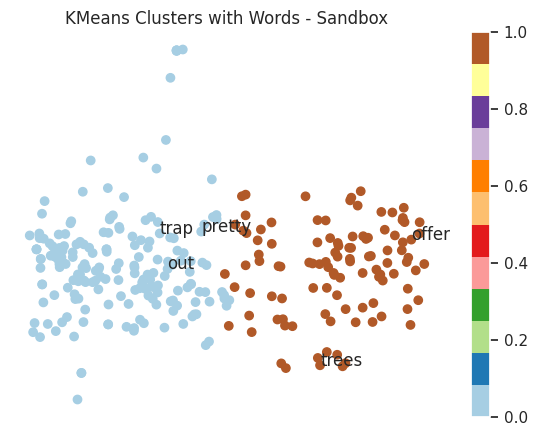

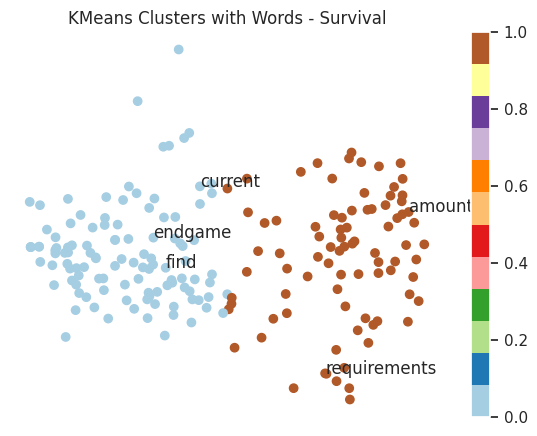

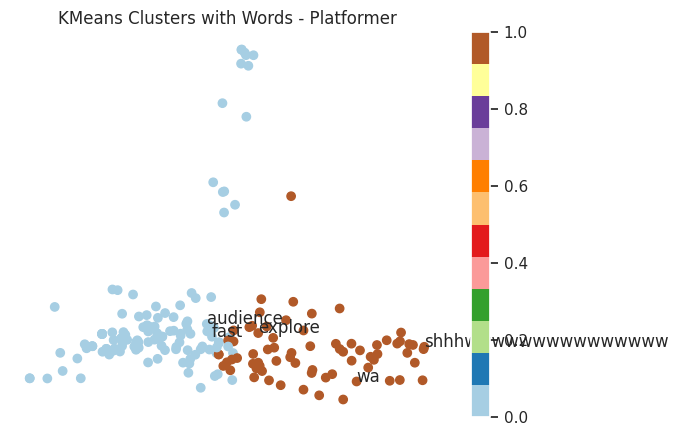

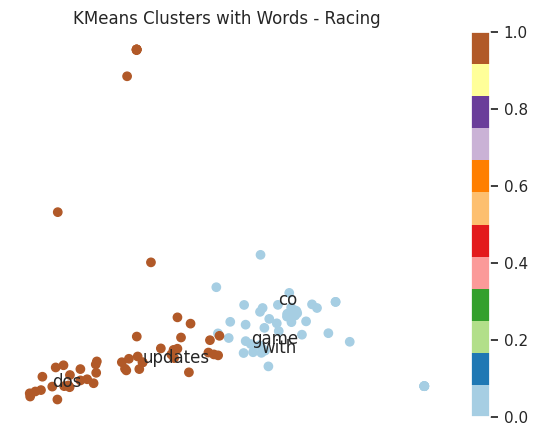

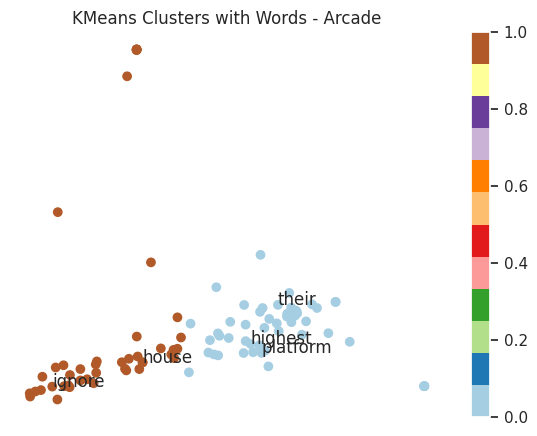

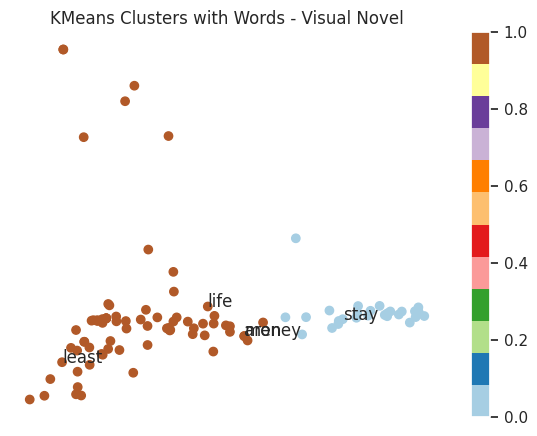

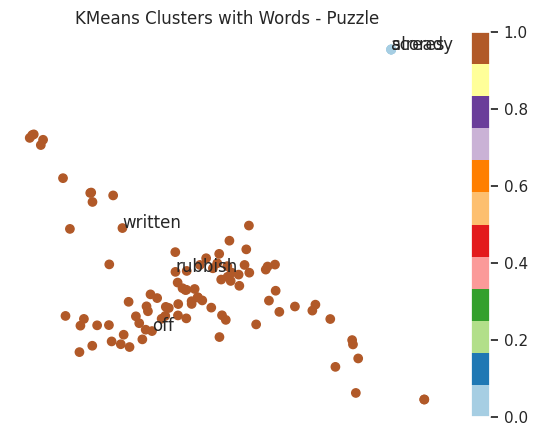

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import warnings

# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Initialize TfidfVectorizer with max_features set to the desired number
ngTFVectorizer = TfidfVectorizer(max_features=1000)

# Define the number of clusters
numClusters = 2

# Iterate over unique genre values
unique_genres = reviews_df['genre'].explode().unique()
for genre in unique_genres:
    # Subset the DataFrame by genre
    genre_reviews_df = reviews_df[reviews_df['genre'].apply(lambda x: genre in x)].copy()

    # Convert the 'Reviews' column to string type
    genre_reviews_df['Reviews'] = genre_reviews_df['Reviews'].astype(str)

    # Fit and transform the reviews to TF-IDF vectors
    reviewsTFVects = ngTFVectorizer.fit_transform(genre_reviews_df['Reviews'])

    # Apply PCA to reduce the dimensionality to 2 components
    pca = PCA(n_components=2).fit(reviewsTFVects.toarray())
    reduced_data = pca.transform(reviewsTFVects.toarray())

    # Train KMeans with the specified number of clusters
    km = KMeans(n_clusters=numClusters, init='k-means++', n_init=10)
    km.fit(reviewsTFVects)

    # Assuming 'km' is the trained KMeans model
    cluster_labels = km.labels_

    # Add the cluster labels to the DataFrame
    genre_reviews_df['kmeans_predictions'] = cluster_labels

    # Colormap for clusters
    colordict = {0: 'red', 1: 'orange', 2: 'green'}  # Update with the appropriate colors

    # Convert feature names to a list
    feature_names = list(ngTFVectorizer.get_feature_names_out())

    # Randomly select thirty words from feature names
    random_words = random.sample(feature_names, 5)

    # Scatter plot with words
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)

    # Use 'c' parameter instead of 'color', and pass the cluster labels directly
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=genre_reviews_df['kmeans_predictions'], cmap=plt.cm.Paired)

    # Annotate the plot with words
    for i, word in enumerate(random_words):
        ax.annotate(word, (reduced_data[i, 0], reduced_data[i, 1]))

    # Add colorbar
    plt.colorbar(scatter, ax=ax)

    plt.xticks(())
    plt.yticks(())
    plt.title(f'KMeans Clusters with Words - {genre}')
    plt.show()

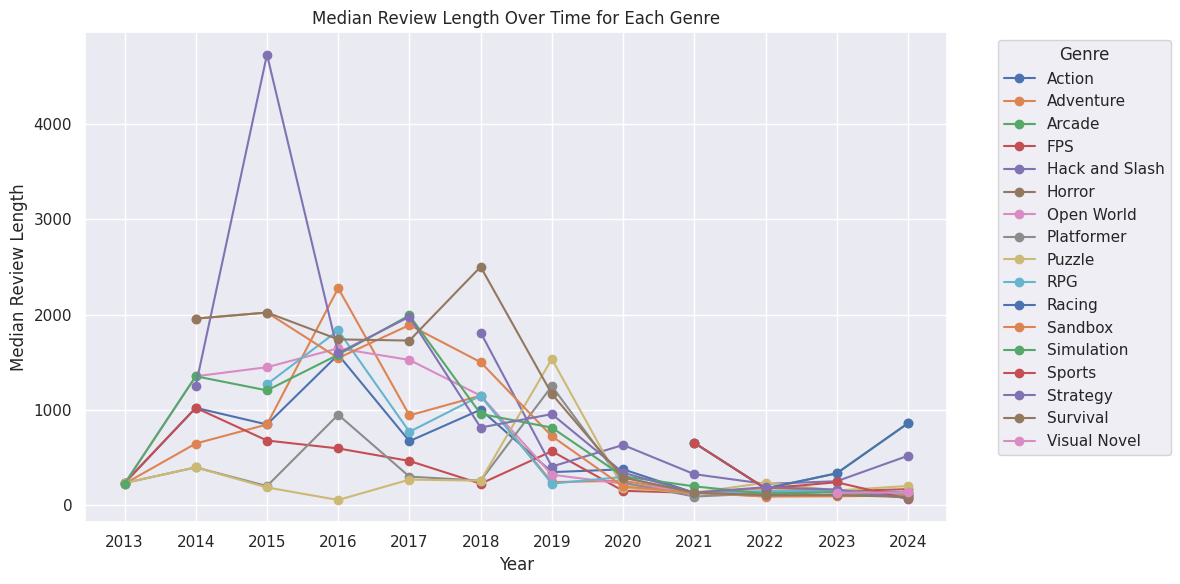

In [ ]:
# Explode the 'genre' column into separate rows
exploded_df = reviews_df.explode('genre')

# Drop rows with NaN values in the 'Year' column
exploded_df = exploded_df.dropna(subset=['Year'])

# Create a new column for the length of each review using .loc to avoid the warning
exploded_df.loc[:, 'Review_Length'] = exploded_df['Reviews'].apply(len)

# Plot the median review length over time for each genre
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

for genre, data in exploded_df.groupby('genre'):
    median_review_length = data.groupby('Year')['Review_Length'].median()
    plt.plot(median_review_length.index, median_review_length.values, marker='o', label=genre)

plt.xlabel('Year')
plt.ylabel('Median Review Length')
plt.title('Median Review Length Over Time for Each Genre')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the x-axis ticks to display every year
plt.xticks(sorted(exploded_df['Year'].unique()))

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Drop rows with NaN values in the 'Year' column
reviews_df = reviews_df.dropna(subset=['Year'])

# Explode the 'genre' column to create multiple rows for each genre tag
exploded_df = reviews_df.explode('genre')

# Group by year and genre, and calculate the median review length
median_review_length = exploded_df.groupby(['Year', 'genre'])['Review_Length'].median().reset_index()

# Prepare the data for regression analysis
X = sm.add_constant(median_review_length['Year'])  # Add a constant for the intercept
y = median_review_length['Review_Length']

# Take the natural logarithm of the response variable
y_log = np.log(y)

# Fit the logarithmic regression model
model = sm.OLS(y_log, X)
results = model.fit()

# Print the summary of the regression analysis
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Review_Length   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     97.38
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           5.81e-18
Time:                        00:12:53   Log-Likelihood:                -181.85
No. Observations:                 150   AIC:                             367.7
Df Residuals:                     148   BIC:                             373.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        398.3949     39.776     10.016      0.0

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [ ]:
import spacy
import numpy as np
from collections import defaultdict
import random

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Create a dictionary to store complexity measures for each genre
genre_complexity = defaultdict(list)

# Iterate through each row in the DataFrame
for index, row in reviews_df.iterrows():
    # Extract the list of genres from the row
    genres = row['genre']

    # Iterate through each genre in the list
    for genre in genres:
        # Filter reviews for the current genre
        genre_reviews = reviews_df[reviews_df['genre'].apply(lambda x: genre in x)]

        # Randomly select one review for the genre
        selected_review = genre_reviews.sample(n=1)['Reviews'].iloc[0]

        # Calculate complexity measures for the selected review
        doc = nlp(selected_review)
        num_nodes = len(list(doc))
        depth = max([token.i - token.head.i for token in doc]) + 1

        # Store complexity measures for the genre
        genre_complexity[genre].append({
            'num_nodes': num_nodes,
            'depth': depth
        })

# Calculate average complexity measures for each genre
average_complexity = {}
for genre, complexity_list in genre_complexity.items():
    avg_num_nodes = np.mean([c['num_nodes'] for c in complexity_list])
    avg_depth = np.mean([c['depth'] for c in complexity_list])
    complexity_total = avg_num_nodes * avg_depth

    average_complexity[genre] = {
        'avg_num_nodes': avg_num_nodes,
        'avg_depth': avg_depth,
        'complexity_total': complexity_total
    }

# Print average complexity measures for each genre
for genre, complexity in average_complexity.items():
    print(f"Genre: {genre}")
    print(f"Average Number of Nodes: {complexity['avg_num_nodes']}")
    print(f"Average Depth: {complexity['avg_depth']}")
    print(f"Complexity Total: {complexity['complexity_total']}")
    print()

Genre: RPG
Average Number of Nodes: 248.79119496855347
Average Depth: 31.738364779874214
Complexity Total: 7896.2256999327565

Genre: Adventure
Average Number of Nodes: 239.9472502805836
Average Depth: 32.24915824915825
Complexity Total: 7738.096845748922

Genre: Strategy
Average Number of Nodes: 201.87269681742043
Average Depth: 24.946398659966498
Complexity Total: 5035.99677336992

Genre: FPS
Average Number of Nodes: 208.90707070707072
Average Depth: 29.038383838383837
Complexity Total: 6066.323705744312

Genre: Action
Average Number of Nodes: 227.73612112472964
Average Depth: 30.279019466474406
Complexity Total: 6895.626444755062

Genre: Horror
Average Number of Nodes: 76.23711340206185
Average Depth: 23.20618556701031
Complexity Total: 1769.1726007014558

Genre: Hack and Slash
Average Number of Nodes: 280.2733333333333
Average Depth: 25.566666666666666
Complexity Total: 7165.654888888888

Genre: Open World
Average Number of Nodes: 237.83080808080808
Average Depth: 29.61363636363636

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import nltk
nltk.download('vader_lexicon')

# Convert the 'Reviews' column to strings
reviews_df['Reviews'] = reviews_df['Reviews'].astype(str)

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Create a function to compute sentiment scores for each review
def calculate_sentiment(review):
    return sid.polarity_scores(review)['compound']

# Create a new column to store sentiment scores for each review
reviews_df['Sentiment'] = reviews_df['Reviews'].apply(calculate_sentiment)

# Create a list to store sentiment scores for each genre
genre_sentiments = []

# Iterate through each row in the DataFrame
for index, row in reviews_df.iterrows():
    # Extract the list of genres from the row
    genres = row['genre']

    # Iterate through each genre in the list
    for genre in genres:
        # Append the sentiment score along with the genre to the list
        genre_sentiments.append({'Genre': genre, 'Sentiment': row['Sentiment']})

# Create a DataFrame from the list of genre sentiments
genre_sentiments_df = pd.DataFrame(genre_sentiments)

# Group by genre and calculate the mean sentiment score
genre_mean_sentiments = genre_sentiments_df.groupby('Genre')['Sentiment'].mean().reset_index()

# Display the aggregated sentiment scores for each game genre
print(genre_mean_sentiments)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


             Genre  Sentiment
0           Action   0.253111
1        Adventure   0.327316
2           Arcade   0.403551
3              FPS   0.255698
4   Hack and Slash   0.306249
5           Horror   0.152211
6       Open World   0.368461
7       Platformer   0.489732
8           Puzzle   0.580103
9              RPG   0.332129
10          Racing   0.403551
11         Sandbox   0.373534
12      Simulation   0.244740
13          Sports   0.178299
14        Strategy   0.231036
15        Survival   0.374903
16    Visual Novel   0.291602


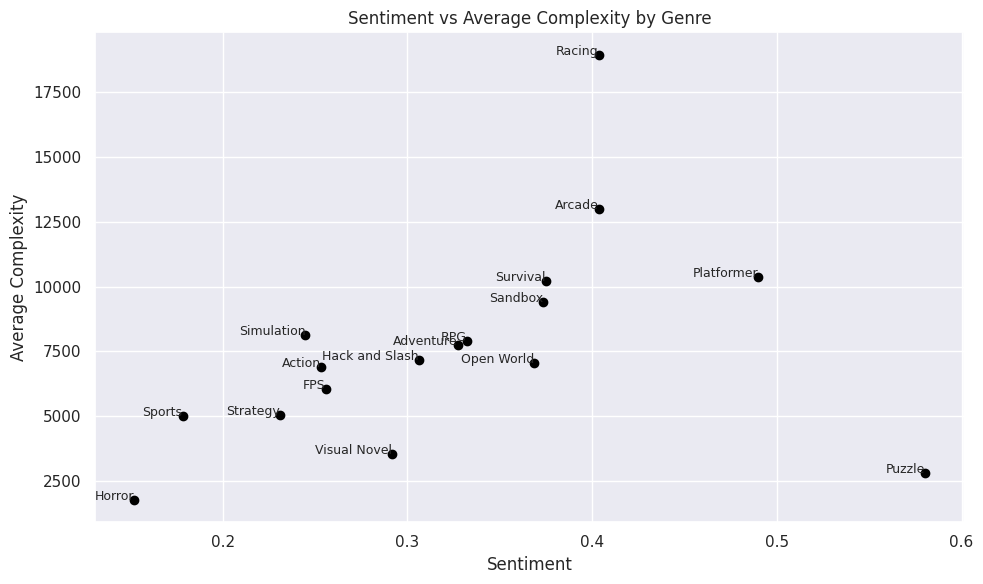

In [ ]:
import matplotlib.pyplot as plt

# Define the data for complexity and sentiment
genres = [
    'RPG', 'Adventure', 'Strategy', 'FPS', 'Action', 'Horror', 'Hack and Slash',
    'Open World', 'Sports', 'Simulation', 'Sandbox', 'Survival', 'Platformer',
    'Racing', 'Arcade', 'Visual Novel', 'Puzzle'
]
complexity_total = [
    7896.23, 7738.10, 5036.00, 6066.32, 6895.63, 1769.17, 7165.65, 7043.04, 5006.39,
    8134.96, 9414.68, 10196.45, 10358.29, 18942.46, 12993.54, 3528.16, 2803.31
]
sentiment = [
    0.332129, 0.327316, 0.231036, 0.255698, 0.253111, 0.152211, 0.306249, 0.368461,
    0.178299, 0.244740, 0.373534, 0.374903, 0.489732, 0.403551, 0.403551, 0.291602,
    0.580103
]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(sentiment, complexity_total, color='black')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Average Complexity')
plt.title('Sentiment vs Average Complexity by Genre')

# Add genre labels
for i, genre in enumerate(genres):
    plt.text(sentiment[i], complexity_total[i], genre, fontsize=9, ha='right')

plt.grid(True)
plt.tight_layout()
plt.show()